In [1]:
from drought.data import pipeline, interpolate, seasonal, pai_vertical
from drought.visualization import plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_theme()
pd.options.mode.chained_assignment = None

In [2]:
palette = sns.color_palette("Set2")

## Get data

In [3]:
climate = pd.read_csv('../../data/interim/all_climate_monthly_mean_5000_scale_2001_to_2023.csv', index_col=0)
gedi = pd.read_csv('../../data/interim/gedi_monthly_extended_interpolated_March_11.csv', index_col=0)

In [4]:
# Look at only gedi months that have at least 5000 shots per region.
gedi = gedi[gedi.number > 5000]

In [5]:
climate_columns = ['precipitation', 'radiation', 'temperature', 'fpar', 'PET', 'P-PET']

In [6]:
gedi['polygon_id'] = gedi.polygon_id.astype(int)

### Climate statistics

In [7]:
# Number of dry months per polygon
climate_copy = climate.copy()
climate_copy['dry_month'] = (climate_copy.precipitation < 100).astype(int)
dry_months = climate_copy.groupby(['year', 'polygon_id']).sum(numeric_only=True)['dry_month'].reset_index()
print(dry_months.groupby('polygon_id').mean()['dry_month'])
    

polygon_id
1    0.045455
2    0.090909
3    1.136364
4    3.318182
5    4.363636
6    6.045455
7    8.045455
8    8.909091
Name: dry_month, dtype: float64


In [8]:
# Number of months in water deficit per polygon.
climate_copy = climate[climate.datetime > '2005-01-01'].copy()
climate_copy['water_deficit'] = (climate_copy['P-PET'] < 0).astype(int)
water_deficit = climate_copy.groupby(['year', 'polygon_id']).sum(numeric_only=True)['water_deficit'].reset_index()
print(water_deficit.groupby('polygon_id').mean()['water_deficit'])

polygon_id
1     0.666667
2     0.888889
3     3.944444
4     5.611111
5     5.666667
6     8.611111
7    11.222222
8    11.111111
Name: water_deficit, dtype: float64


### Climate variables across polygons

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/1077752427.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


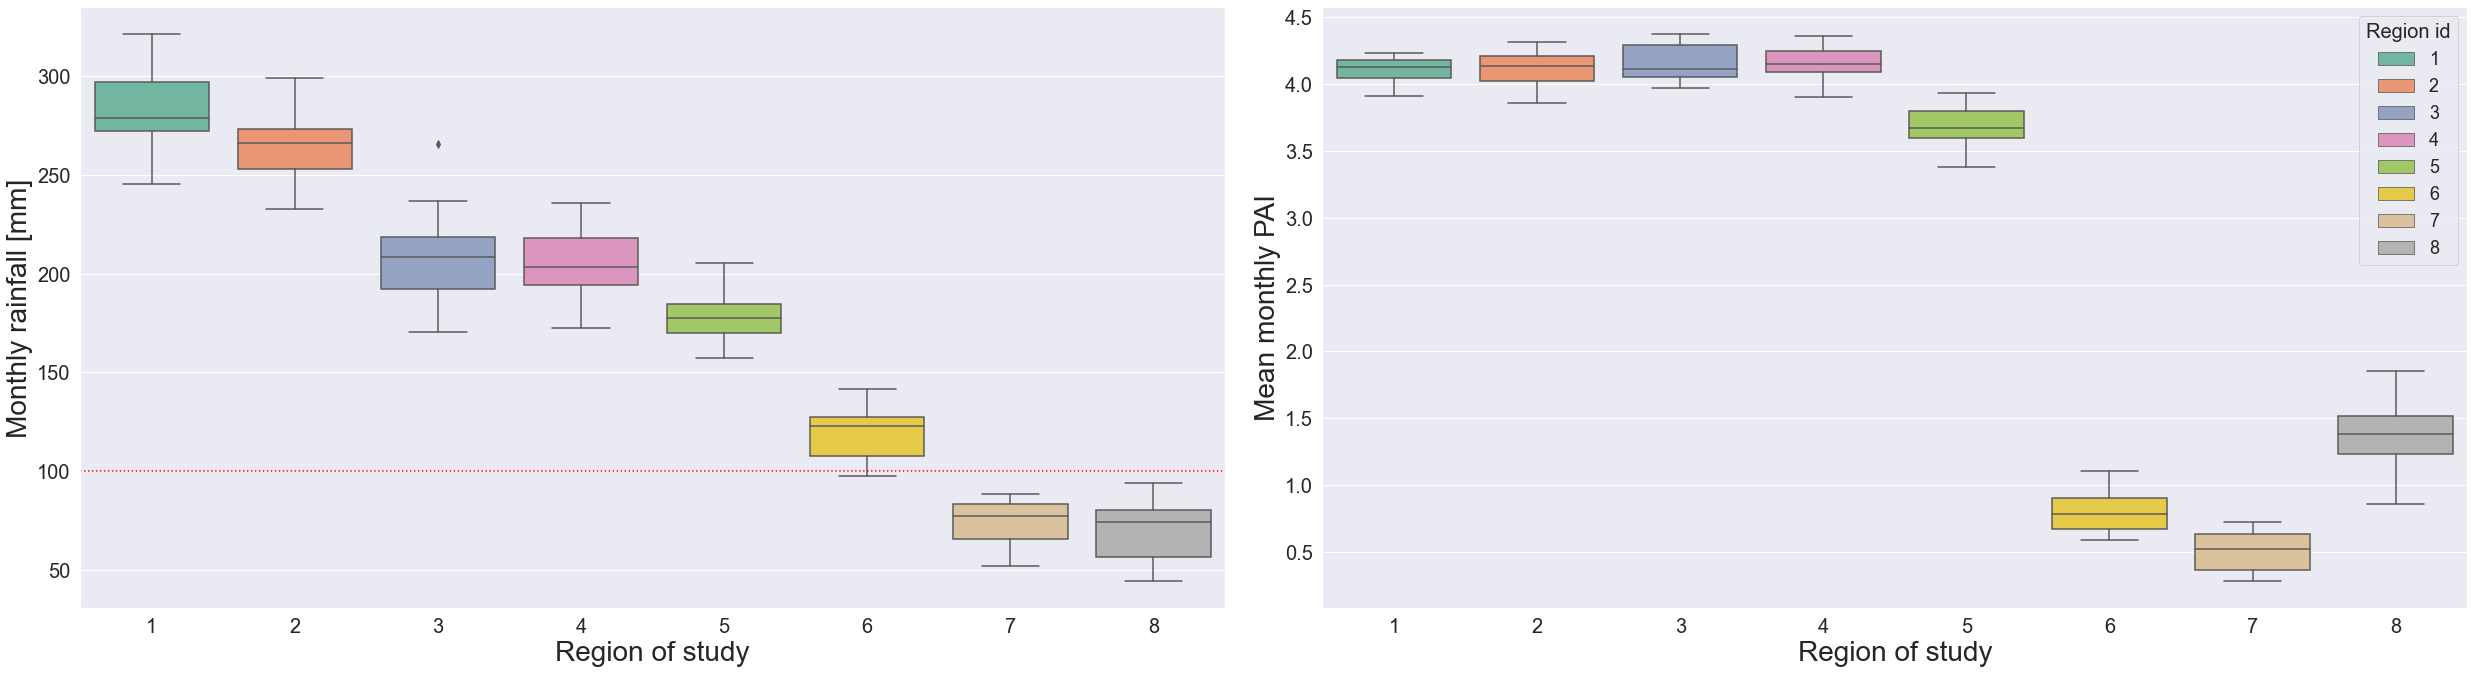

In [10]:
# Average annual monthly precipitation
fig, ax = plt.subplots(1, 2, figsize=(35, 10))

yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly, x='polygon_id', y='precipitation', palette=palette, ax=ax[0])
ax[0].axhline(y = 100, color='red', linestyle='dotted')
graph.set_ylabel("Monthly rainfall [mm]",fontsize=28)
graph.set_xlabel("Region of study",fontsize=28)

# vs. monthly PAI
graph = sns.boxplot(gedi, x='polygon_id', y='pai', palette=palette, ax=ax[1], hue='polygon_id', dodge=False)
graph.set_ylabel("Mean monthly PAI",fontsize=28)
graph.set_xlabel("Region of study",fontsize=28)

plt.setp(graph.get_legend().get_title(), fontsize='20') 
sns.move_legend(graph, "upper right", title="Region id", fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout(pad=3.0)

fig.savefig("../../reports/figures/final/monthly_rain_vs_pai.png") 

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/229076507.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).sum().reset_index()
/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/229076507.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


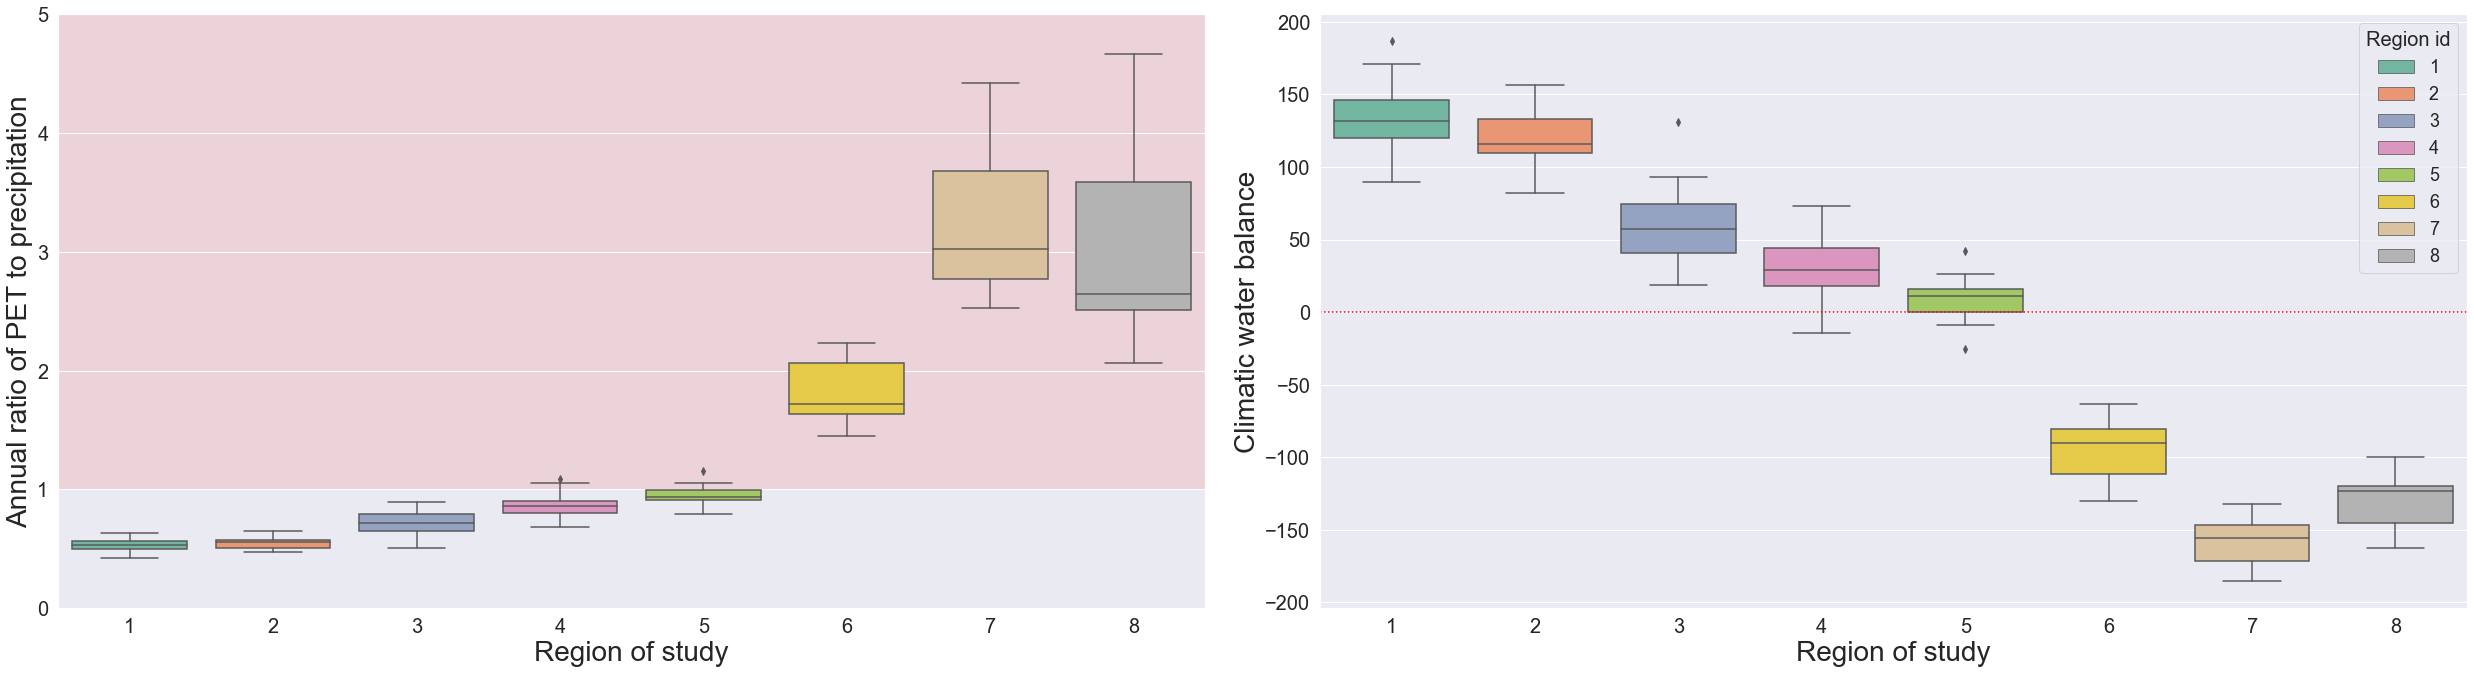

In [12]:
# Ratio of PET to precipitation
fig, ax = plt.subplots(1, 2, figsize=(35, 10))
yearly = climate.groupby(['polygon_id', 'year']).sum().reset_index()
yearly['PET:P'] = yearly.PET / yearly.precipitation
ax[0].axhspan(1, 30, alpha=0.1, color='red', zorder=-100)
graph = sns.boxplot(yearly, x='polygon_id', y='PET:P', palette=palette, ax=ax[0])
graph.set_ylabel("Annual ratio of PET to precipitation",fontsize=28)
graph.set_xlabel("Region of study",fontsize=28)
graph.set_ylim((0,5))


# vs. climatic water balance
yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly, x='polygon_id', y='P-PET', palette=palette, ax=ax[1], hue='polygon_id', dodge=False)
graph.set_ylabel("Climatic water balance",fontsize=28)
graph.set_xlabel("Region of study",fontsize=28)
plt.setp(graph.get_legend().get_title(), fontsize='20') 
ax[1].axhline(y = 0, color='red', linestyle='dotted')
sns.move_legend(graph, "upper right", title="Region id", fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout(pad=3.0)

fig.savefig("../../reports/figures/final/Pet-P-ratio_vs_climatic_water_balance.png") 

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/3243716196.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).sum().reset_index()


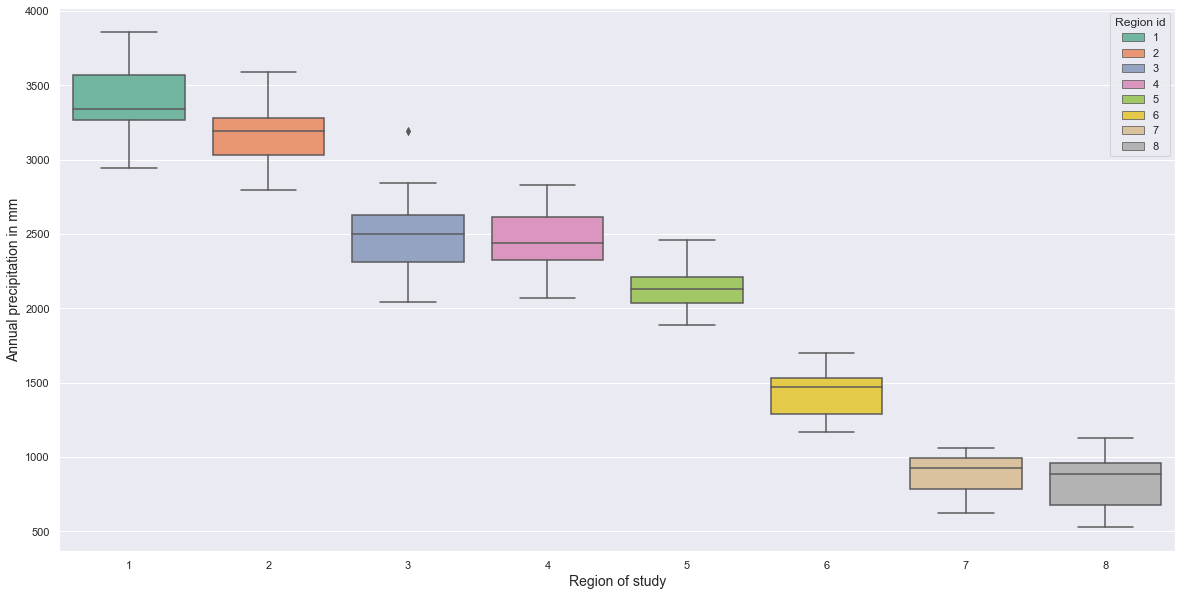

In [13]:
# Total annual precipitation
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
yearly = climate.groupby(['polygon_id', 'year']).sum().reset_index()
graph = sns.boxplot(yearly, x='polygon_id', y='precipitation', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Annual precipitation in mm",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "upper right", title="Region id")
fig.savefig("../../reports/figures/final/total_annual_precipitation_per_polygon") 

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/425025424.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


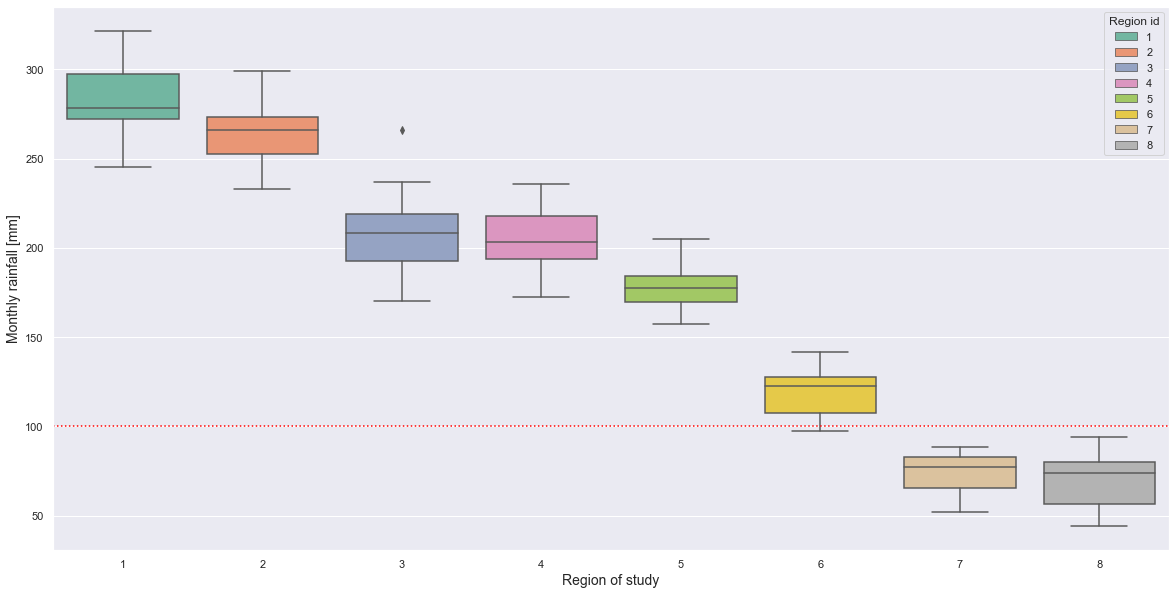

In [14]:
# Average annual monthly precipitation.
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly, x='polygon_id', y='precipitation', palette=palette, ax=ax, hue='polygon_id', dodge=False)
plt.axhline(y = 100, color='red', linestyle='dotted')
graph.set_ylabel("Monthly rainfall [mm]",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "upper right", title="Region id")
fig.savefig("../../reports/figures/final/monthly_mean_precipitation_per_polygon.png") 

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/3634321703.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


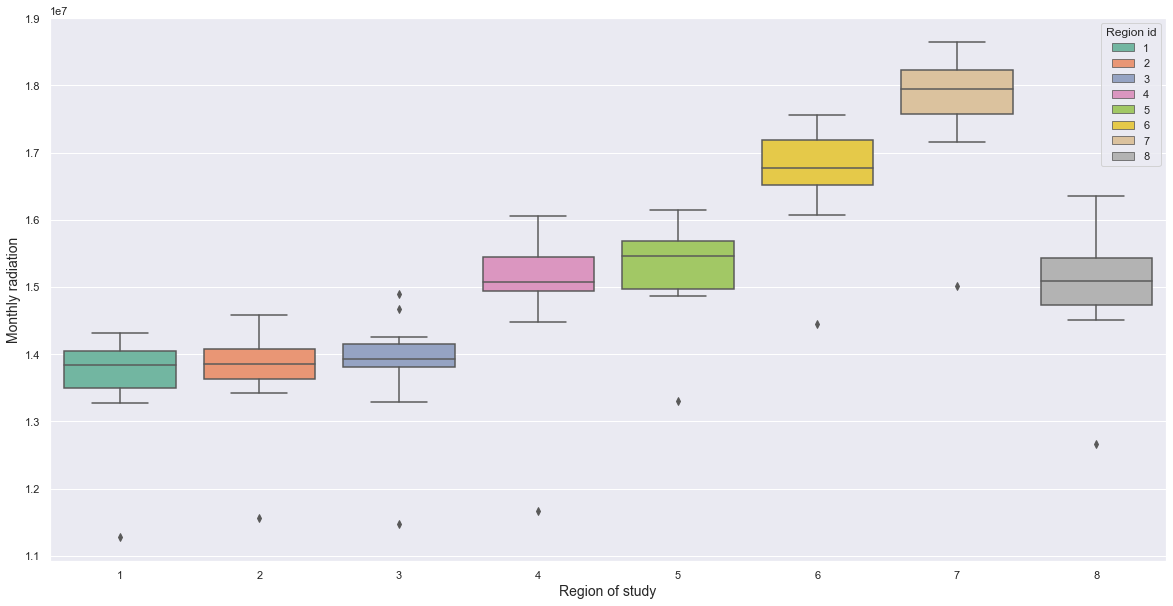

In [15]:
# Average monthly radiation.
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly, x='polygon_id', y='radiation', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Monthly radiation",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "upper right", title="Region id")

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/1845514212.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


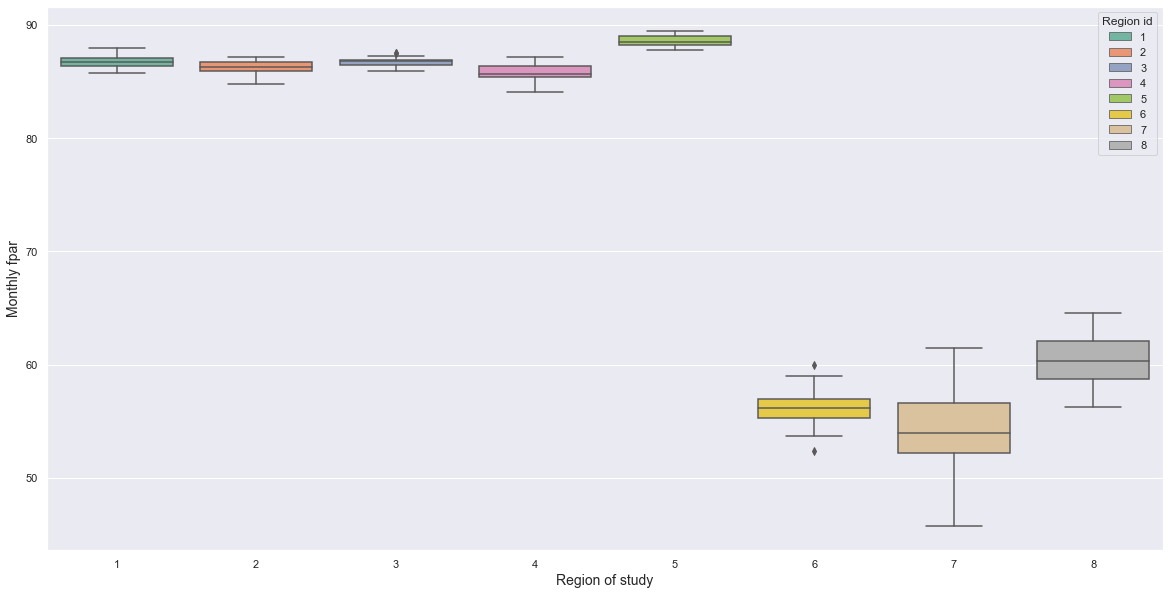

In [16]:
# Average annual monthly fpar.
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly, x='polygon_id', y='fpar', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Monthly fpar",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "upper right", title="Region id")

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/350343493.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


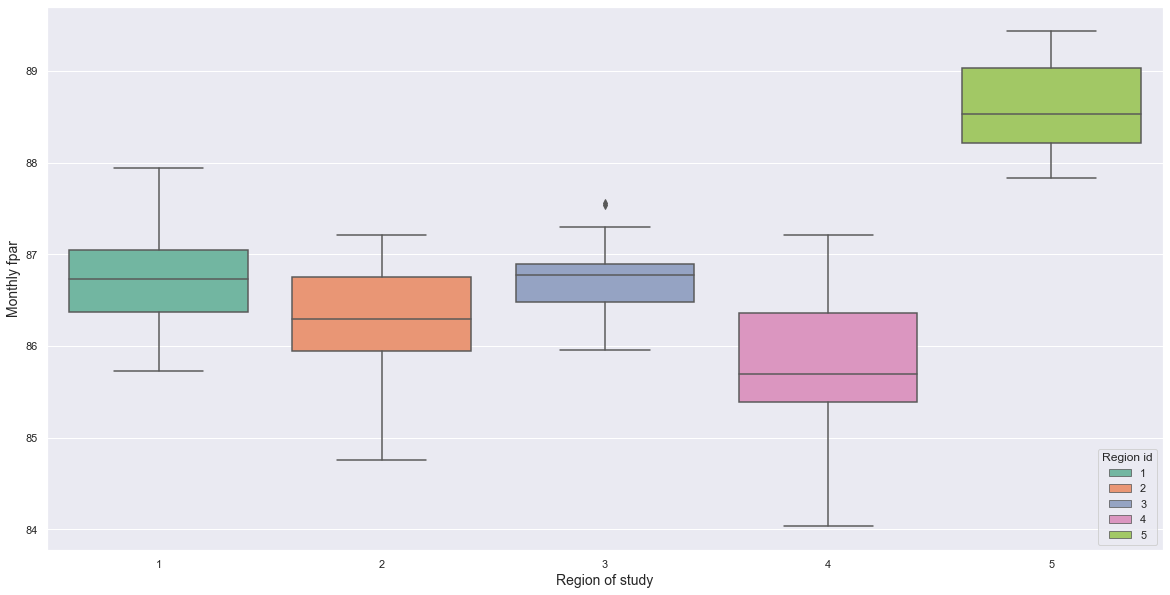

In [17]:
# Average annual monthly fpar for Amazon regions.
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly[yearly.polygon_id < 6], x='polygon_id', y='fpar', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Monthly fpar",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "lower right", title="Region id")

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/2698504079.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


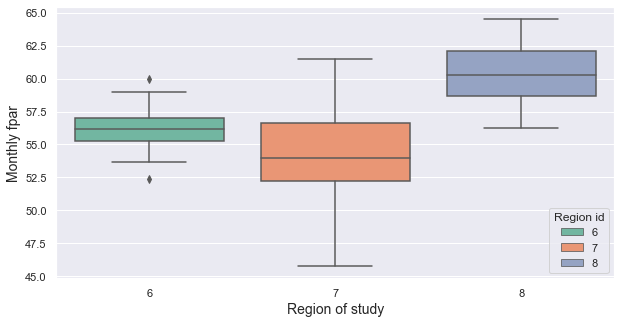

In [18]:
# Average annual monthly fpar for STDF regions.
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly[yearly.polygon_id > 5], x='polygon_id', y='fpar', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Monthly fpar",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "lower right", title="Region id")

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/3408829604.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


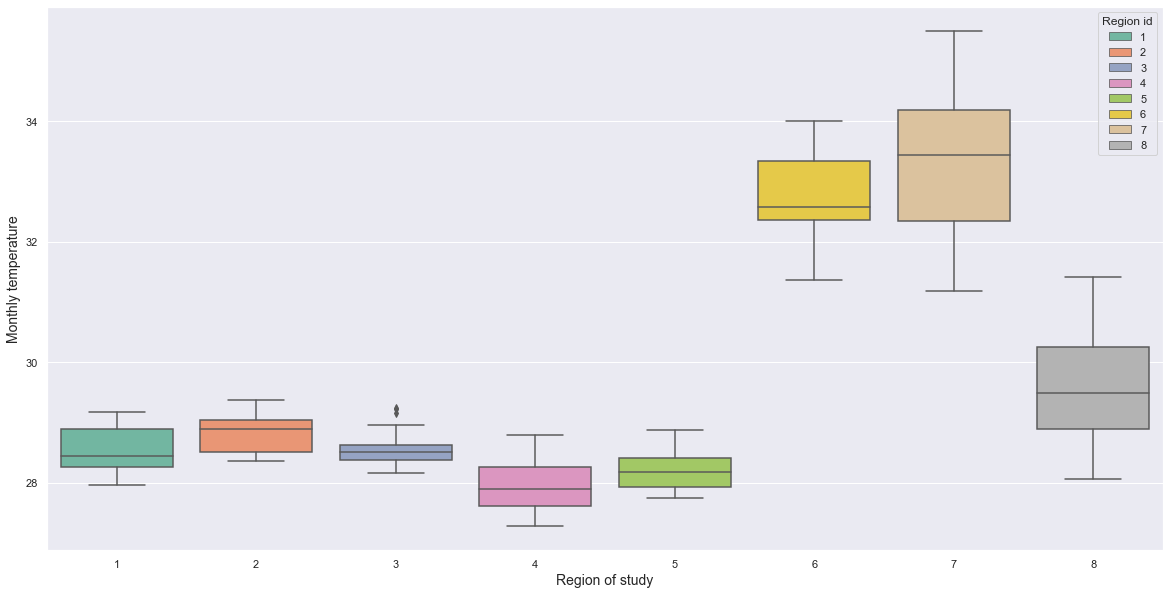

In [19]:
# Average monthly temperature.
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly, x='polygon_id', y='temperature', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Monthly temperature",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "upper right", title="Region id")

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/415198183.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


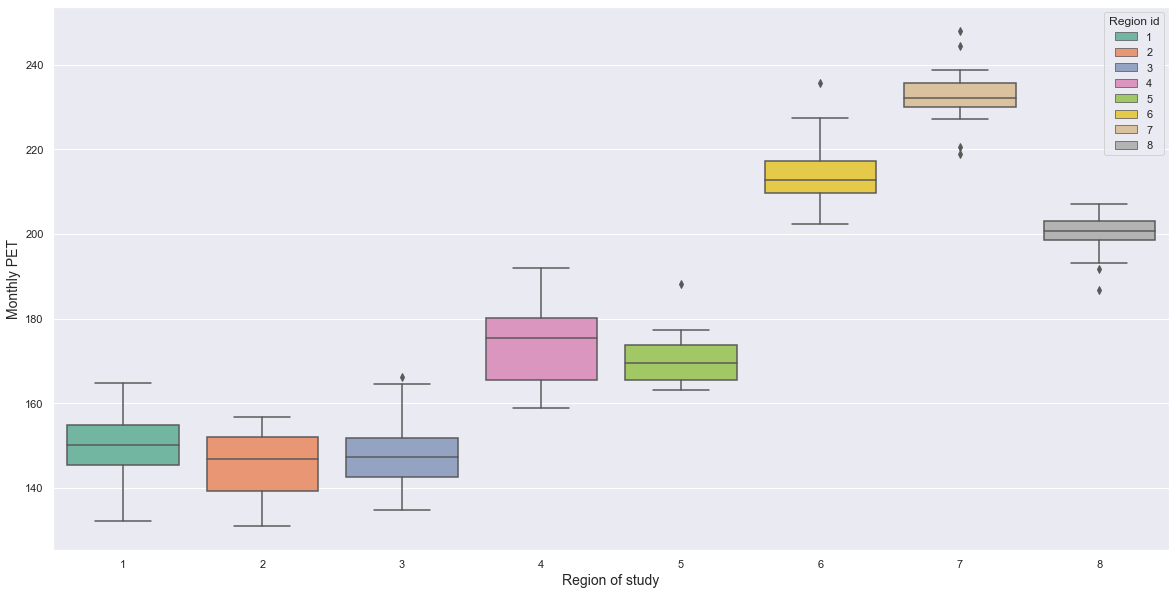

In [20]:
# Average annual monthly PET.
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly, x='polygon_id', y='PET', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Monthly PET",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "upper right", title="Region id")

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/880988642.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()


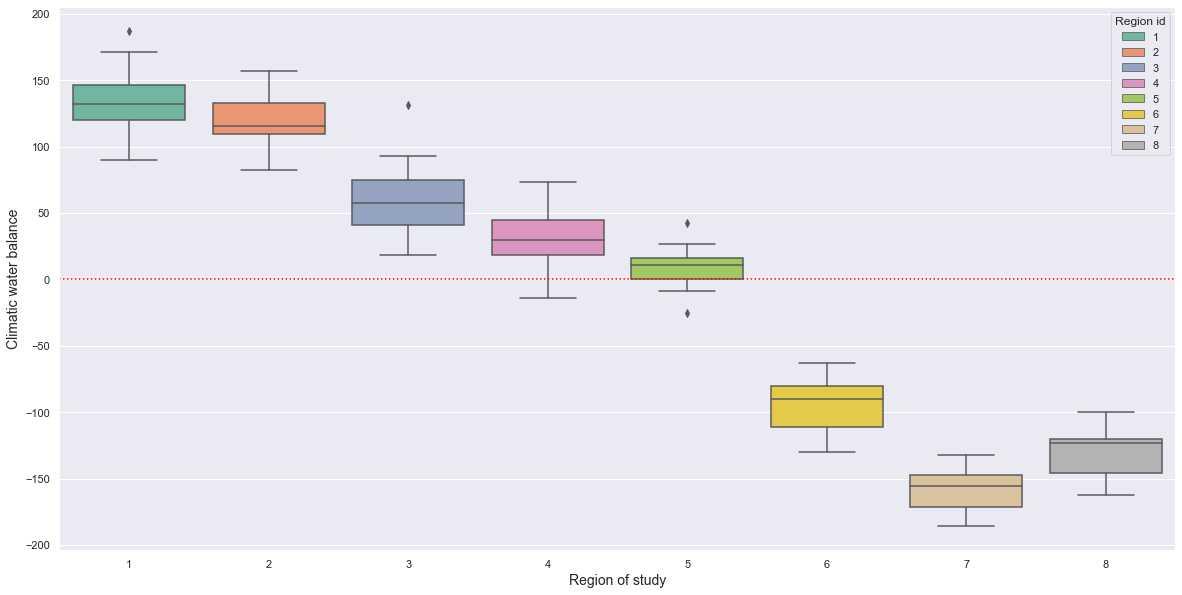

In [21]:
# Average annual climatic water balance.
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
yearly = climate.groupby(['polygon_id', 'year']).mean().reset_index()
graph = sns.boxplot(yearly, x='polygon_id', y='P-PET', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Climatic water balance",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
plt.axhline(y = 0, color='red', linestyle='dotted')
sns.move_legend(graph, "upper right", title="Region id")
fig.savefig("../../reports/figures/final/climatic_water_balance_per_polygon.png") 

### Plot vegetation variables pre polygon

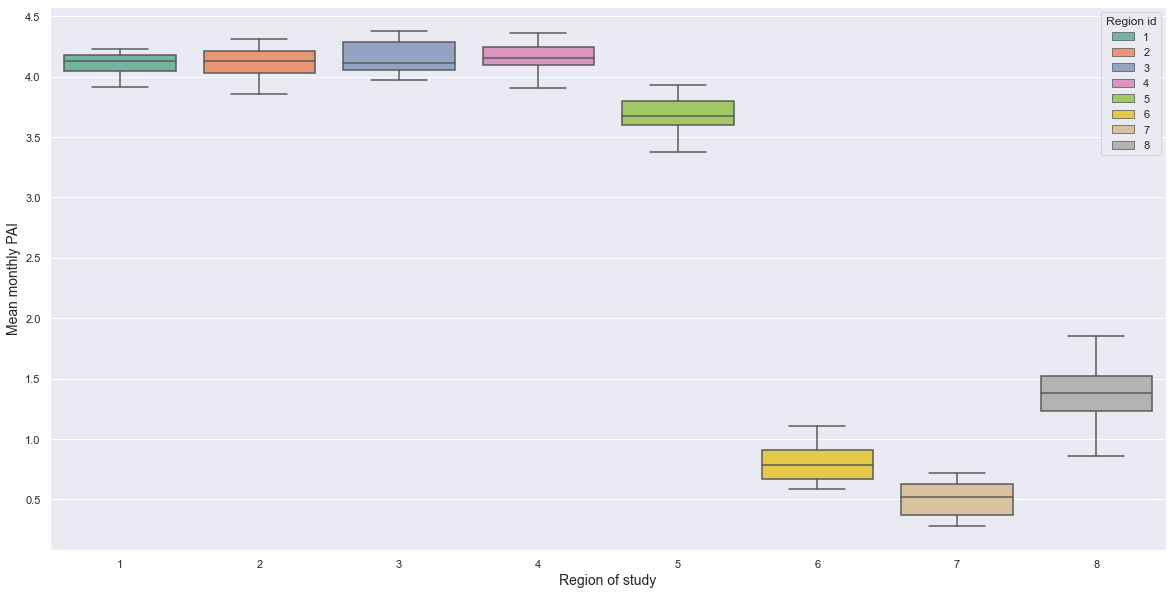

In [22]:
# Mean monthly PAI.
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
graph = sns.boxplot(gedi, x='polygon_id', y='pai', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Mean monthly PAI",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "upper right", title="Region id")
fig.savefig("../../reports/figures/final/monthly_pai_per_polygon.png") 

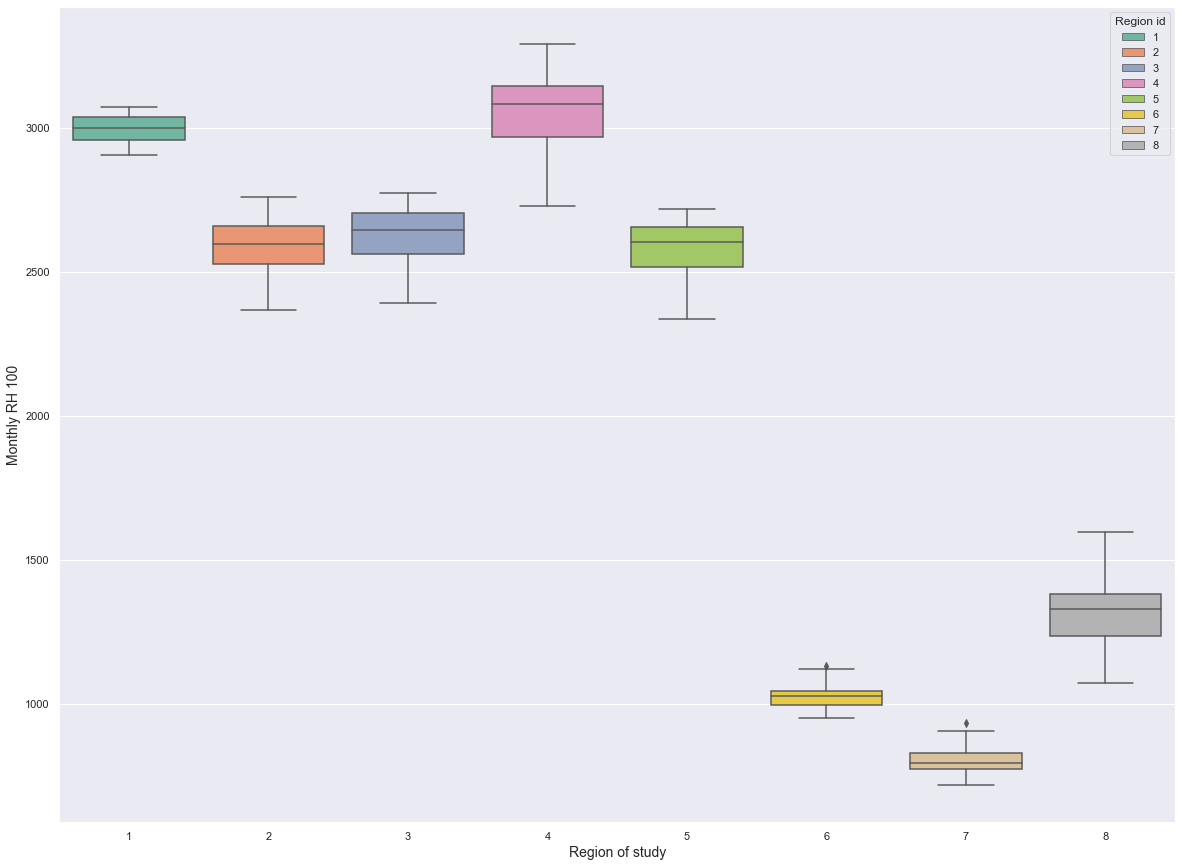

In [23]:
# Mean monthly RH100 - canopy height.
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
graph = sns.boxplot(gedi, x='polygon_id', y='rh100', palette=palette, ax=ax, hue='polygon_id', dodge=False)
graph.set_ylabel("Monthly RH 100",fontsize=14)
graph.set_xlabel("Region of study",fontsize=14)
sns.move_legend(graph, "upper right", title="Region id")

/var/folders/2q/26zyw9sd5cldkn81_ymfw6dh0000gn/T/ipykernel_45760/1345014200.py:3: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  graph = sns.scatterplot(gedi[gedi.polygon_id < 6], x='pai', y='rh100', palette=palette, ax=ax, hue='polygon_id', s=93)


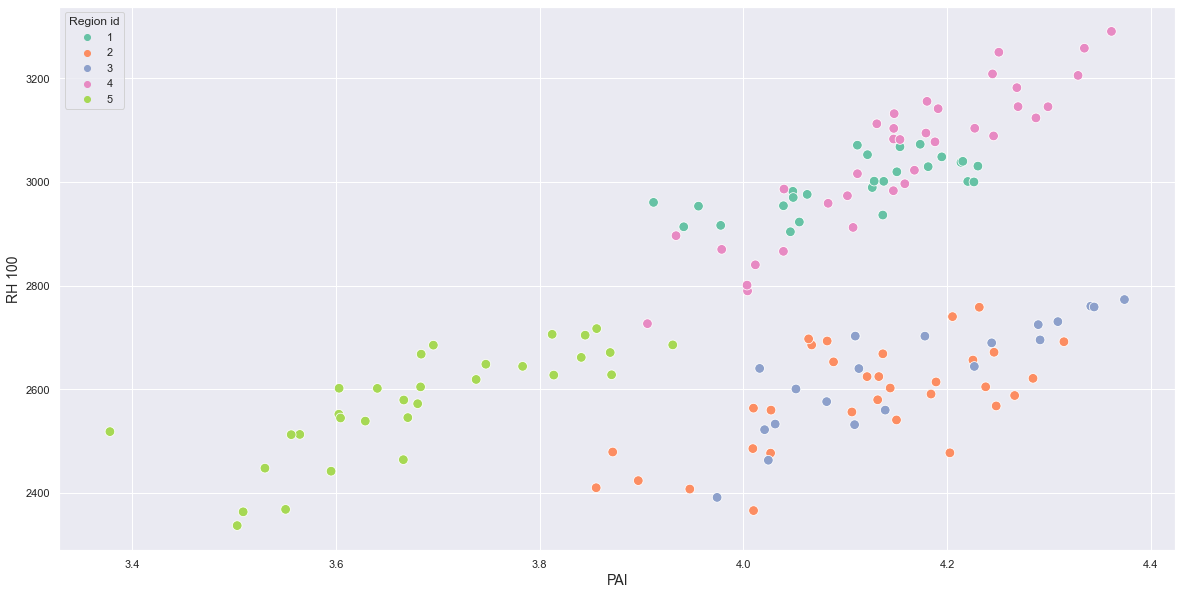

In [25]:
# Monthly PAI vs. RH100 as a scatterplot for Amazon regions.
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
graph = sns.scatterplot(gedi[gedi.polygon_id < 6], x='pai', y='rh100', palette=palette, ax=ax, hue='polygon_id', s=93)
graph.set_ylabel("RH 100",fontsize=14)
graph.set_xlabel("PAI",fontsize=14)
sns.move_legend(graph, "upper left", title="Region id")

Interestingly, we see clear clustering - where regions 1 and 4 are grouped having higher vegetation heights than polygons 2 and 3, but all four polygons have high PAI values. Polygon 5 has shorter canopy and lower PAI than the other four regions.

In [291]:
# Get gedi footprints
gedi_footprints = pipeline.get_extended_gedi_footprints()

### Seasonal rainfall and dry season

In [26]:
climate_int = interpolate.interpolate_using_linear(climate, ['precipitation', 'radiation', 'temperature', 'fpar', 'PET', 'P-PET'])
climate_int['datetime'] = pd.to_datetime(climate_int.datetime)

In [27]:
def format_date(ax):
    for row in ax:
        for axis in row:
            #locator = mdates.AutoDateLocator(minticks=10, maxticks=17)
            locator = mdates.MonthLocator(bymonth=[1, 7])
            axis.xaxis.set_major_locator(locator) 
            axis.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
            x_axis = axis.axes.get_xaxis()
            x_axis.set_label_text('')

def format_date_long_ts(ax):
    for row in ax:
        for axis in row:
            #locator = mdates.AutoDateLocator(minticks=10, maxticks=17)
            locator = mdates.YearLocator()
            axis.xaxis.set_major_locator(locator) 
            axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
            x_axis = axis.axes.get_xaxis()
            x_axis.set_label_text('')

def draw_horizontal(ax):
    for row in ax:
        for axis in row:
            axis.axhline(y = 100, color='red', linestyle='dotted')

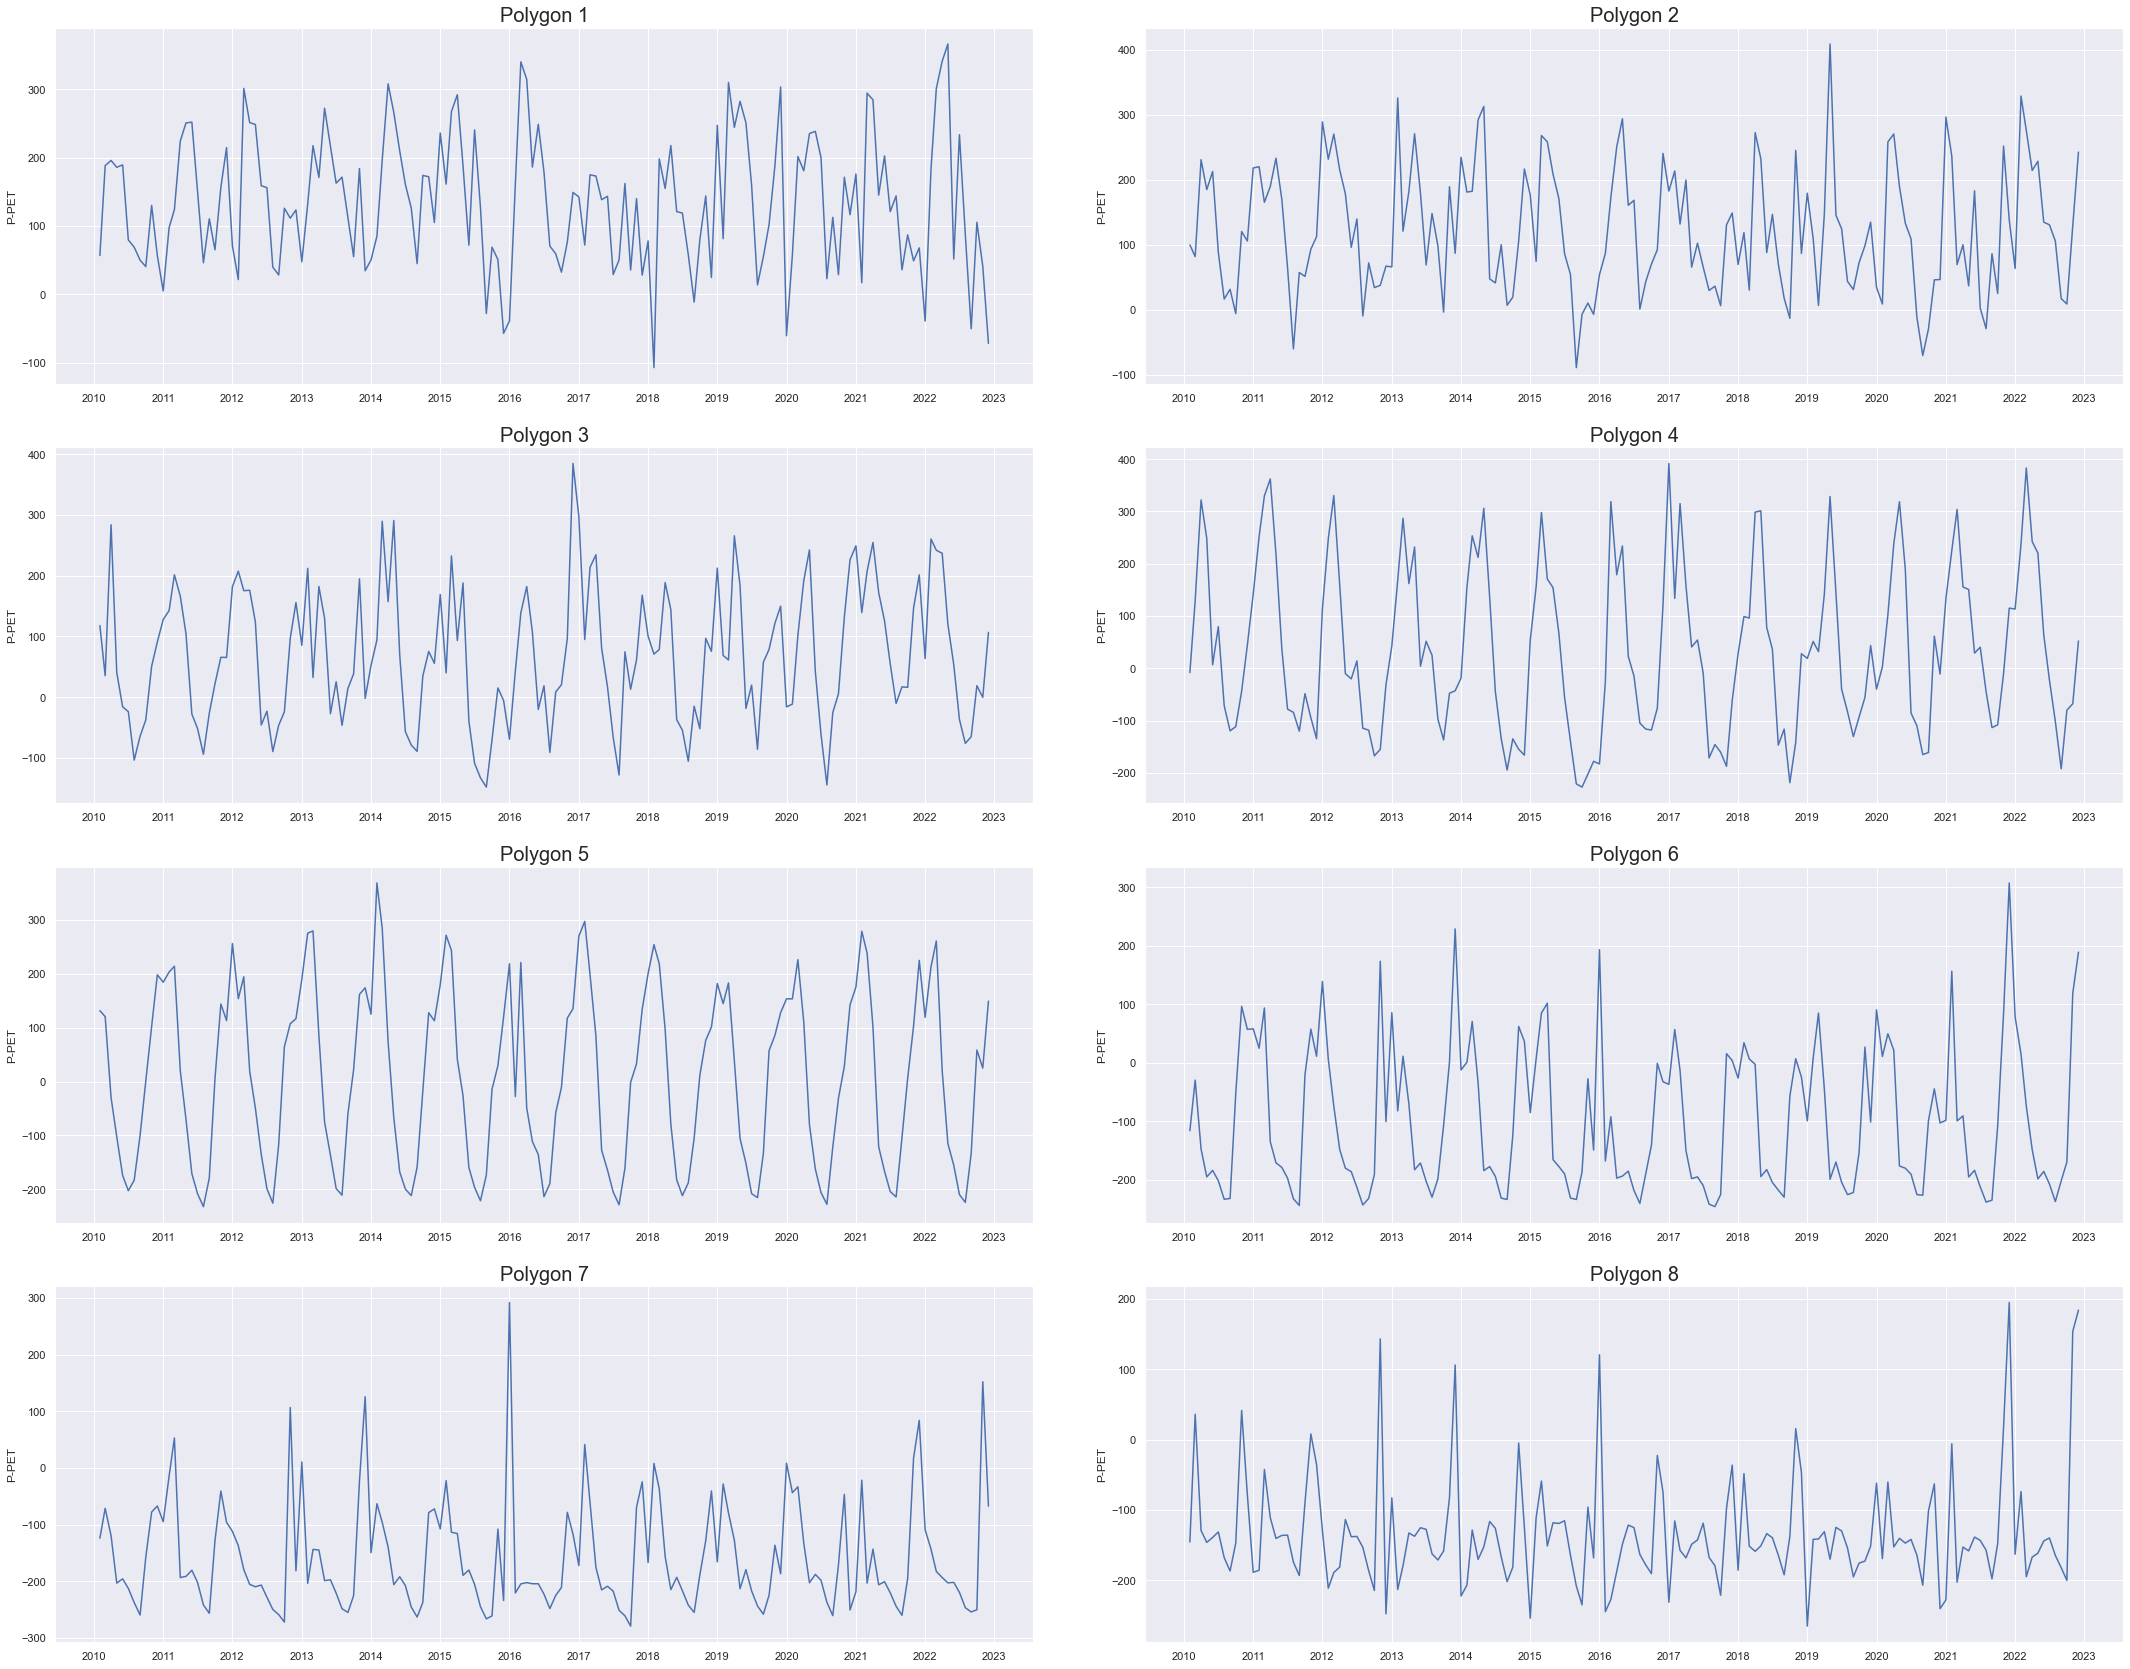

In [29]:
# Plot timeseries of water balance.
fig, ax = plot.plot_per_polygon(climate_int[climate_int.datetime > '2010-01-01'], "", lambda df, ax: sns.lineplot(df, x='datetime', y='P-PET', ax=ax))
format_date_long_ts(ax)

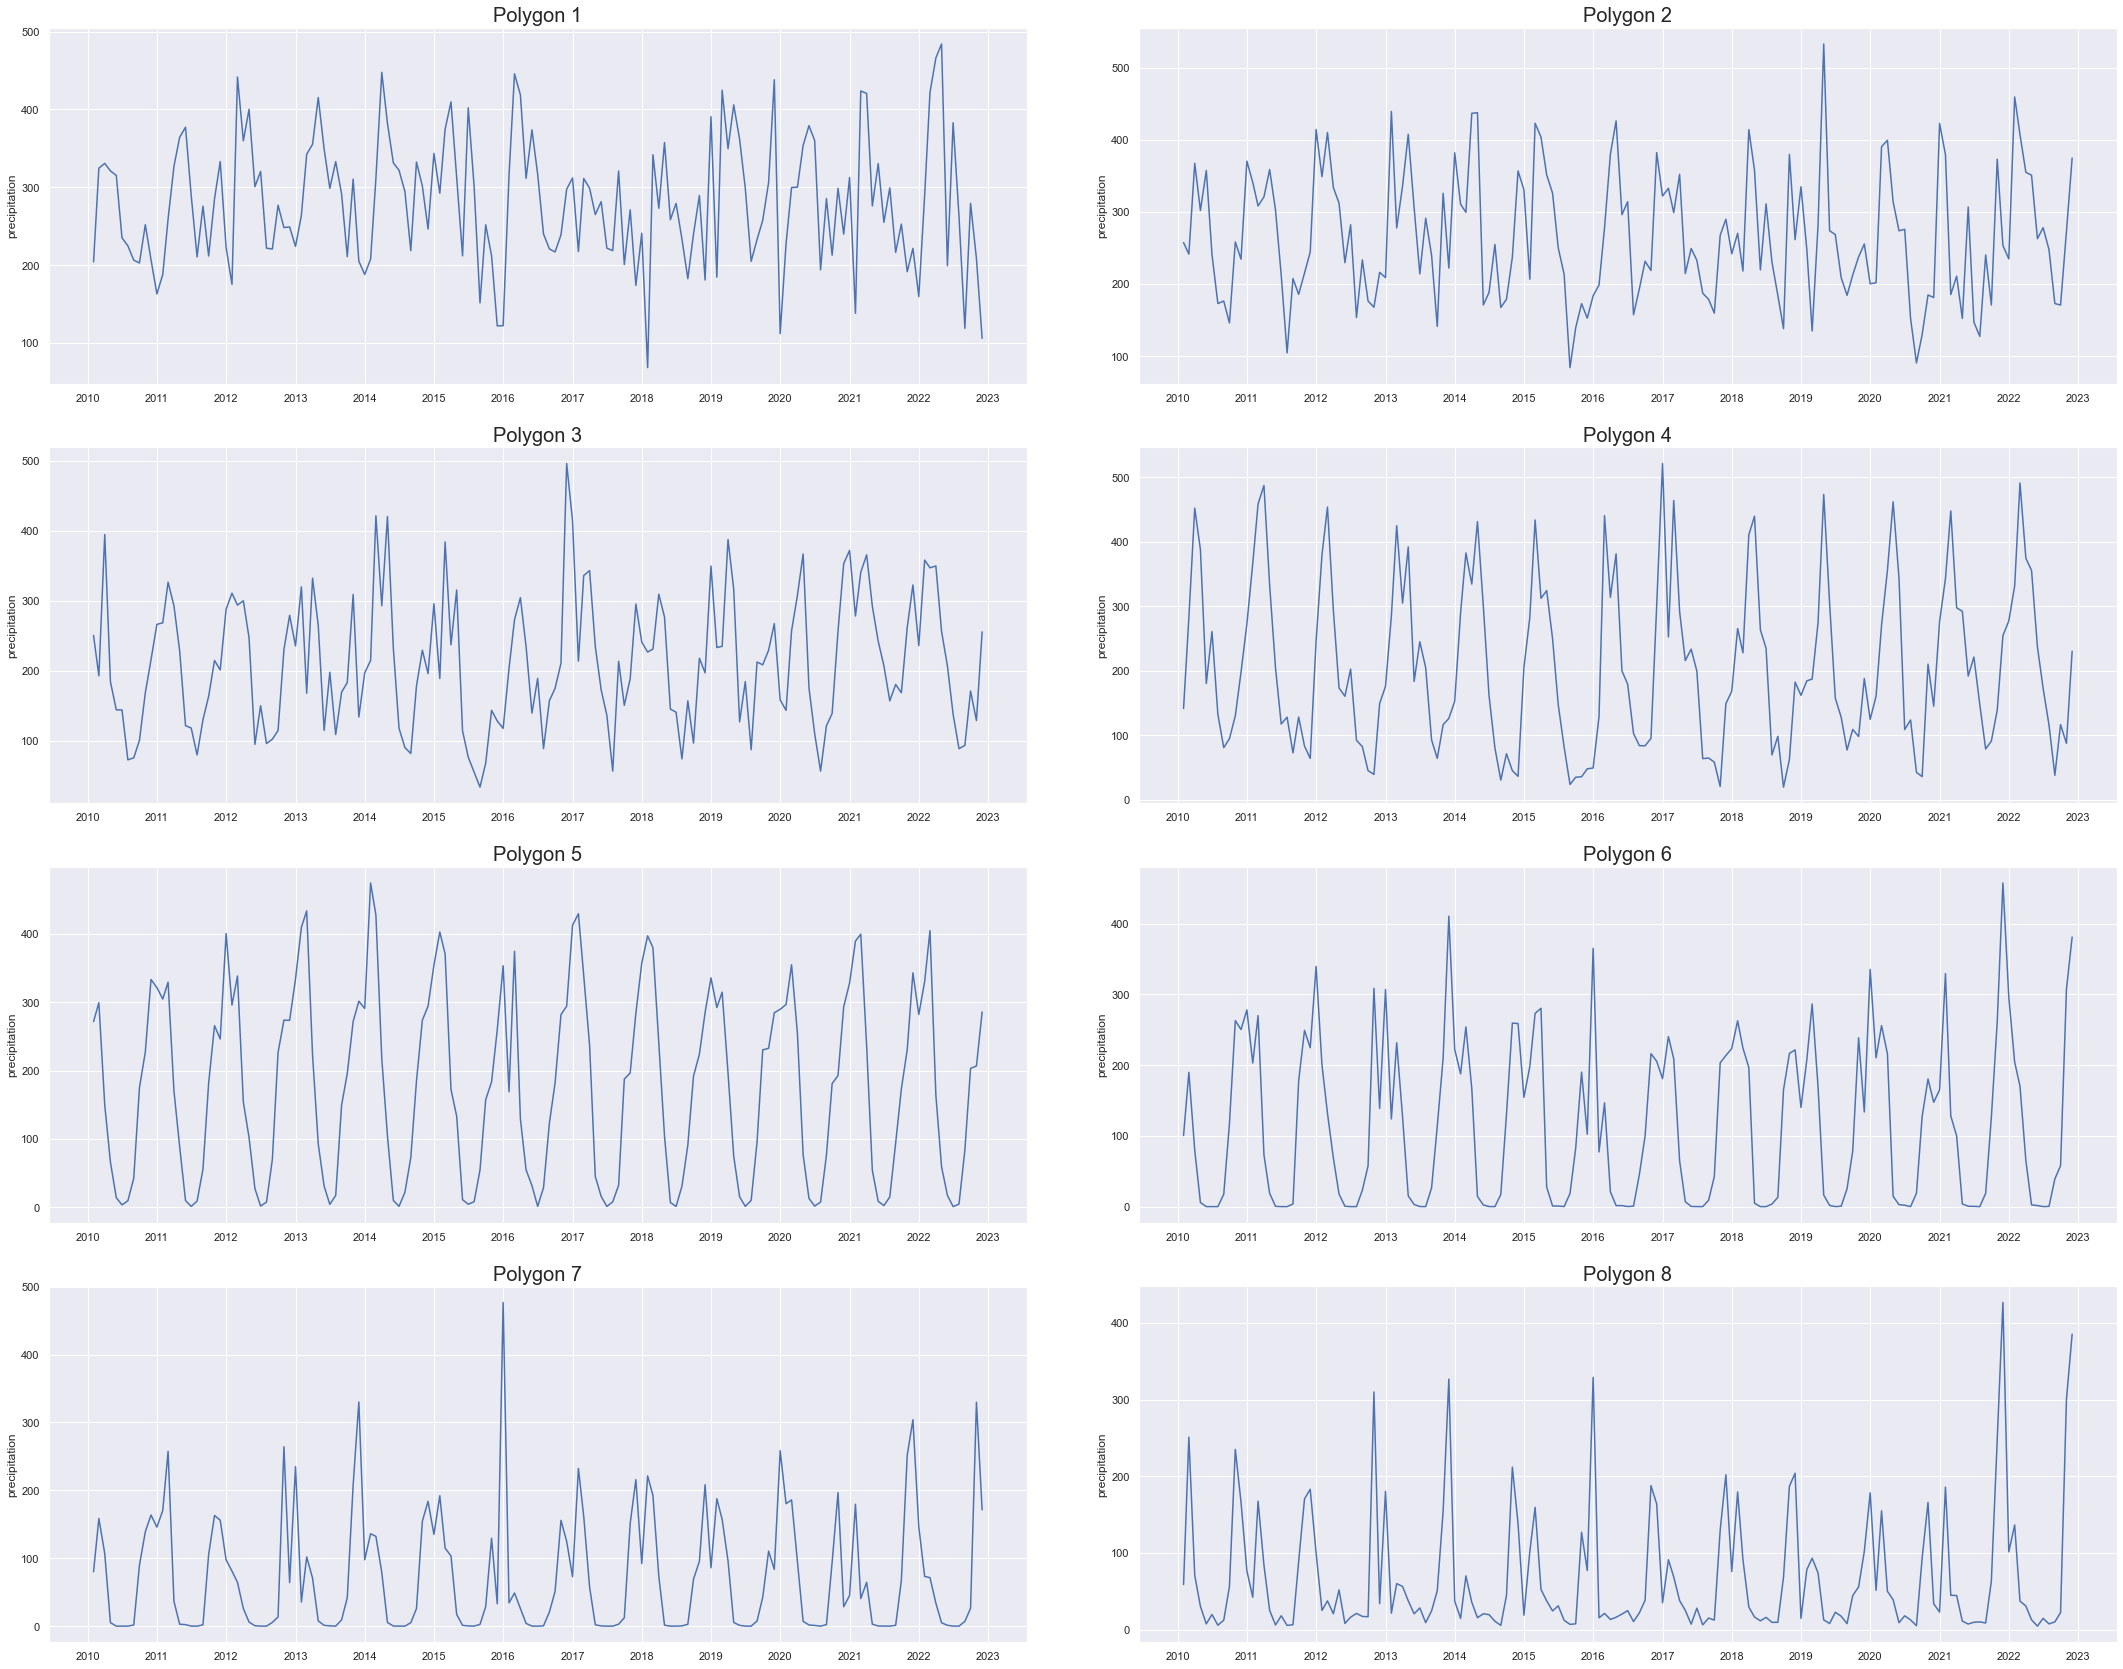

In [31]:
# Plot precipitation 12 year time series.
fig, ax = plot.plot_per_polygon(climate_int[climate_int.datetime > '2010-01-01'], "", lambda df, ax: sns.lineplot(df, x='datetime', y='precipitation', ax=ax))
format_date_long_ts(ax)

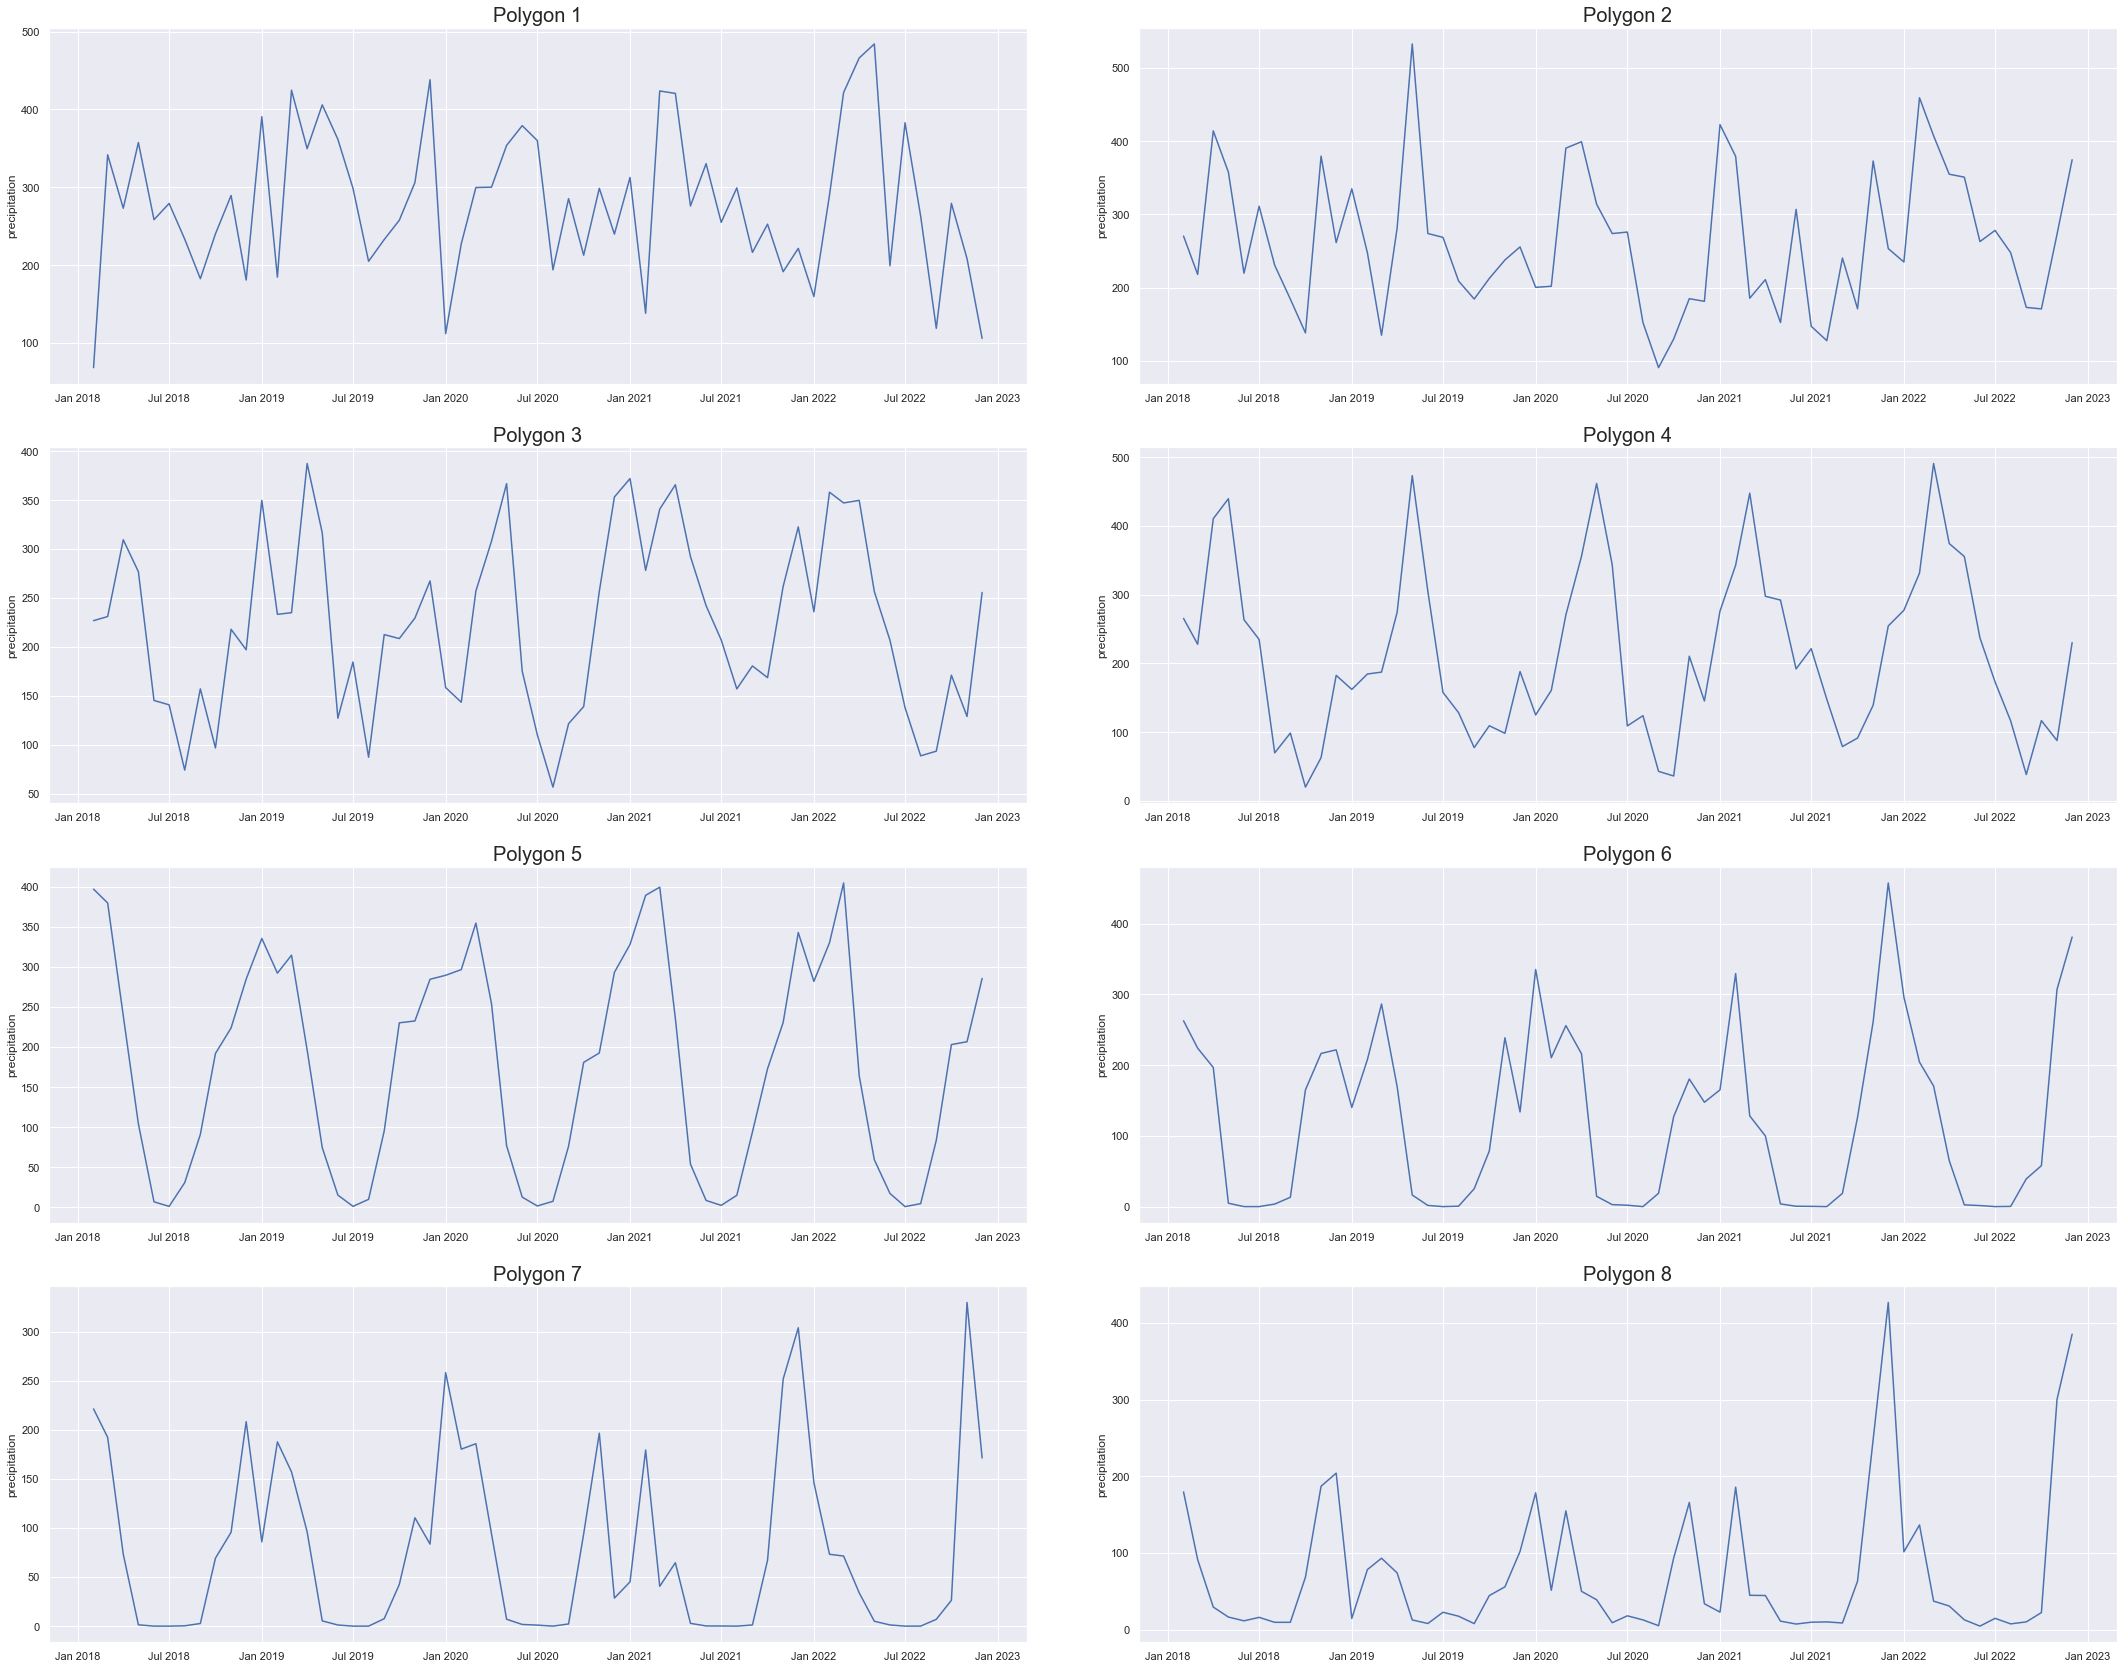

In [33]:
# Plot precipitation 4 year time series.
fig, ax = plot.plot_per_polygon(climate_int[climate_int.datetime > '2018-1-1'], "", lambda df, ax: sns.lineplot(df, x='datetime', y='precipitation', ax=ax))
format_date(ax)

In [35]:
climate_ts = climate_int[climate_int.datetime > '2010-01-01']
climate_seasonal = seasonal.get_ts_seasonal_component_per_polygon(climate_ts, climate_ts.datetime.min(), climate_ts.datetime.max(), columns=climate_columns)

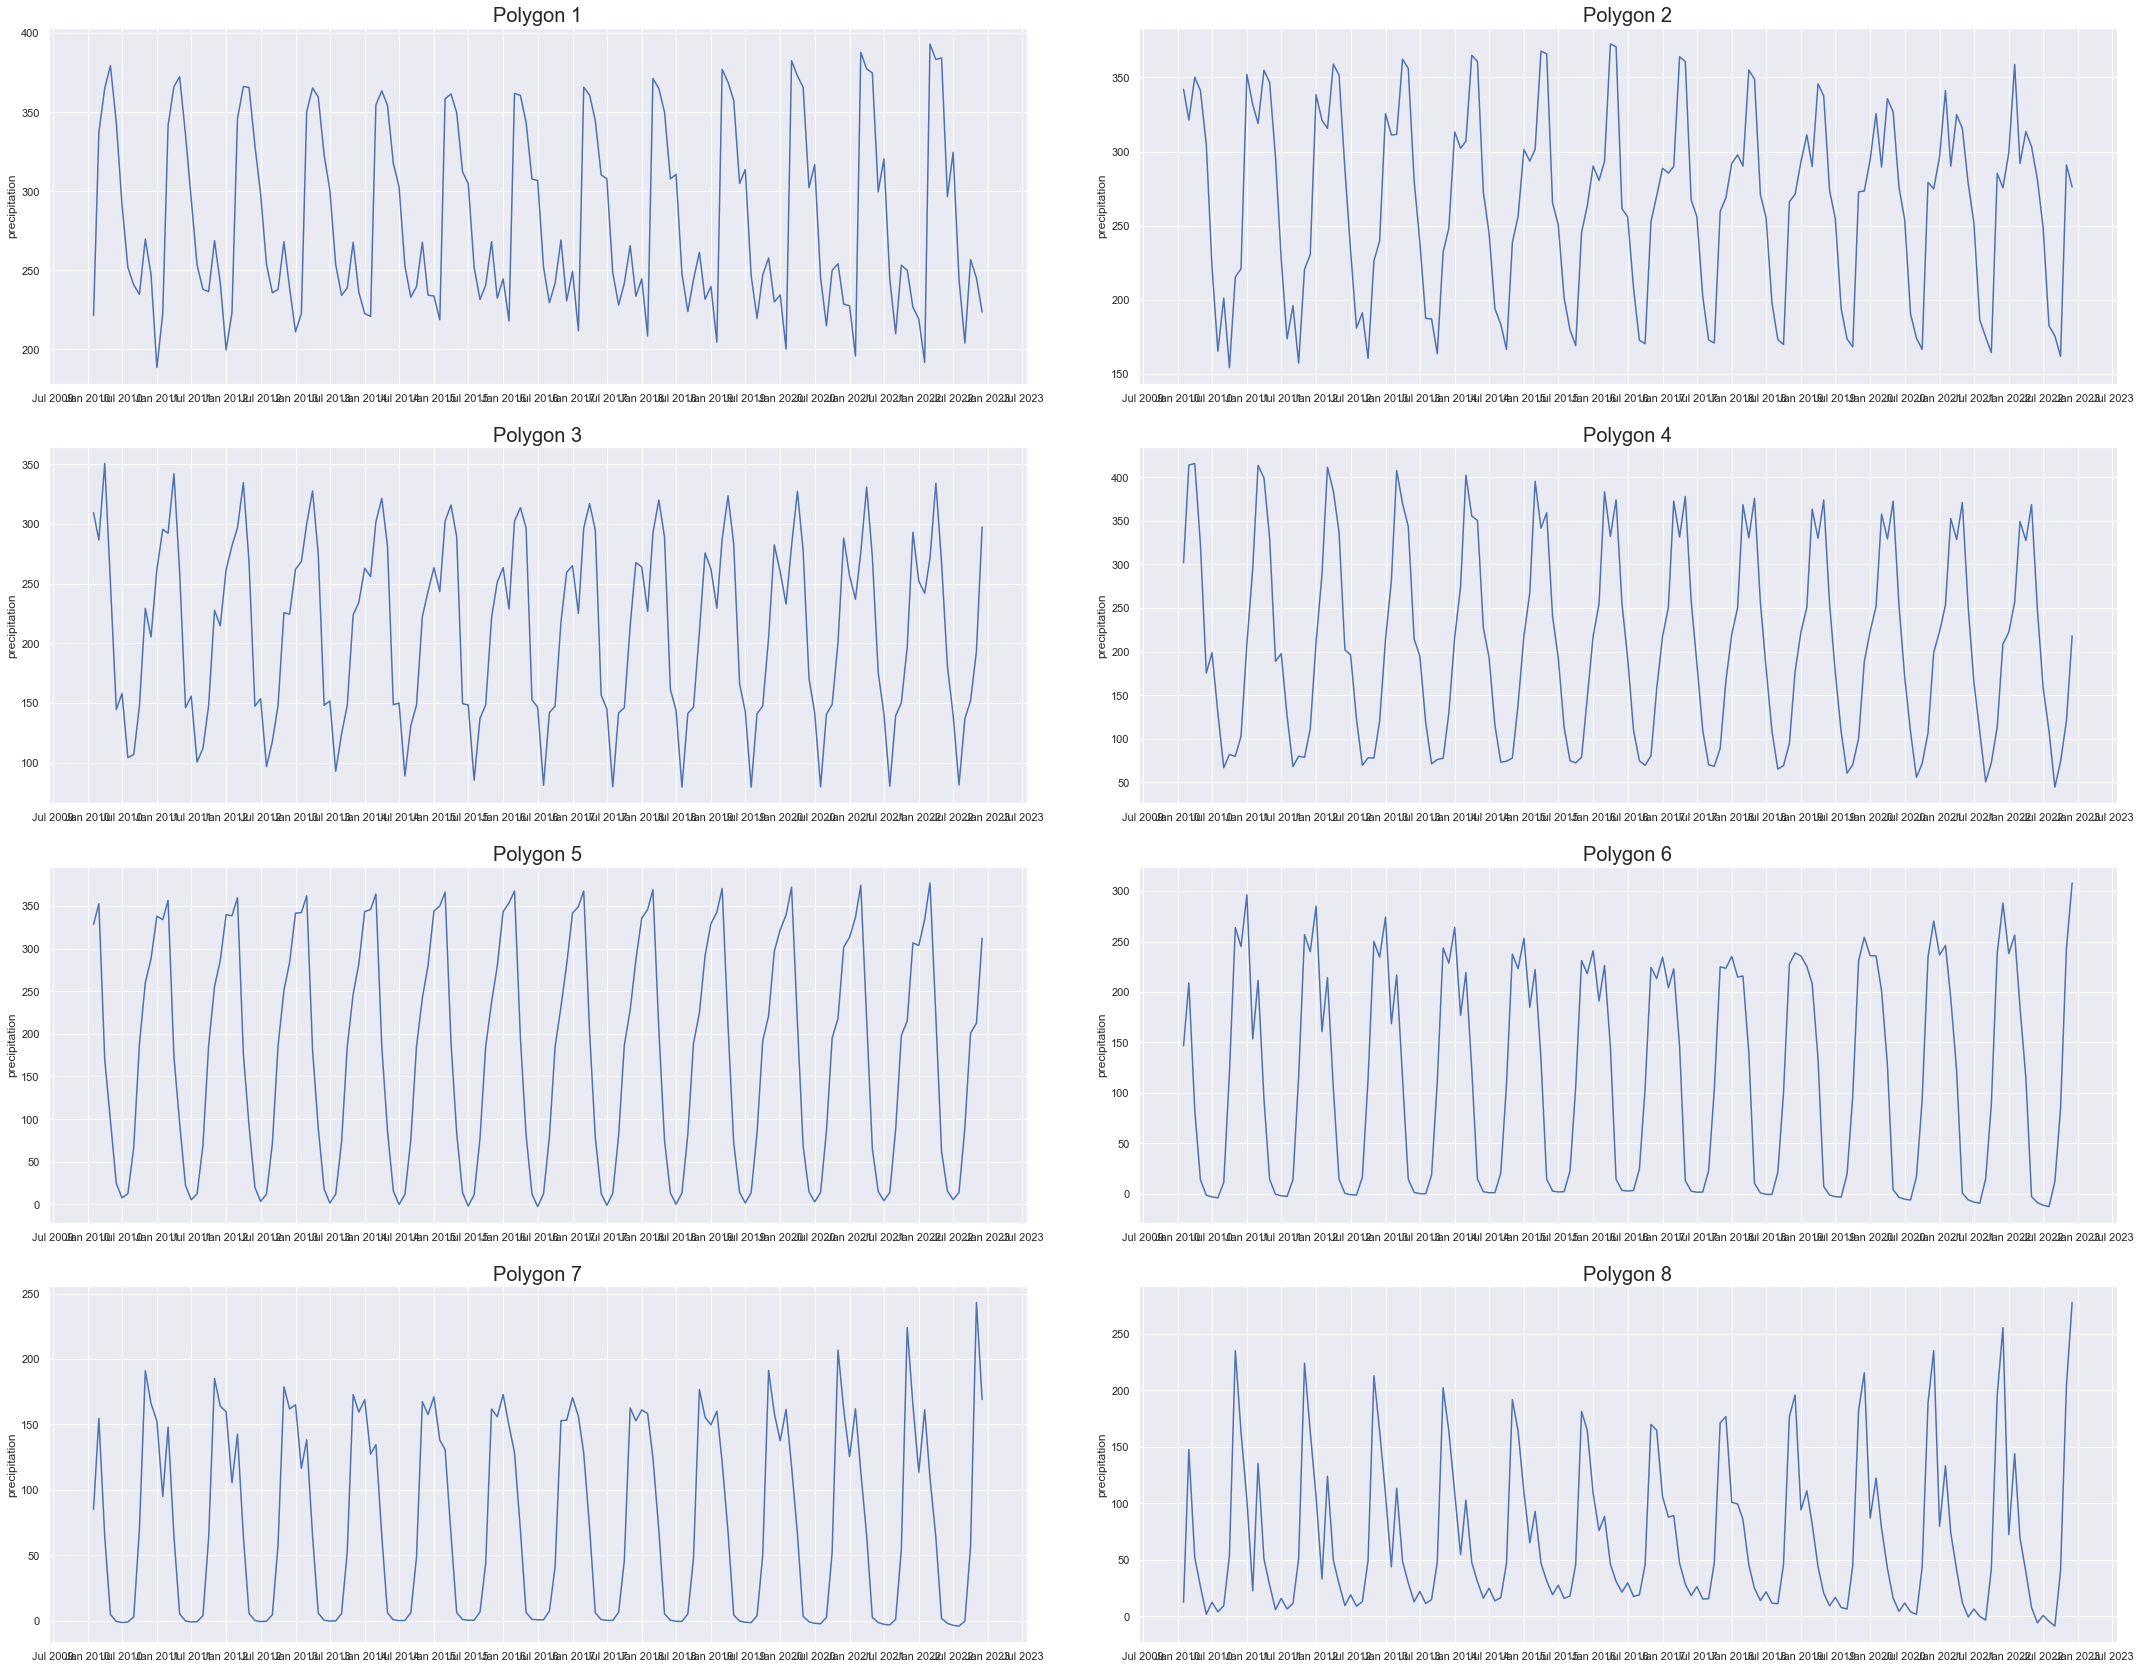

In [36]:
# Plot precipitation seasonal component.
fig, ax = plot.plot_per_polygon(climate_seasonal, "", lambda df, ax: sns.lineplot(df, x='datetime', y='precipitation', ax=ax))
format_date(ax)

In [37]:
climate_ts_short = climate_int[climate_int.datetime > '2019-01-01']
climate_seasonal_short = seasonal.get_ts_seasonal_component_per_polygon(climate_ts_short, climate_ts_short.datetime.min(), climate_ts_short.datetime.max(), columns=climate_columns)

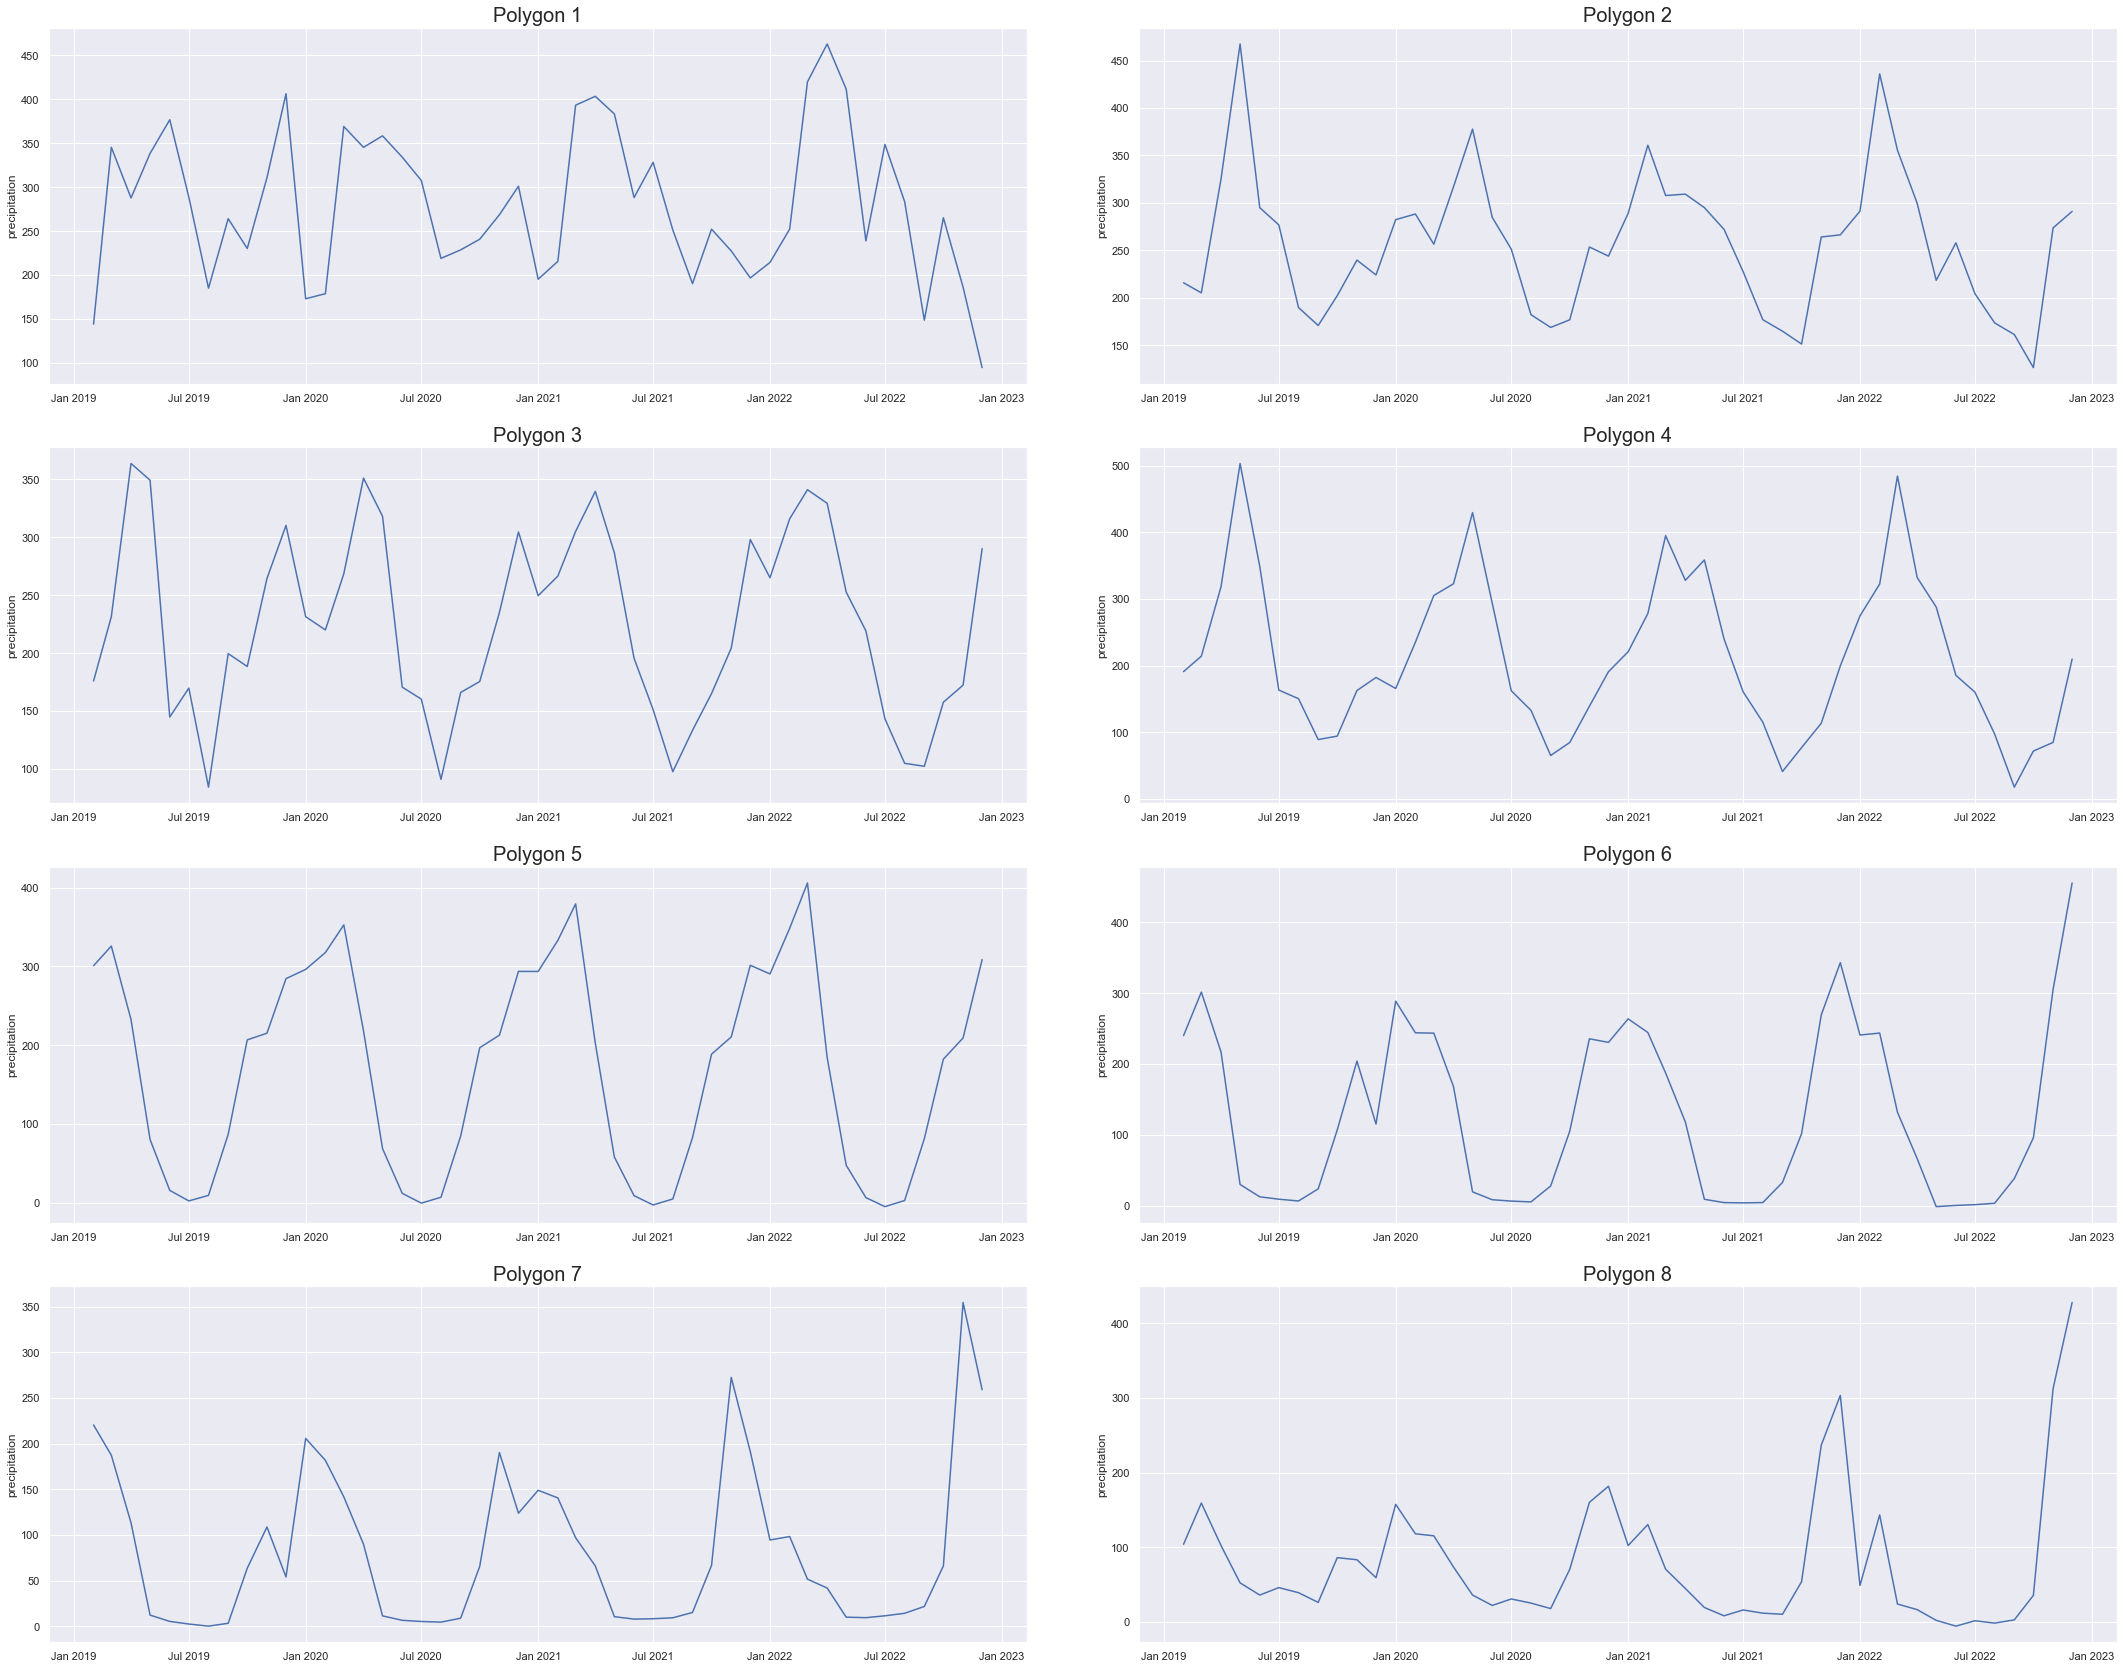

In [38]:
# Plot precipitation seasonal component for three year time series.
fig, ax = plot.plot_per_polygon(climate_seasonal_short, "", lambda df, ax: sns.lineplot(df, x='datetime', y='precipitation', ax=ax))
format_date(ax)

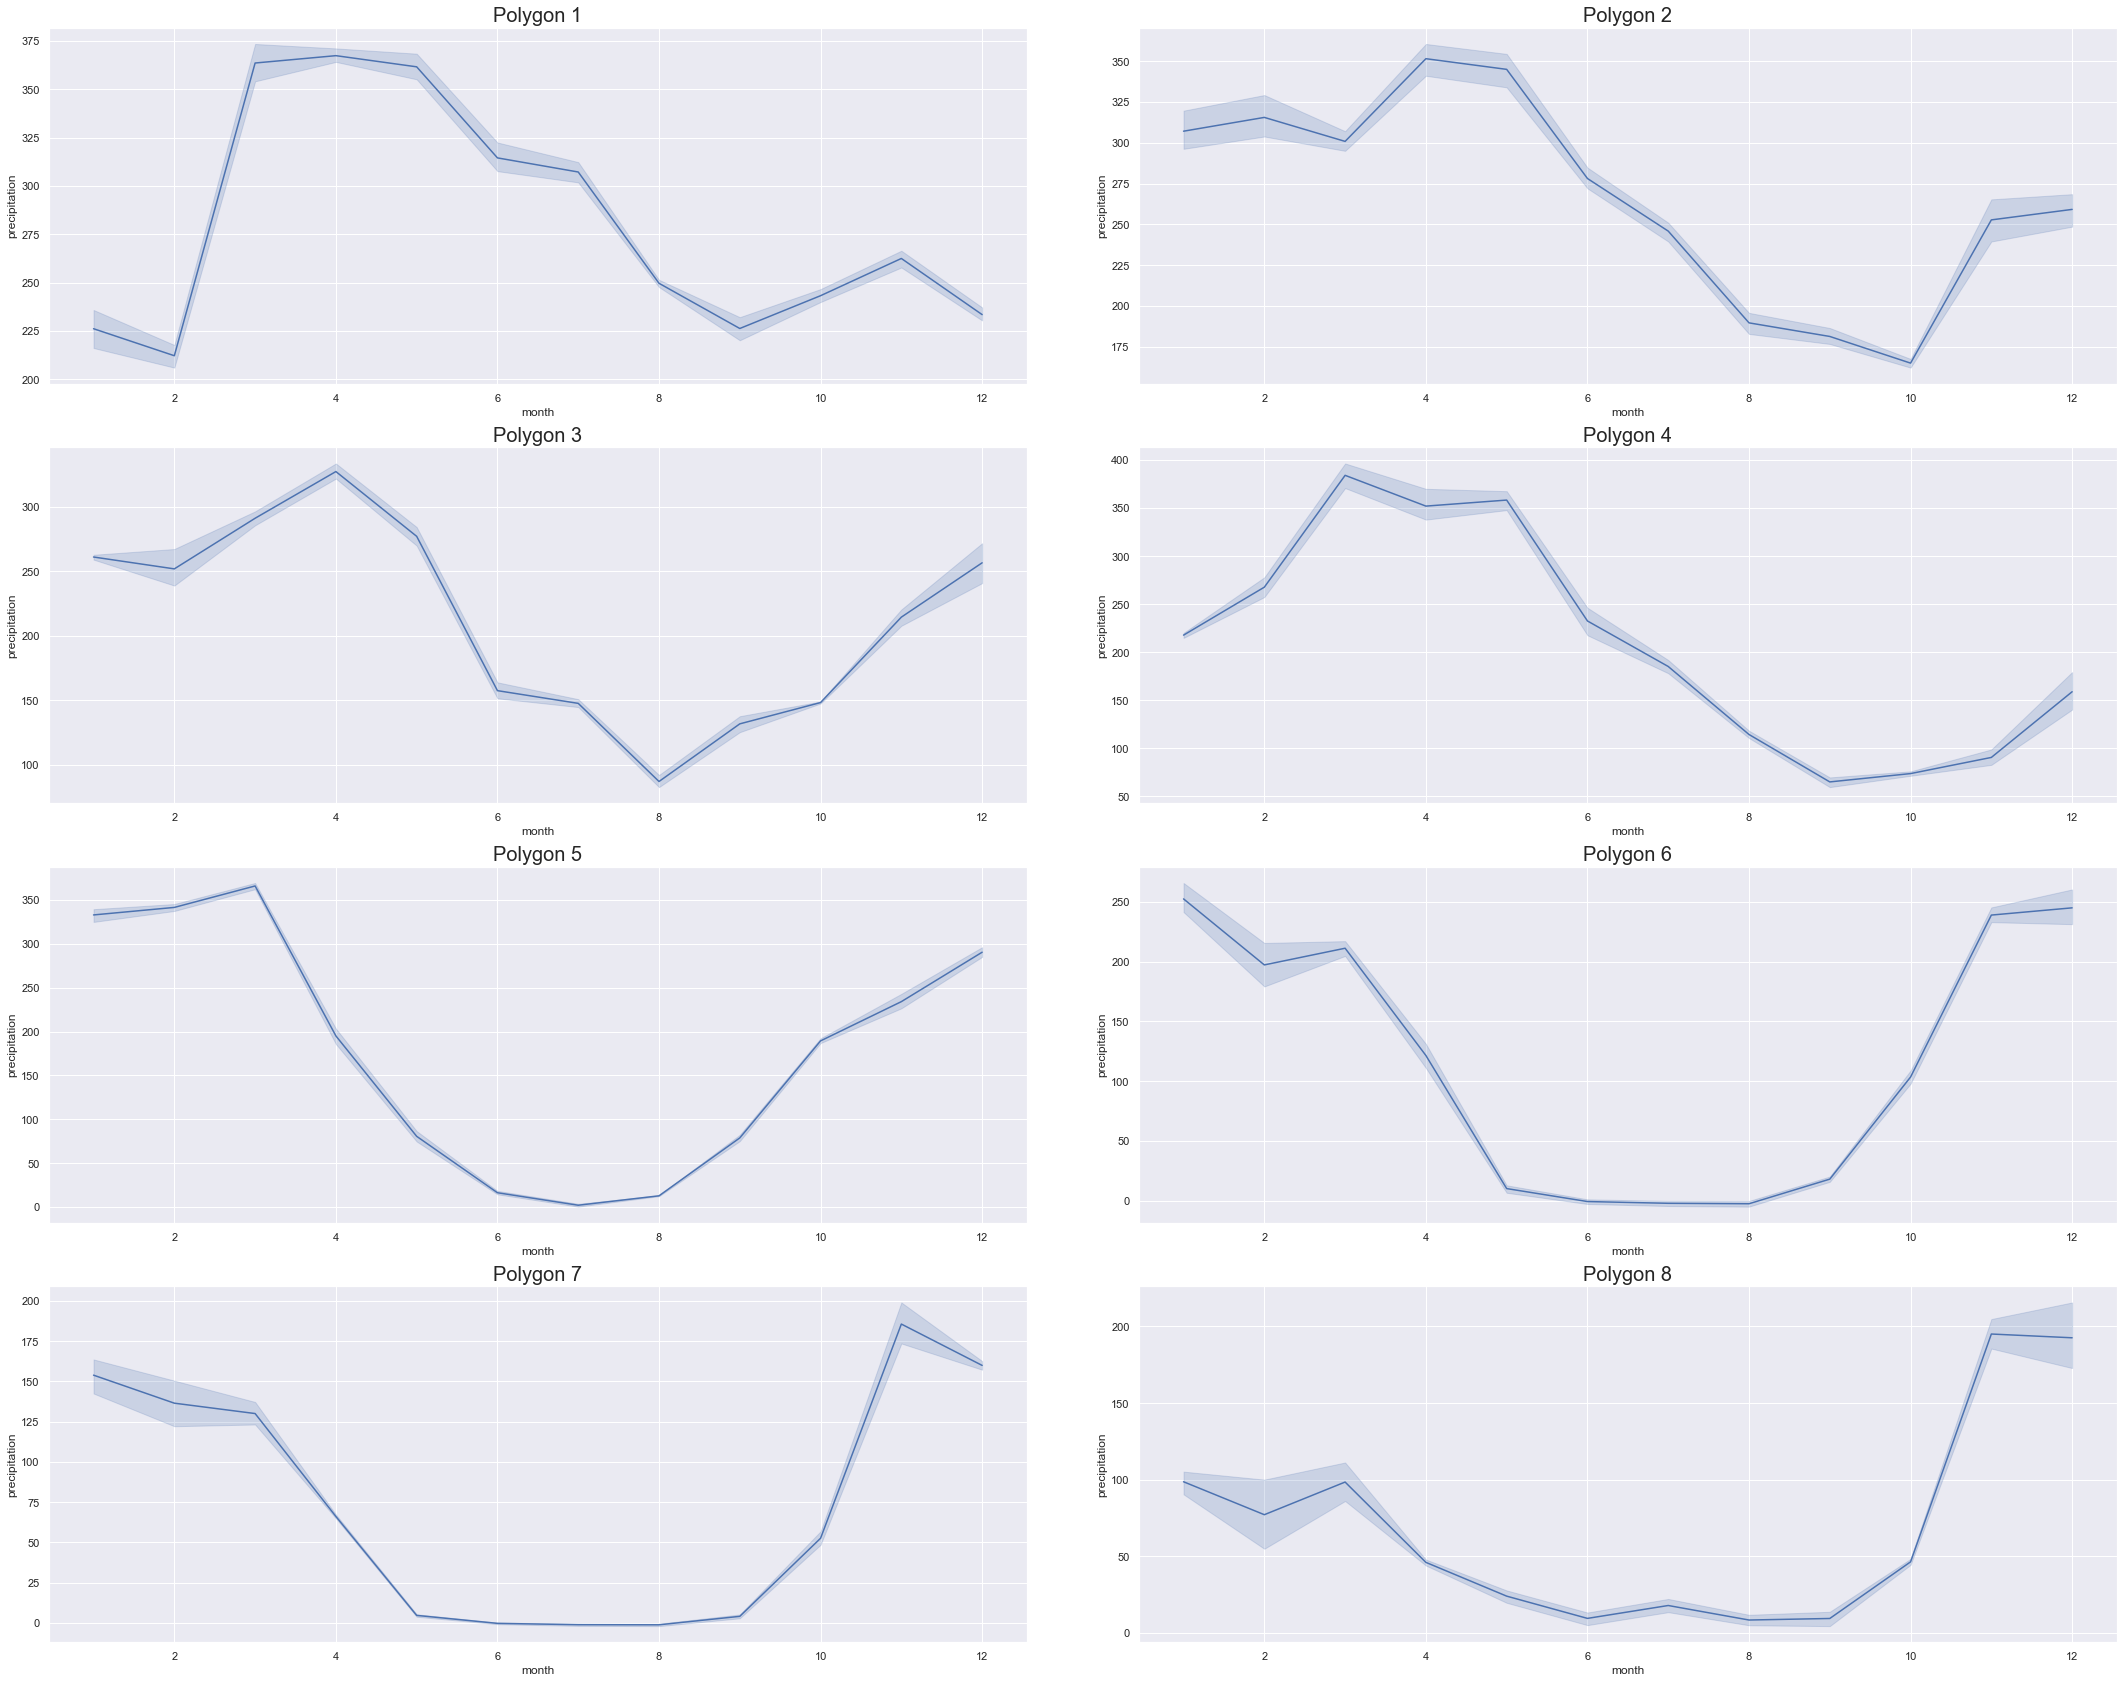

In [39]:
# Precipitation means per month of the year.
fig, ax = plot.plot_per_polygon(climate_seasonal, "", lambda df, ax: sns.lineplot(df, x='month', y='precipitation', ax=ax))

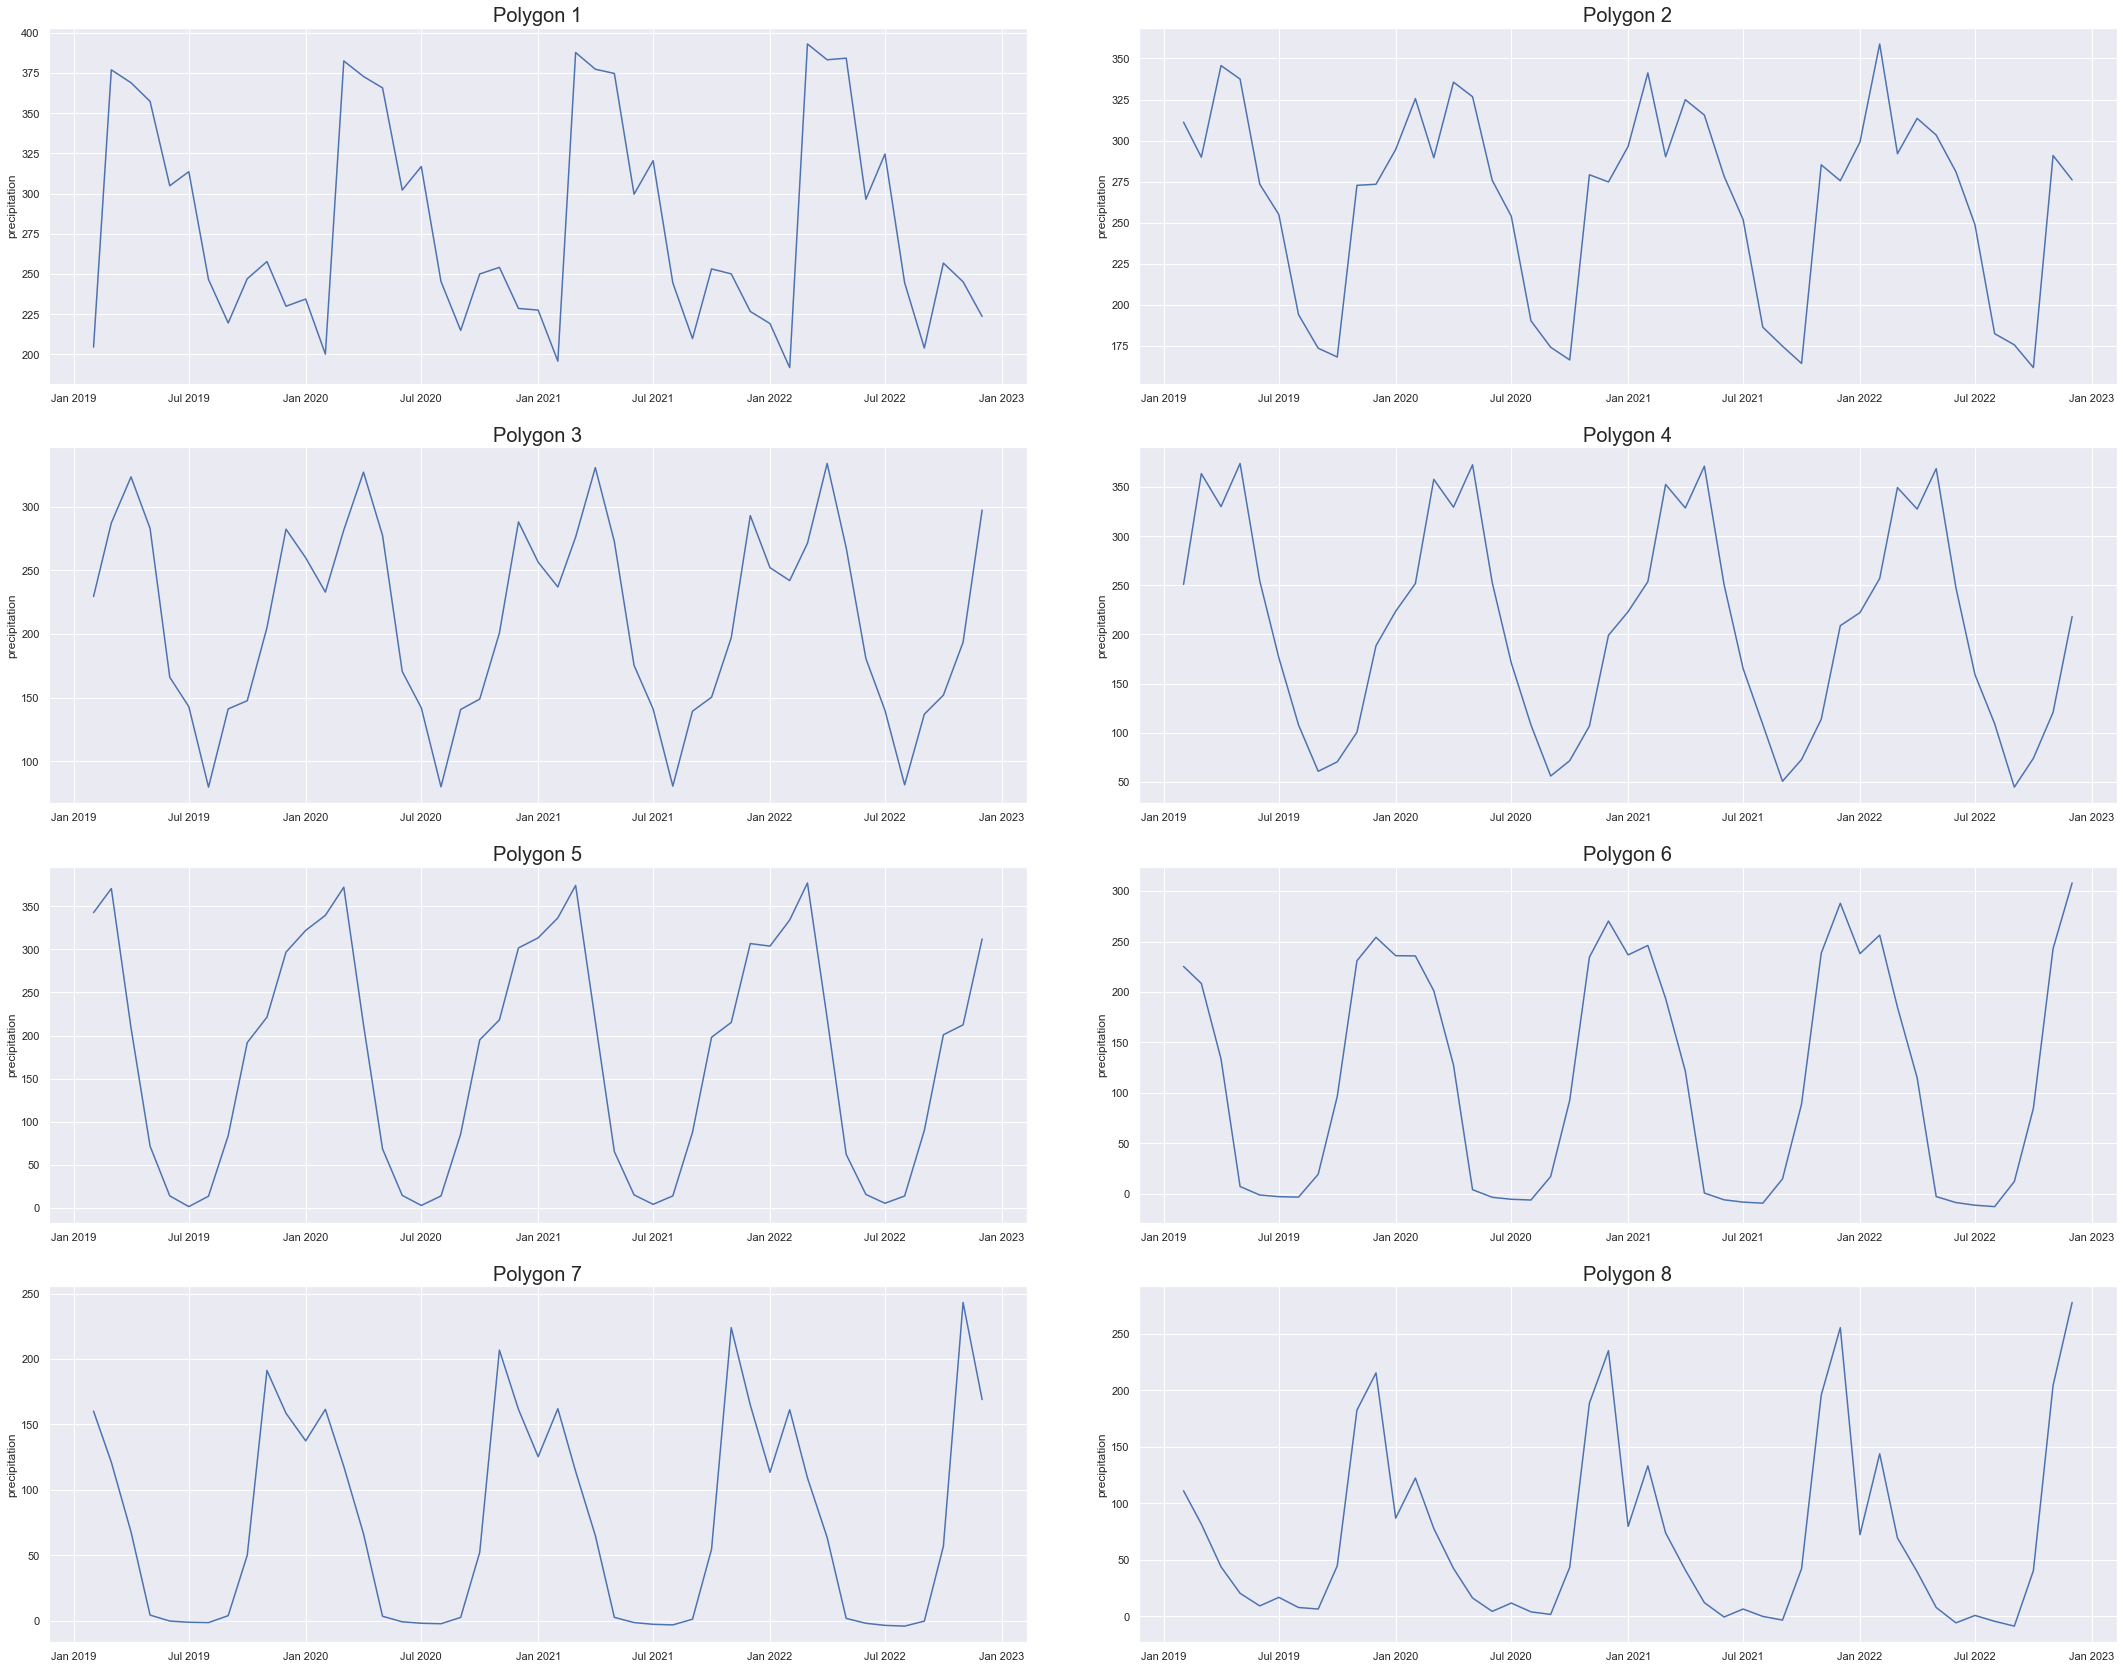

In [40]:
fig, ax = plot.plot_per_polygon(climate_seasonal[climate_seasonal.datetime > '2019-01-01'], "", lambda df, ax: sns.lineplot(df, x='datetime', y='precipitation', ax=ax))
format_date(ax)

### Let's determine the duration and timing of dry seasons

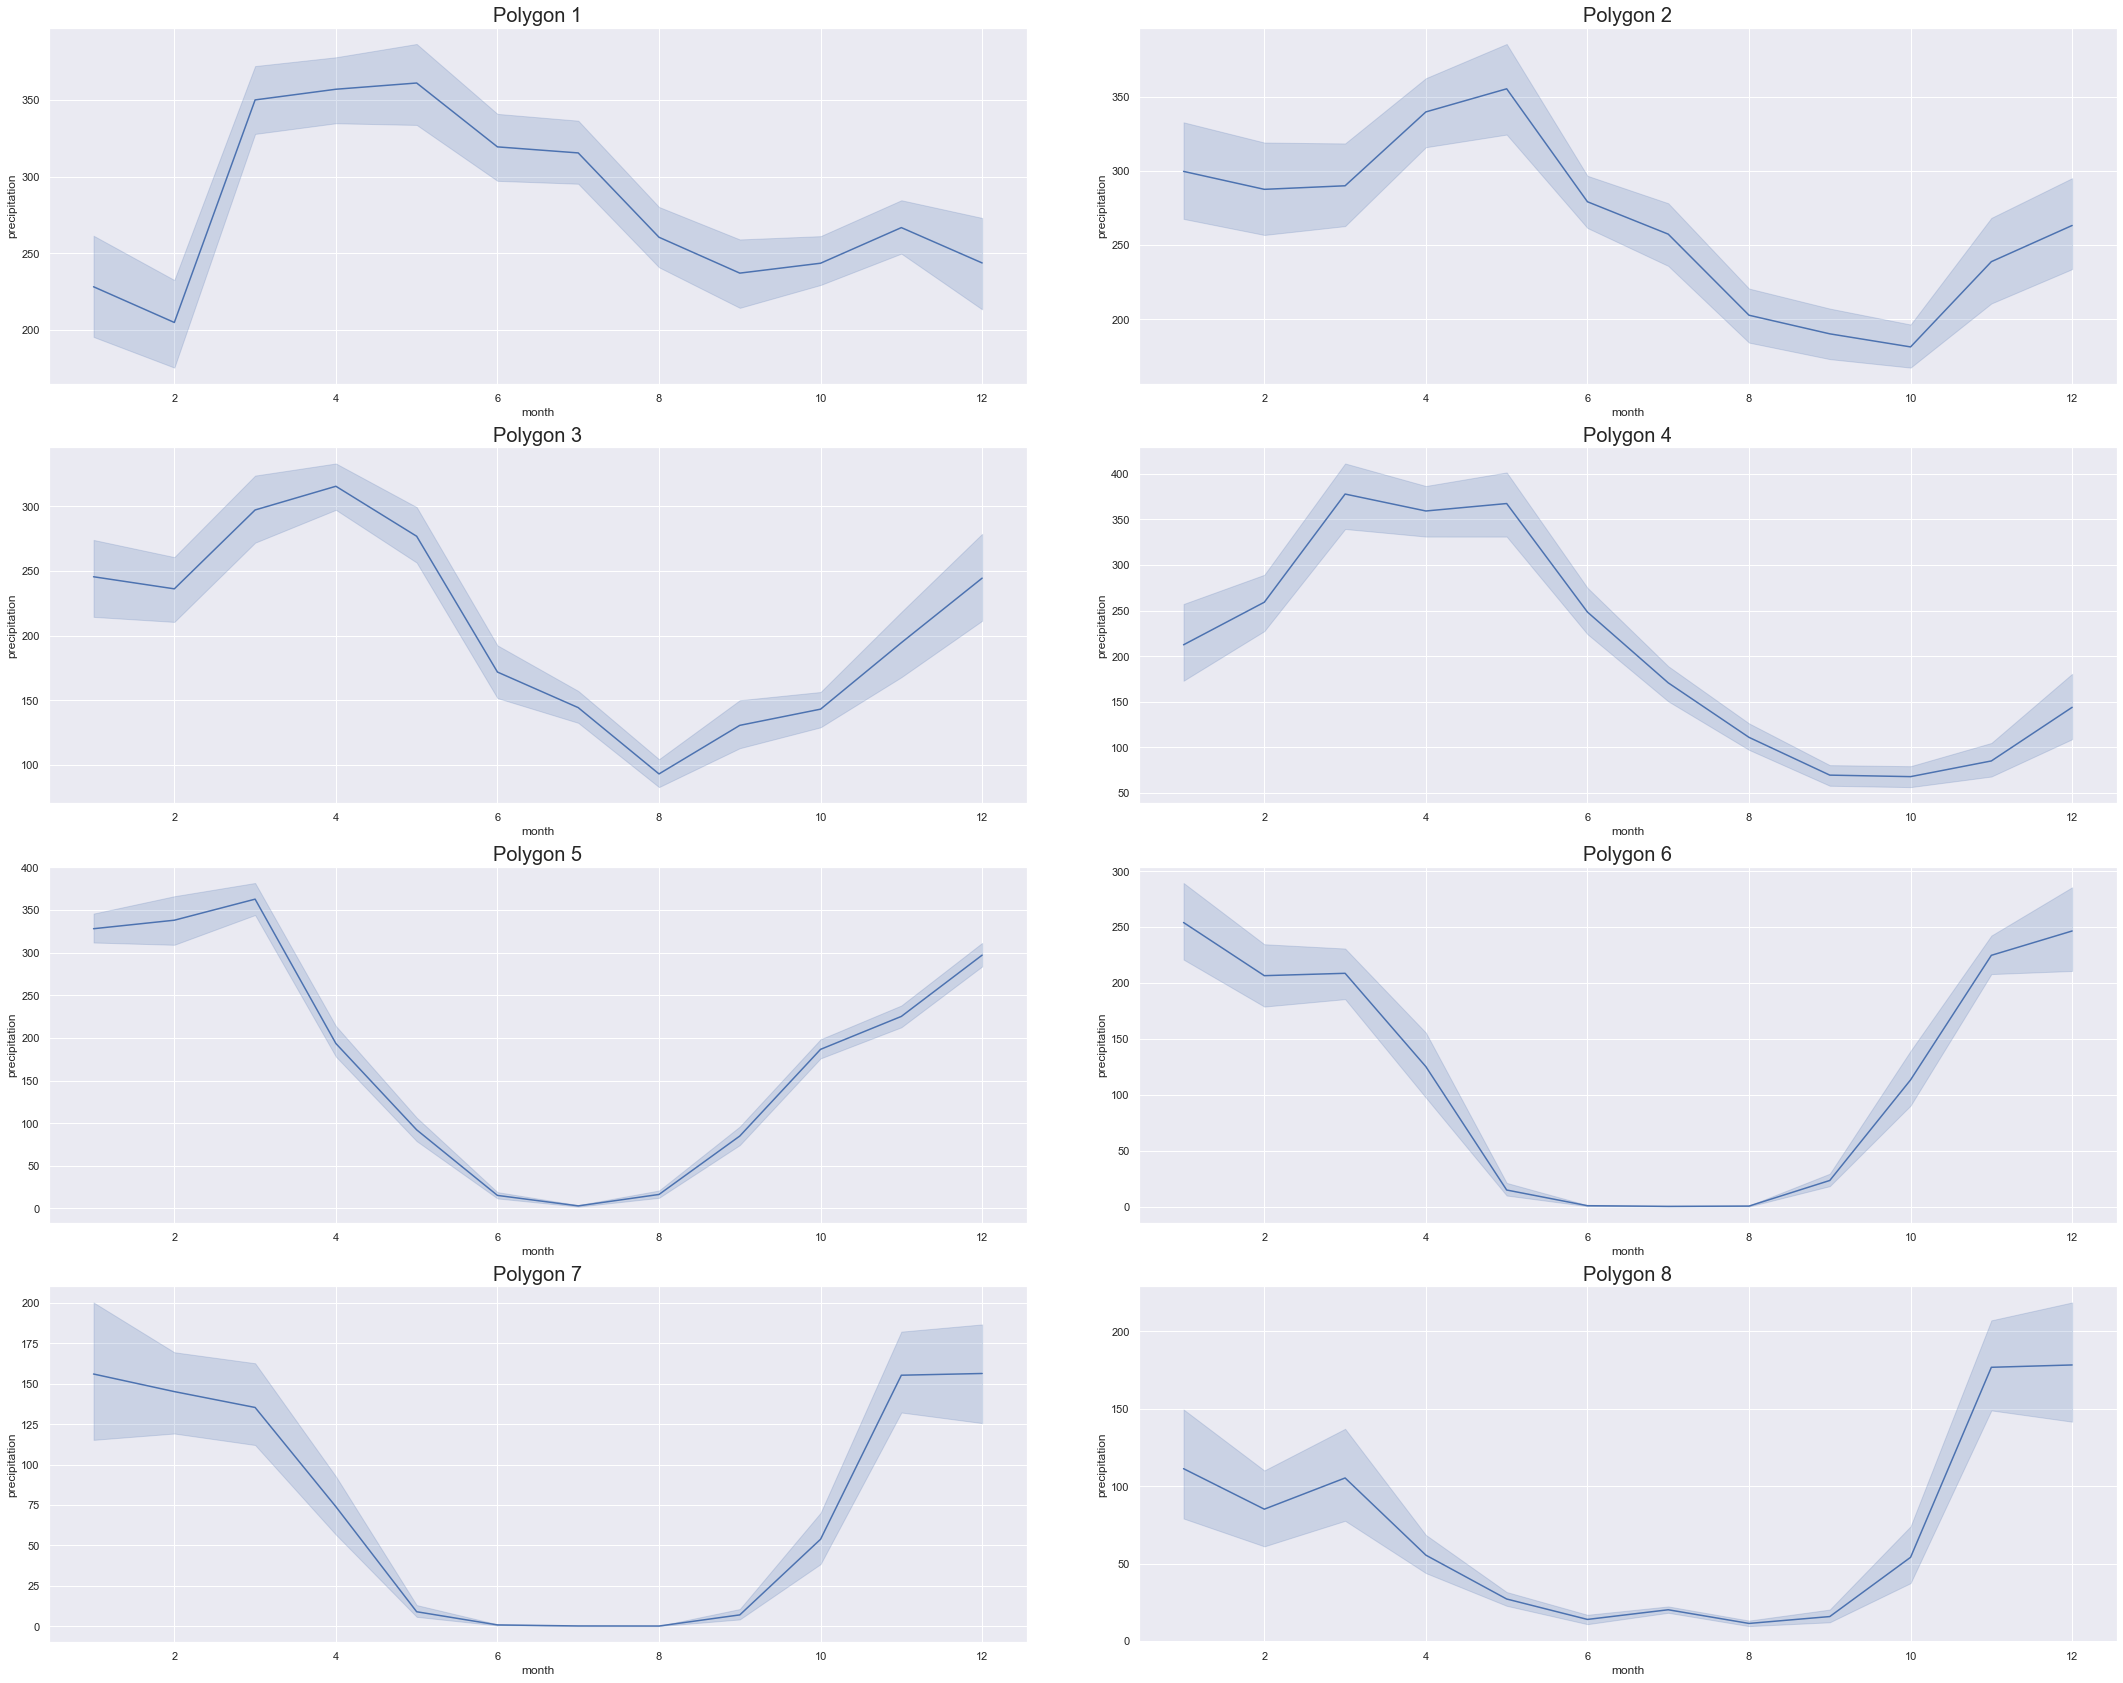

In [41]:
fig, ax = plot.plot_per_polygon(climate, "", lambda df, ax: sns.lineplot(df, x='month', y='precipitation', ax=ax))

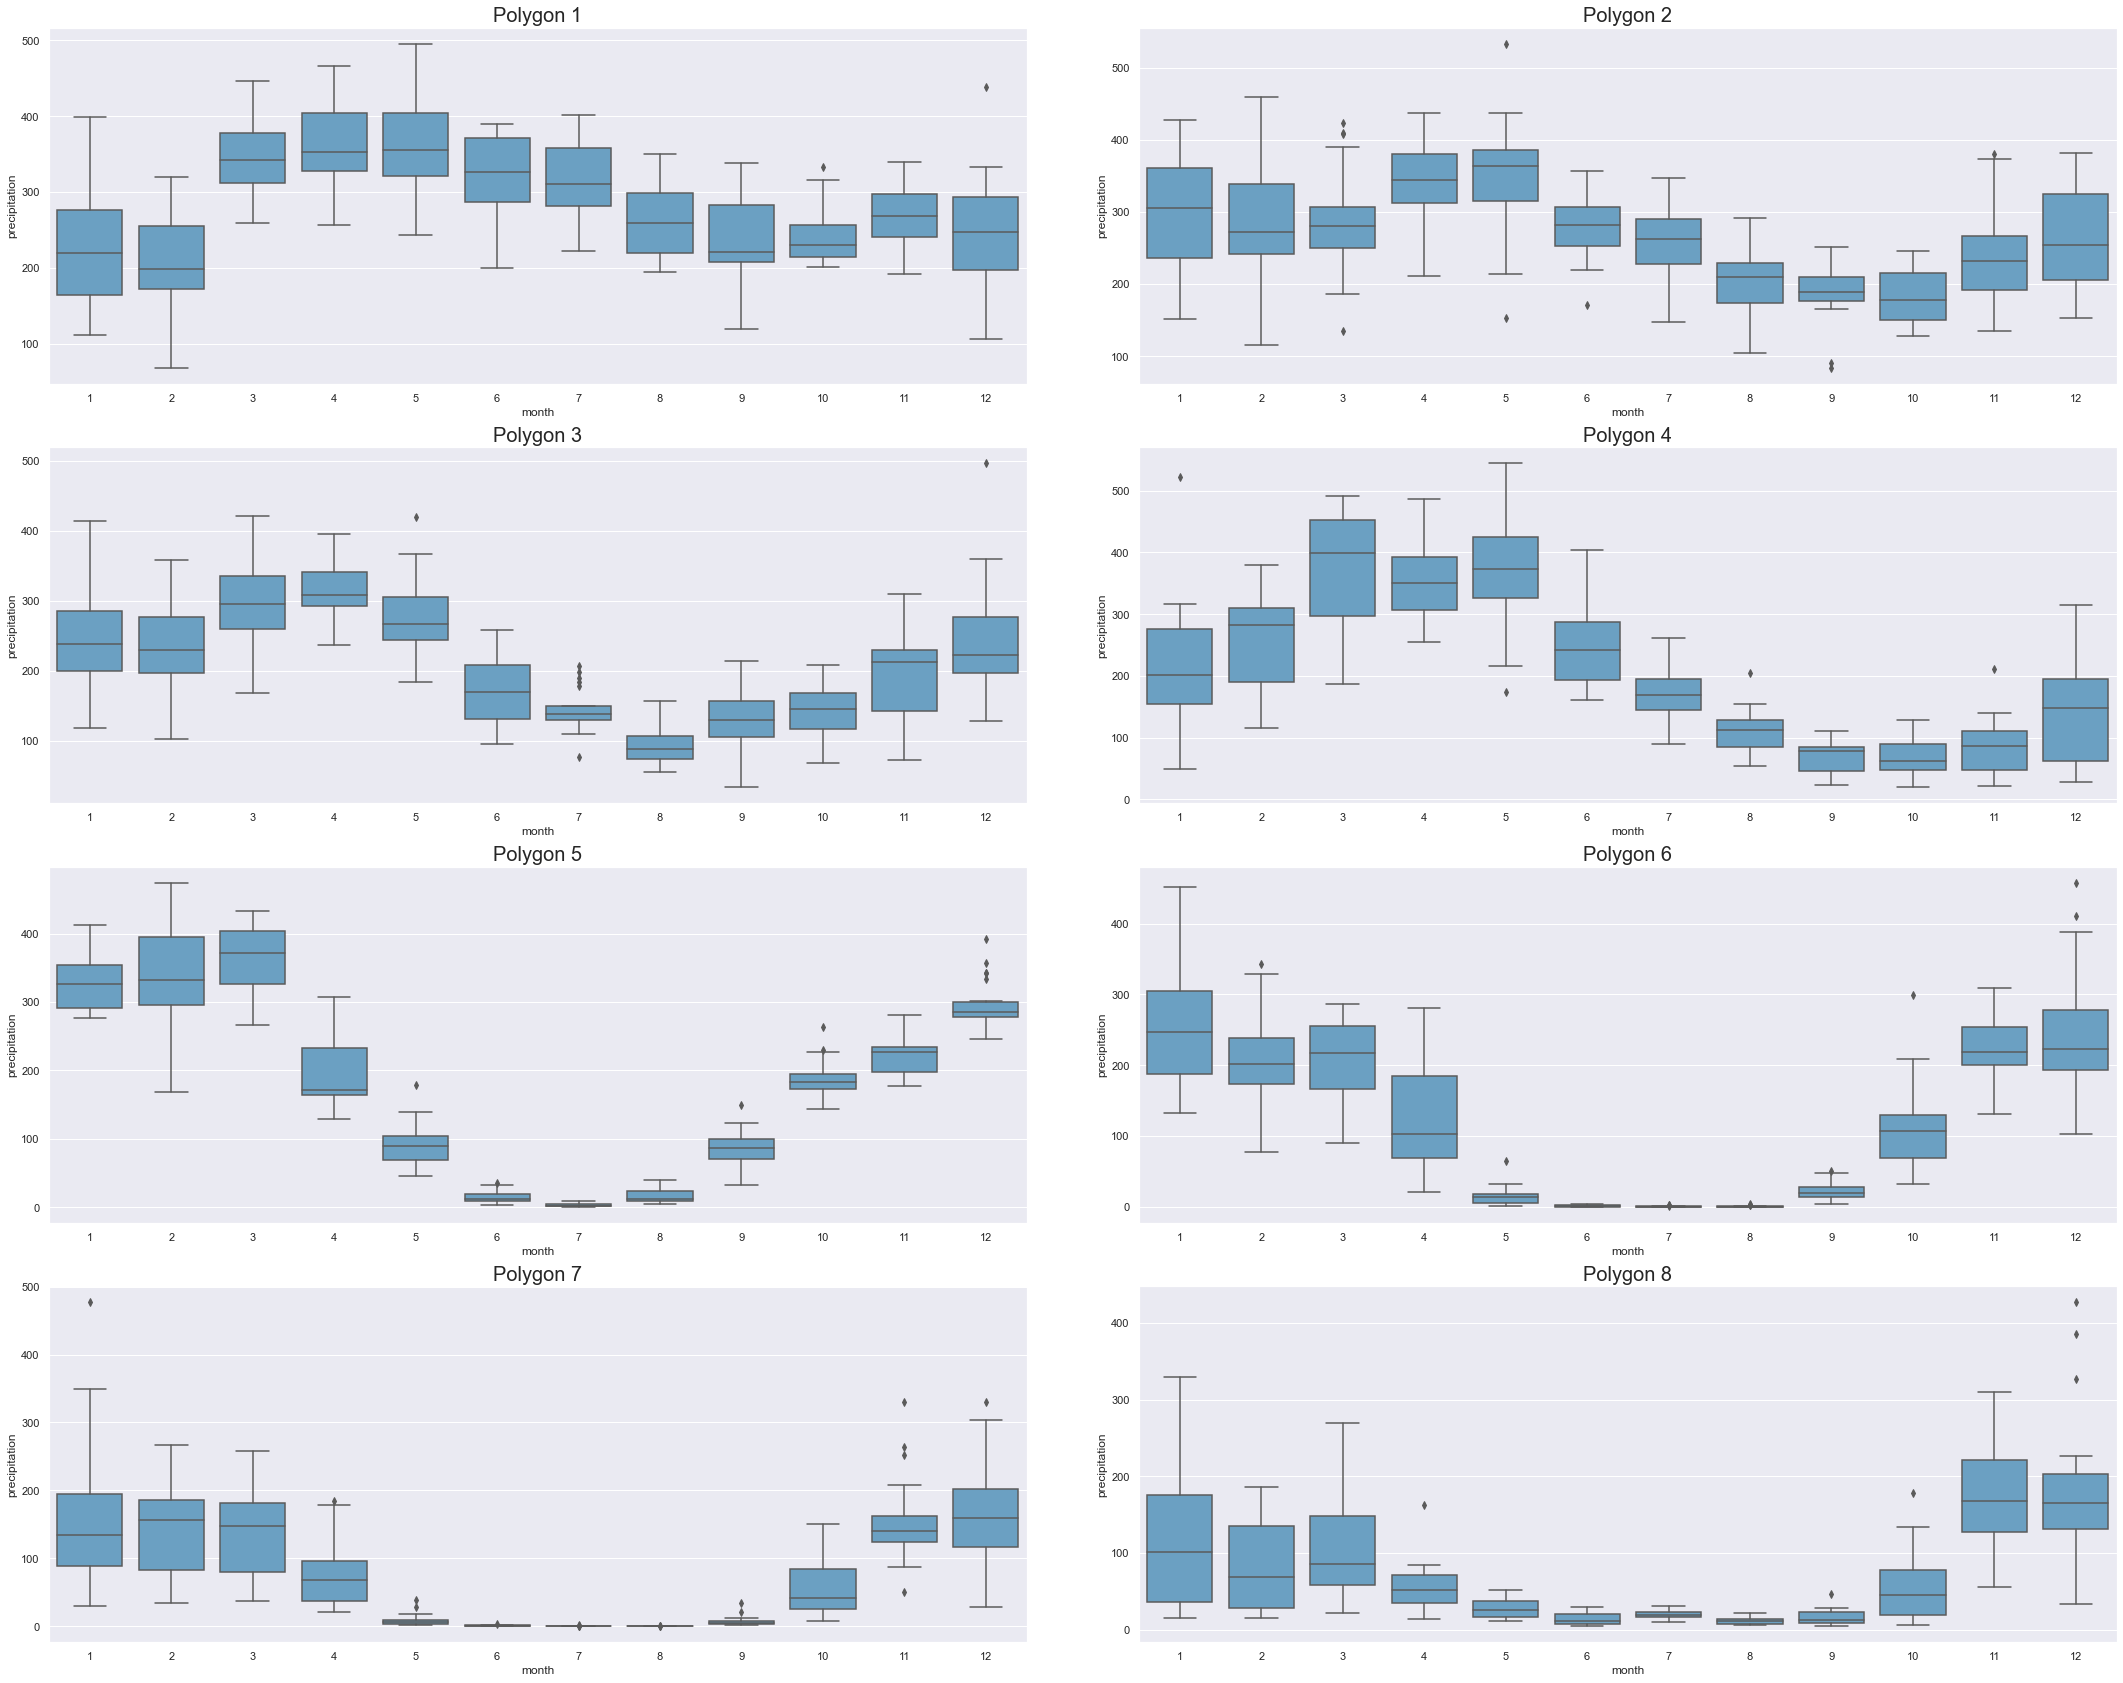

In [42]:
fig, ax = plot.plot_per_polygon(climate, "", lambda df, ax: sns.boxplot(df, x='month', y='precipitation', ax=ax, color=sns.color_palette("Blues", 10)[5]))

In [43]:
climate_monthly_avg = climate.groupby(['month', 'polygon_id']).mean(numeric_only=True).drop(columns='year').reset_index()

In [44]:
# output minimum per polygon
for polygon_id in range(1, 9):
    min_month_p = climate_monthly_avg[climate_monthly_avg.polygon_id==polygon_id].precipitation.min()
    print(f'Polygon {polygon_id}: minimum monthly precipitation = {min_month_p}')

Polygon 1: minimum monthly precipitation = 204.9247994910587
Polygon 2: minimum monthly precipitation = 181.32196552618774
Polygon 3: minimum monthly precipitation = 92.9460033801657
Polygon 4: minimum monthly precipitation = 67.86373246486127
Polygon 5: minimum monthly precipitation = 3.0085166057015686
Polygon 6: minimum monthly precipitation = 0.3547176488139334
Polygon 7: minimum monthly precipitation = 0.07883610909804452
Polygon 8: minimum monthly precipitation = 11.318718173068984


Based on this definition, we will classify polygons 1 and 2 as not having a dry season - this makes sense because they are in the Western Amazon.

In [213]:
# Polygon 3
polygon_id = 3
polygon_data = climate_monthly_avg[climate_monthly_avg.polygon_id==polygon_id].set_index('month')
print(polygon_data.precipitation)
polygon_data_copy = polygon_data.copy()
polygon_data_copy.index = polygon_data_copy.index + 12
polygon_data = pd.concat([polygon_data, polygon_data_copy])
polygon_data.precipitation.rolling(5).sum() / (polygon_data.precipitation.sum() / 2)
# ==> dry season 7, 8, 9, 10

month
1     245.585014
2     236.226369
3     297.291120
4     315.643460
5     276.933744
6     171.813093
7     144.263216
8      92.946003
9     130.542393
10    143.085964
11    194.544818
12    244.517196
Name: precipitation, dtype: float64


month
1          NaN
2          NaN
3          NaN
4          NaN
5     0.550126
6     0.520539
7     0.483656
8     0.401702
9     0.327465
10    0.273784
11    0.282901
12    0.323109
13    0.384326
14    0.426712
15    0.488557
16    0.537125
17    0.550126
18    0.520539
19    0.483656
20    0.401702
21    0.327465
22    0.273784
23    0.282901
24    0.323109
Name: precipitation, dtype: float64

In [210]:
# Polygon 4
polygon_id = 4
polygon_data = climate_monthly_avg[climate_monthly_avg.polygon_id==polygon_id].set_index('month')
print(polygon_data.precipitation)
polygon_data_copy = polygon_data.copy()
polygon_data_copy.index = polygon_data_copy.index + 12
polygon_data = pd.concat([polygon_data, polygon_data_copy])
polygon_data.precipitation.rolling(6).sum() / (polygon_data.precipitation.sum() / 2)
# ==> dry season 8-9-10-11-12

month
1     212.453928
2     259.166600
3     377.771468
4     359.196644
5     367.360971
6     248.343052
7     170.739331
8     110.939356
9      69.521617
10     67.863732
11     85.077380
12    143.891571
Name: precipitation, dtype: float64


month
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.737885
7     0.721013
8     0.661058
9     0.536378
10    0.418540
11    0.304363
12    0.262115
13    0.278987
14    0.338942
15    0.463622
16    0.581460
17    0.695637
18    0.737885
19    0.721013
20    0.661058
21    0.536378
22    0.418540
23    0.304363
24    0.262115
Name: precipitation, dtype: float64

In [159]:
# Polygon 5
polygon_id = 5
polygon_data = climate_monthly_avg[climate_monthly_avg.polygon_id==polygon_id].set_index('month')
print(polygon_data.precipitation)
polygon_data_copy = polygon_data.copy()
polygon_data_copy.index = polygon_data_copy.index + 12
polygon_data = pd.concat([polygon_data, polygon_data_copy])
polygon_data.precipitation.rolling(6).sum() / (polygon_data.precipitation.sum() / 2)
# ==> dry season 5-6-7-8-9

month
1     328.015292
2     337.985546
3     362.673217
4     193.421812
5      92.177859
6      15.307394
7       3.008517
8      16.423560
9      84.942436
10    186.578398
11    225.194237
12    297.040321
Name: precipitation, dtype: float64


month
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.620497
7     0.468821
8     0.318752
9     0.189139
10    0.185945
11    0.248022
12    0.379503
13    0.531179
14    0.681248
15    0.810861
16    0.814055
17    0.751978
18    0.620497
19    0.468821
20    0.318752
21    0.189139
22    0.185945
23    0.248022
24    0.379503
Name: precipitation, dtype: float64

In [160]:
# Polygon 6
polygon_id = 6
polygon_data = climate_monthly_avg[climate_monthly_avg.polygon_id==polygon_id].set_index('month')
print(polygon_data.precipitation)
polygon_data_copy = polygon_data.copy()
polygon_data_copy.index = polygon_data_copy.index + 12
polygon_data = pd.concat([polygon_data, polygon_data_copy])
polygon_data.precipitation.rolling(7).sum() / (polygon_data.precipitation.sum() / 2)
# ==> dry season 4, 5, 6, 7, 8, 9, 10

month
1     254.081768
2     206.577573
3     208.688562
4     125.228724
5      14.968224
6       0.952317
7       0.354718
8       0.611954
9      23.508555
10    113.432817
11    224.767307
12    246.518840
Name: precipitation, dtype: float64


month
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7     0.571147
8     0.392608
9     0.263658
10    0.196562
11    0.266675
12    0.429774
13    0.608073
14    0.753332
15    0.899897
16    0.971546
17    0.902190
18    0.744539
19    0.571147
20    0.392608
21    0.263658
22    0.196562
23    0.266675
24    0.429774
Name: precipitation, dtype: float64

In [162]:
# Polygon 7
polygon_id = 7
polygon_data = climate_monthly_avg[climate_monthly_avg.polygon_id==polygon_id].set_index('month')
print(polygon_data.precipitation)
polygon_data_copy = polygon_data.copy()
polygon_data_copy.index = polygon_data_copy.index + 12
polygon_data = pd.concat([polygon_data, polygon_data_copy])
polygon_data.precipitation.rolling(7).sum() / (polygon_data.precipitation.sum() / 2)
# ==> dry season 4, 5, 6, 7, 8, 9, 10

month
1     156.035873
2     145.156519
3     135.332382
4      73.919977
5       8.911831
6       0.755529
7       0.120798
8       0.078836
9       6.966823
10     53.788765
11    155.296288
12    156.360549
Name: precipitation, dtype: float64


month
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7     0.582748
8     0.408050
9     0.253254
10    0.161912
11    0.253067
12    0.418234
13    0.592174
14    0.754638
15    0.906145
16    0.981143
17    0.930874
18    0.757762
19    0.582748
20    0.408050
21    0.253254
22    0.161912
23    0.253067
24    0.418234
Name: precipitation, dtype: float64

In [221]:
# Polygon 8
polygon_id = 8
polygon_data = climate_monthly_avg[climate_monthly_avg.polygon_id==polygon_id].set_index('month')
print(polygon_data.precipitation)
polygon_data_copy = polygon_data.copy()
polygon_data_copy.index = polygon_data_copy.index + 12
polygon_data = pd.concat([polygon_data, polygon_data_copy])
polygon_data.precipitation.rolling(6).sum() / (polygon_data.precipitation.sum() / 2)
# ==> dry season 2, 4,5,6,7,8,9,10

month
1     111.307127
2      85.142272
3     105.300771
4      55.429477
5      27.103459
6      13.905648
7      20.155068
8      11.318718
9      15.765282
10     54.048917
11    176.800101
12    178.312121
Name: precipitation, dtype: float64


month
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.465942
7     0.359280
8     0.272895
9     0.168125
10    0.166509
11    0.341677
12    0.534058
13    0.640720
14    0.727105
15    0.831875
16    0.833491
17    0.658323
18    0.465942
19    0.359280
20    0.272895
21    0.168125
22    0.166509
23    0.341677
24    0.534058
Name: precipitation, dtype: float64

In [45]:
# Based on the statistics above, we determine dry seasons for each region to be the following:
dry_season = {3: (6, 11), 4: (7, 13), 5: (5, 10), 6:(5, 10), 7:(4 ,10), 8: (2, 11)}

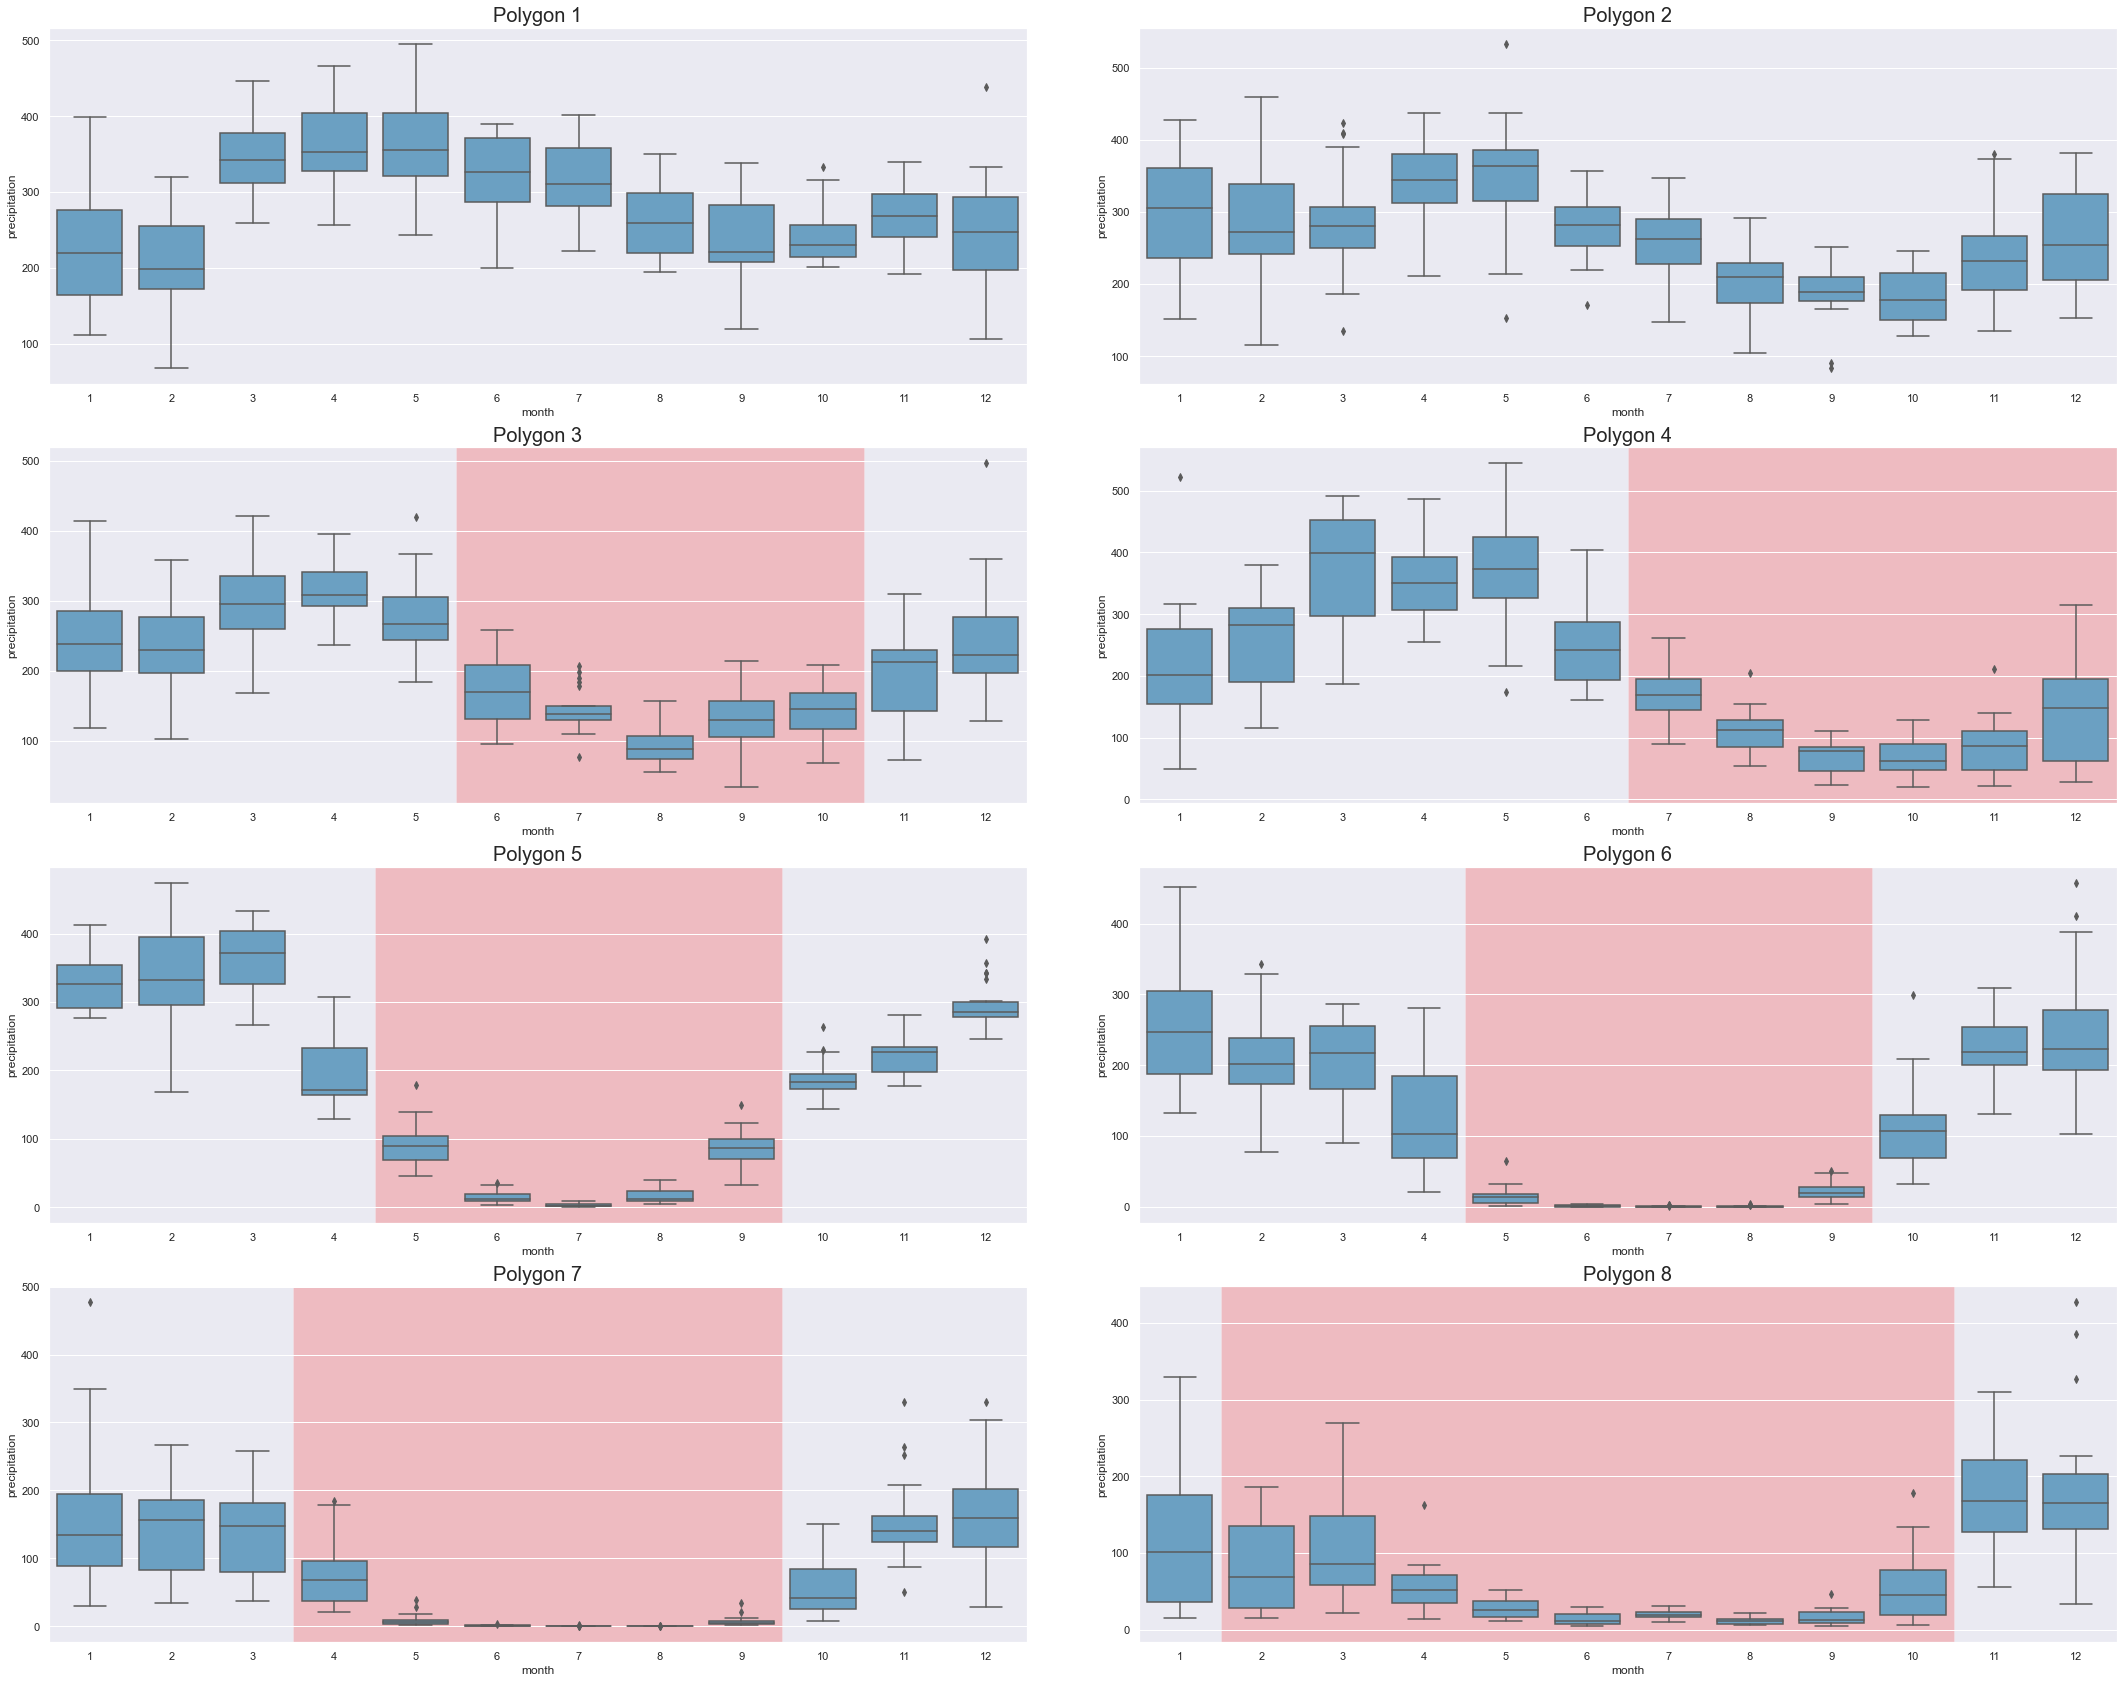

In [46]:
def plot_dry_seaon_per_polygon(data: pd.DataFrame, title, plot_func, fig=None, ax=None,
                     sharey=False, twin_axis=False
                     ) -> plt.figure:
    if fig is None and ax is None:
        fig, ax = plt.subplots(4, 2, figsize=(30, 24), sharey=sharey)
        fig.suptitle(title, fontsize=30)
        fig.tight_layout(pad=3.0, h_pad=4.0, w_pad=8.0)

    for i in range(8):
        subplot = ax[i // 2, i % 2]

        if i+1 in dry_season:
            subplot.axvspan(dry_season[i+1][0] - 1.5, dry_season[i+1][1] - 1.5, facecolor='red', alpha=0.2, zorder=-100)
        # Select polygon from the data. Polygon IDs go from 1 to 8.
        polygon_id = i + 1
        polygon_data = data[data['polygon_id'] == polygon_id]

        # Plot.
        if twin_axis:
            plot_func(polygon_data, subplot.twinx())
        else:
            plot_func(polygon_data, subplot)
        subplot.set_title(f"Polygon {polygon_id}", fontsize=20)

    return fig, ax
    
fig, ax = plot_dry_seaon_per_polygon(climate, "", lambda df, ax: sns.boxplot(df, x='month', y='precipitation', ax=ax, color=sns.color_palette("Blues", 10)[5]))

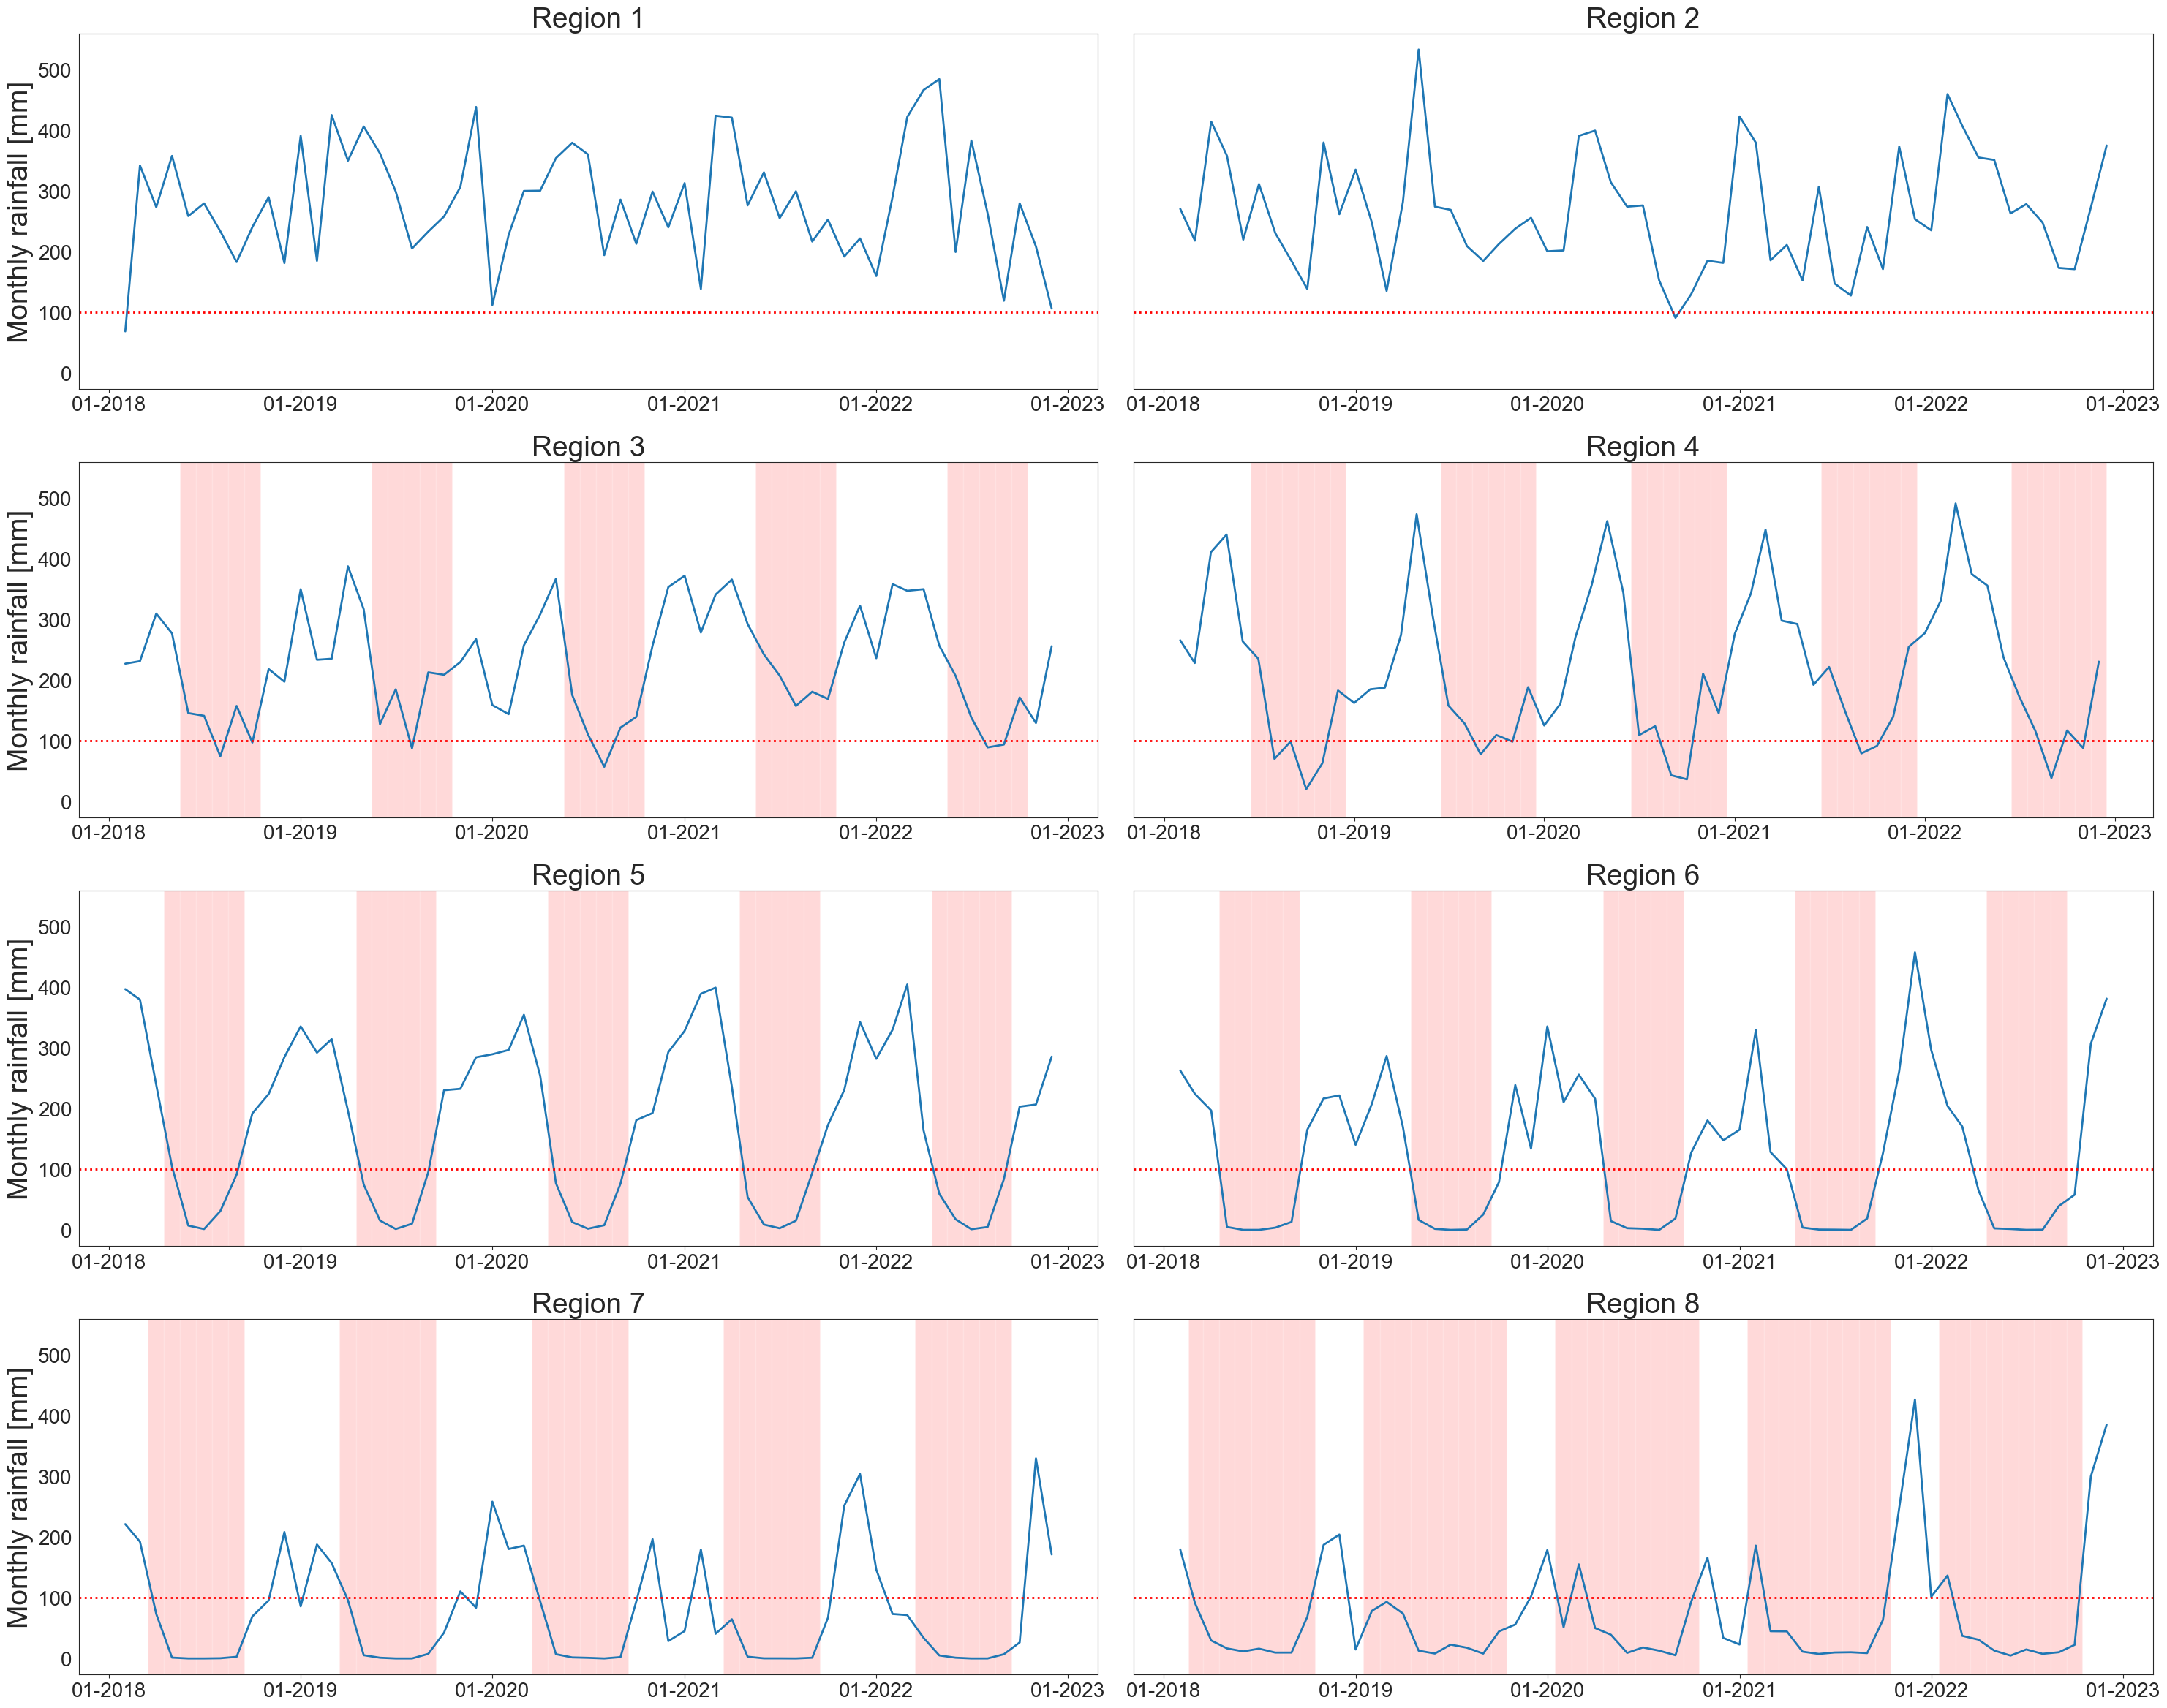

In [48]:
# Plot precipitation with dry seasons.
def format_date(ax):
    for row in ax:
        for axis in row:
            #locator = mdates.AutoDateLocator(minticks=10, maxticks=17)
            locator = mdates.MonthLocator(bymonth=[1])
            axis.xaxis.set_major_locator(locator) 
            axis.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
            x_axis = axis.axes.get_xaxis()
            x_axis.set_label_text('')

def plot_dry_months_per_polygon(data: pd.DataFrame, title, plot_func, fig=None, ax=None,
                     sharey=False, twin_axis=False
                     ) -> plt.figure:
    if fig is None and ax is None:
        fig, ax = plt.subplots(4, 2, figsize=(30, 24), sharey=True)
        fig.suptitle(title, fontsize=30)
        fig.tight_layout(pad=3.0, h_pad=4.0, w_pad=8.0)

    for i in range(8):
        subplot = ax[i // 2, i % 2]

        # Select polygon from the data. Polygon IDs go from 1 to 8.
        polygon_id = i + 1
        polygon_data = data[data['polygon_id'] == polygon_id]

        if i+1 in dry_season:
            dry_months = polygon_data[polygon_data.month.isin(range(dry_season[i+1][0] - 1, dry_season[i+1][1] - 1))]
            for month in dry_months.datetime:
                subplot.axvspan(pd.DateOffset(days=15) + month, pd.DateOffset(months=1, days=15) + month, facecolor='red', alpha=0.15, zorder=-100)

        # Plot.
        if twin_axis:
            plot_func(polygon_data, subplot.twinx())
        else:
            plot_func(polygon_data, subplot)
        subplot.set_title(f"Region {polygon_id}", fontsize=28)
        subplot.set_ylabel("Monthly rainfall [mm]",fontsize=28)
        subplot.axhline(y = 100, color='red', linestyle='dotted', linewidth=2)
        subplot.tick_params(axis='both', which='major', labelsize=20, bottom=True)
        plt.rcParams['xtick.bottom'] = True
    return fig, ax


plt.rcParams.update(plt.rcParamsDefault)
sns.set_style('white')
fig, ax = plot_dry_months_per_polygon(climate_int[climate_int.datetime > '2018-01-01'], "", lambda df, ax: sns.lineplot(df, x='datetime', y='precipitation', ax=ax, linewidth=2))
format_date(ax)
fig.tight_layout(pad=2)
plt.savefig('../../reports/figures/final/precipitation_ts_with_dry_season_indicators.png')

### Modeling water deficit

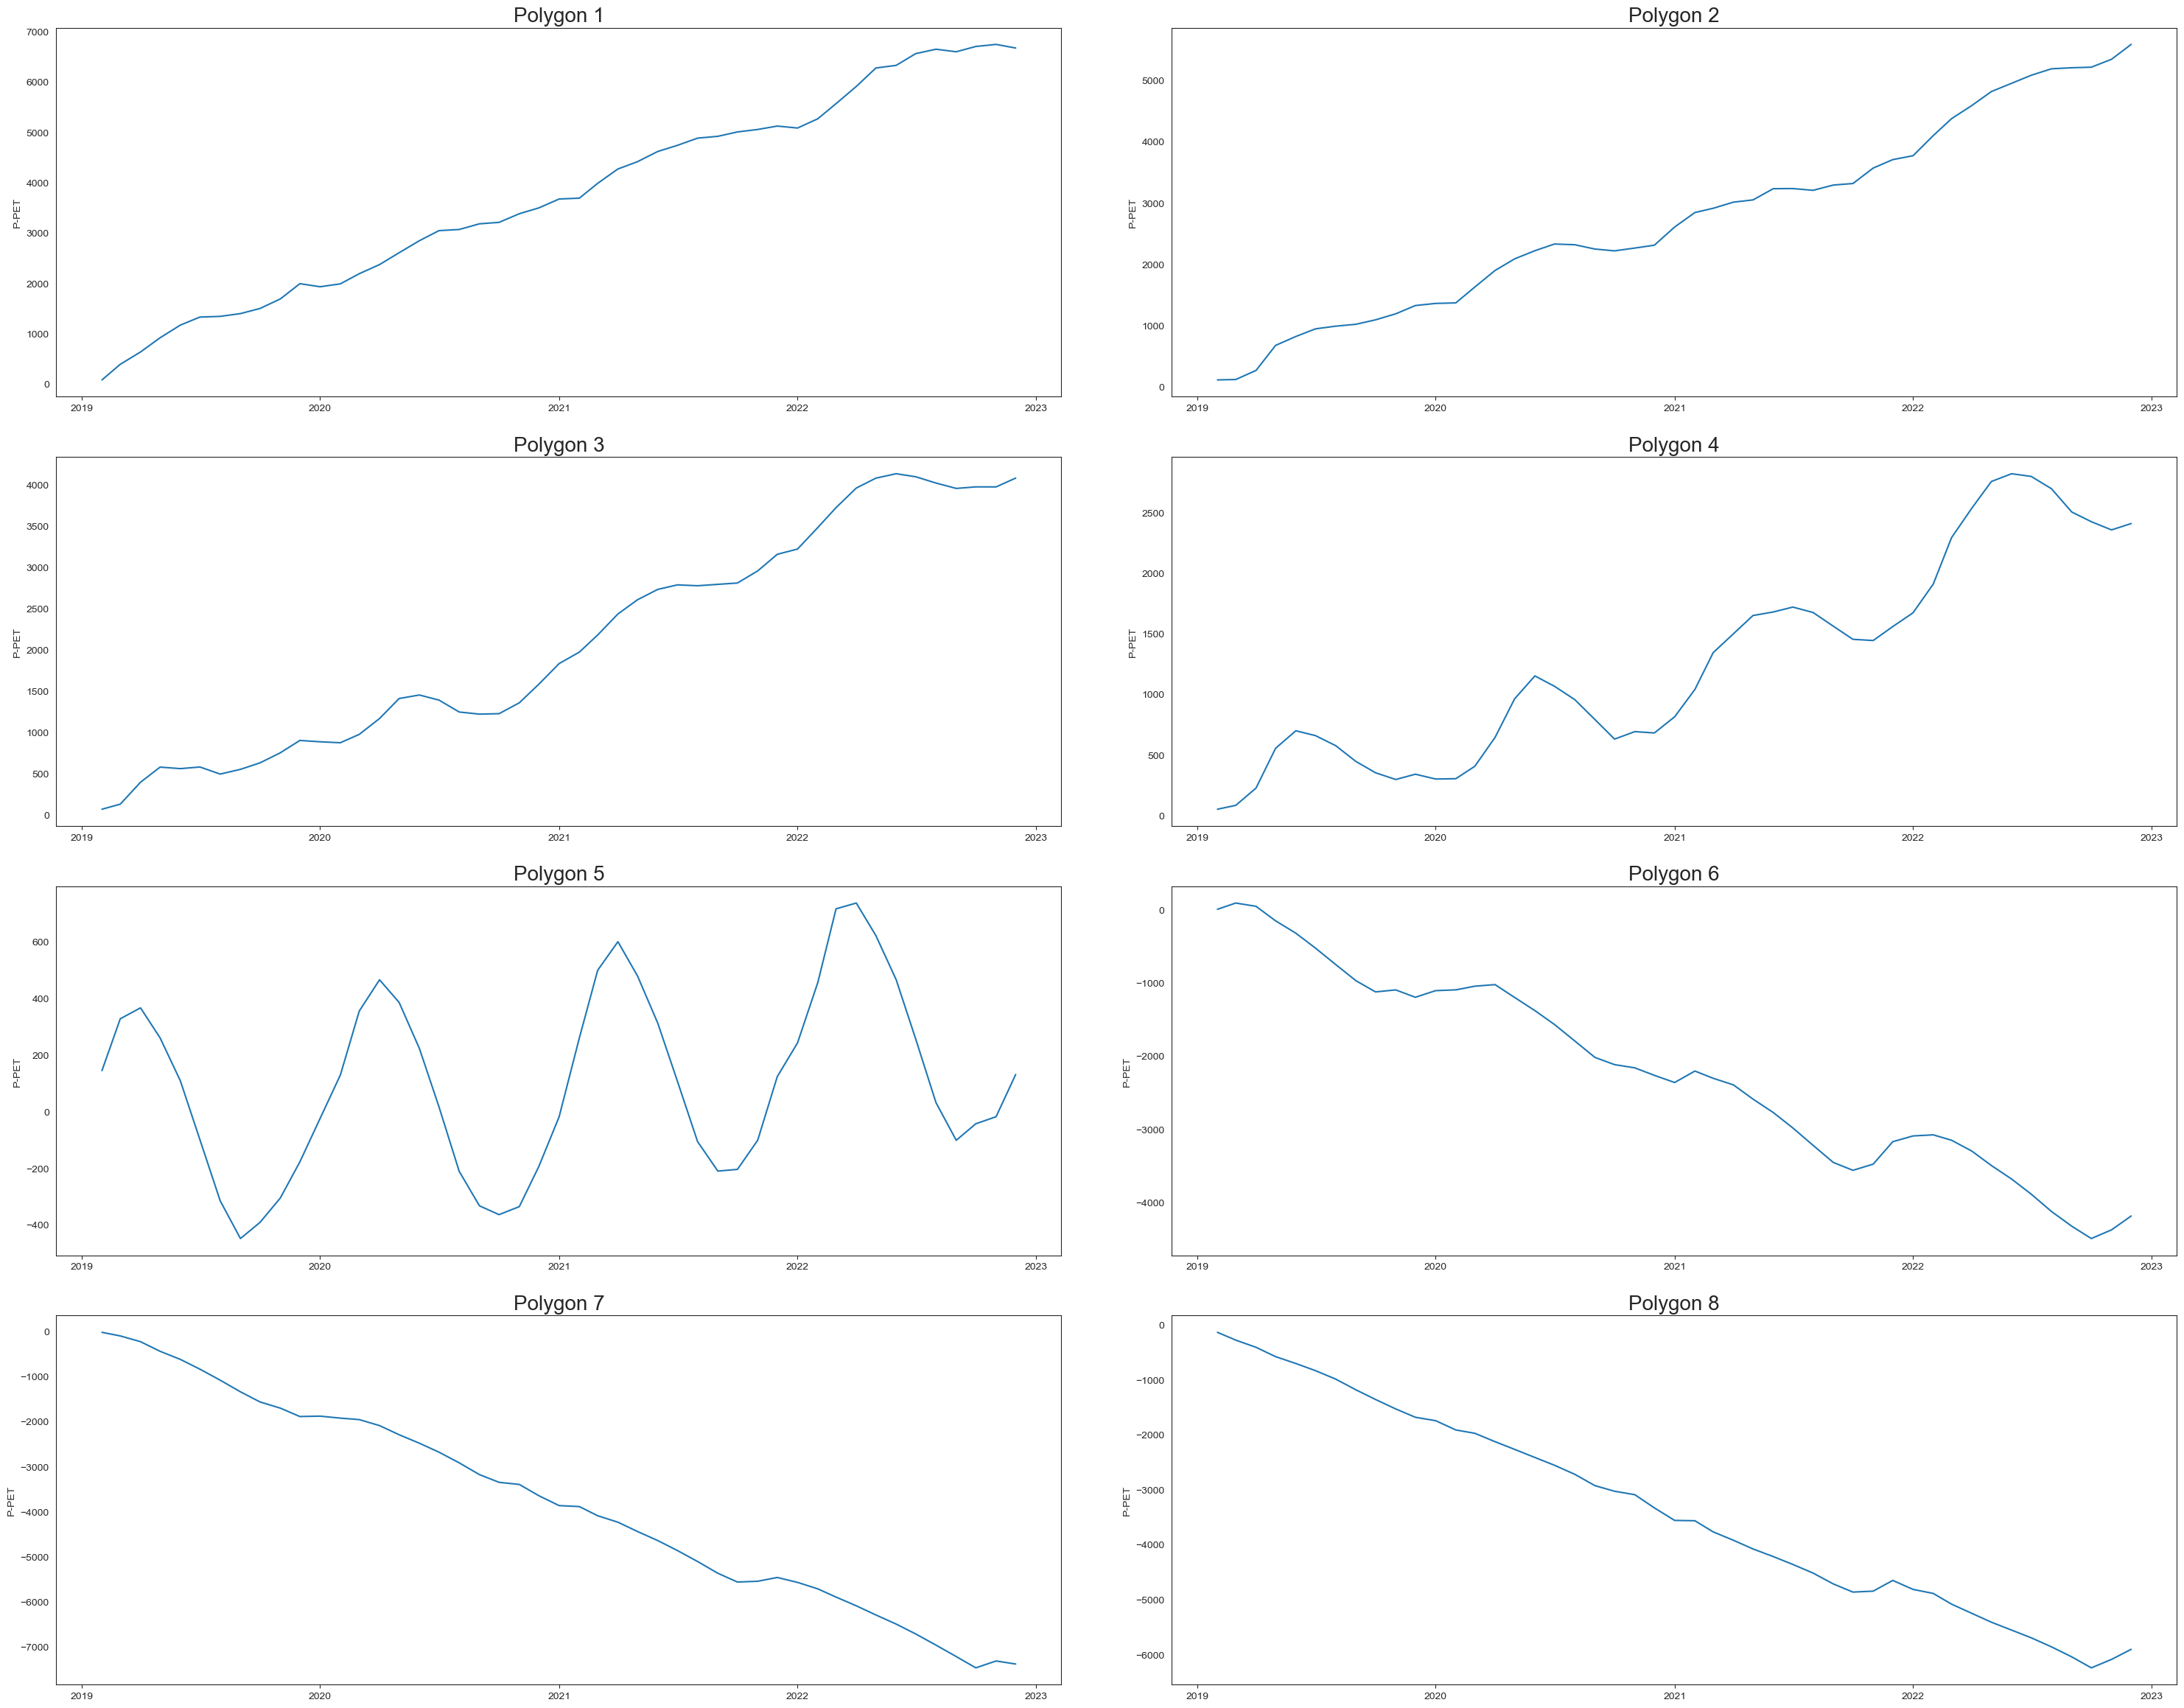

In [49]:

fig, ax = plot.plot_per_polygon(climate_int[climate_int.datetime > '2019-01-01'], "", lambda df, ax: sns.lineplot(x=df.datetime, y=df['P-PET'].cumsum(), ax=ax))
format_date_long_ts(ax)

### PAI_Z Comparison across polygons

In [37]:
gedi_all = pd.read_csv('/maps-priv/maps/drought-with-gedi/gedi_data/gedi_extended_filtered-03-15.csv', index_col=0)

In [38]:
# For some reason, pai_z is a string, so convert to a numpy array
gedi_all['pai_z_np'] = gedi_all.apply(lambda row: np.flip(np.trim_zeros(np.array(row.pai_z[1:-1].split(", ")).astype(float))), axis = 1)

In [40]:
def pad_numpy_array(df):
    pai_array = df.pai_z_np
    return np.pad(pai_array, (0, 30-pai_array.size), 'constant')

gedi_all['pai_z_padded'] = gedi_all.apply(pad_numpy_array, axis = 1)

In [41]:
def calc_pai_z_delta(df):
    pai_array = df.pai_z_padded
    pai_rolled = np.roll(pai_array, 1)
    pai_delta = pai_array - pai_rolled
    pai_delta[pai_delta < 0] = 0
    return pai_delta

gedi_all['pai_z_delta_np'] = gedi_all.apply(calc_pai_z_delta, axis=1)

In [42]:
# Calculate vertical means for each polygon.
vertical_means = []
for polygon_id in range(1, 9):
    polygon_data = gedi_all[(gedi_all.polygon_id==polygon_id)]
    vertical_means.append(np.mean(polygon_data.pai_z_padded.to_numpy(), axis=0))

In [43]:
# Calculate vertical means for each polygon.
delta_means = []
for polygon_id in range(1, 9):
    polygon_data = gedi_all[(gedi_all.polygon_id==polygon_id)]
    delta_means.append(np.mean(polygon_data.pai_z_delta_np.to_numpy(), axis=0))

In [95]:
vertical_means_pdf= pd.DataFrame(vertical_means)
vertical_means_pdf['polygon_id'] = vertical_means_pdf.index + 1
vertical_df = vertical_means_pdf.set_index('polygon_id').transpose().reset_index().melt(id_vars=['index'], value_vars=[1, 2, 3, 4, 5, 6, 7, 8])

In [96]:
delta_means_pdf= pd.DataFrame(delta_means)
delta_means_pdf['polygon_id'] = delta_means_pdf.index + 1
delta_df = delta_means_pdf.set_index('polygon_id').transpose().reset_index().melt(id_vars=['index'], value_vars=[1, 2, 3, 4, 5, 6, 7, 8])

In [97]:
vertical_df.to_csv("../../data/interim/pai_z_means_per_polygon.csv")
delta_df.to_csv("../../data/interim/pai_z_delta_means_per_polygon.csv")

(0.0, 12.0)

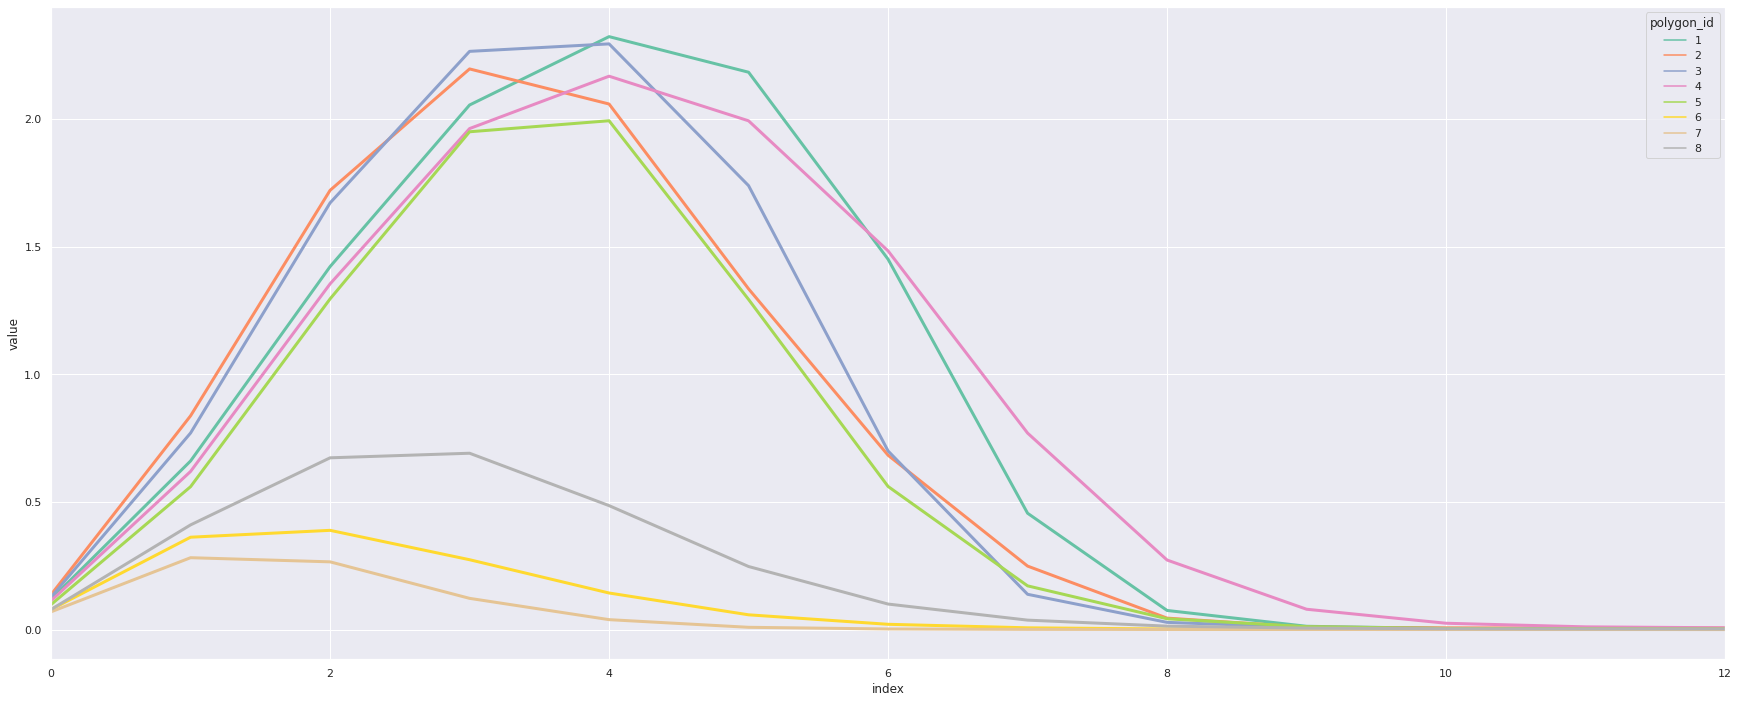

In [161]:
# Plot PAI z per region
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 1, figsize=(30, 12))
graph = sns.lineplot(vertical_df, x='index', y='value', hue='polygon_id', palette=palette, ax=ax, linewidth=3)
ax.set_xlim(0, 12)

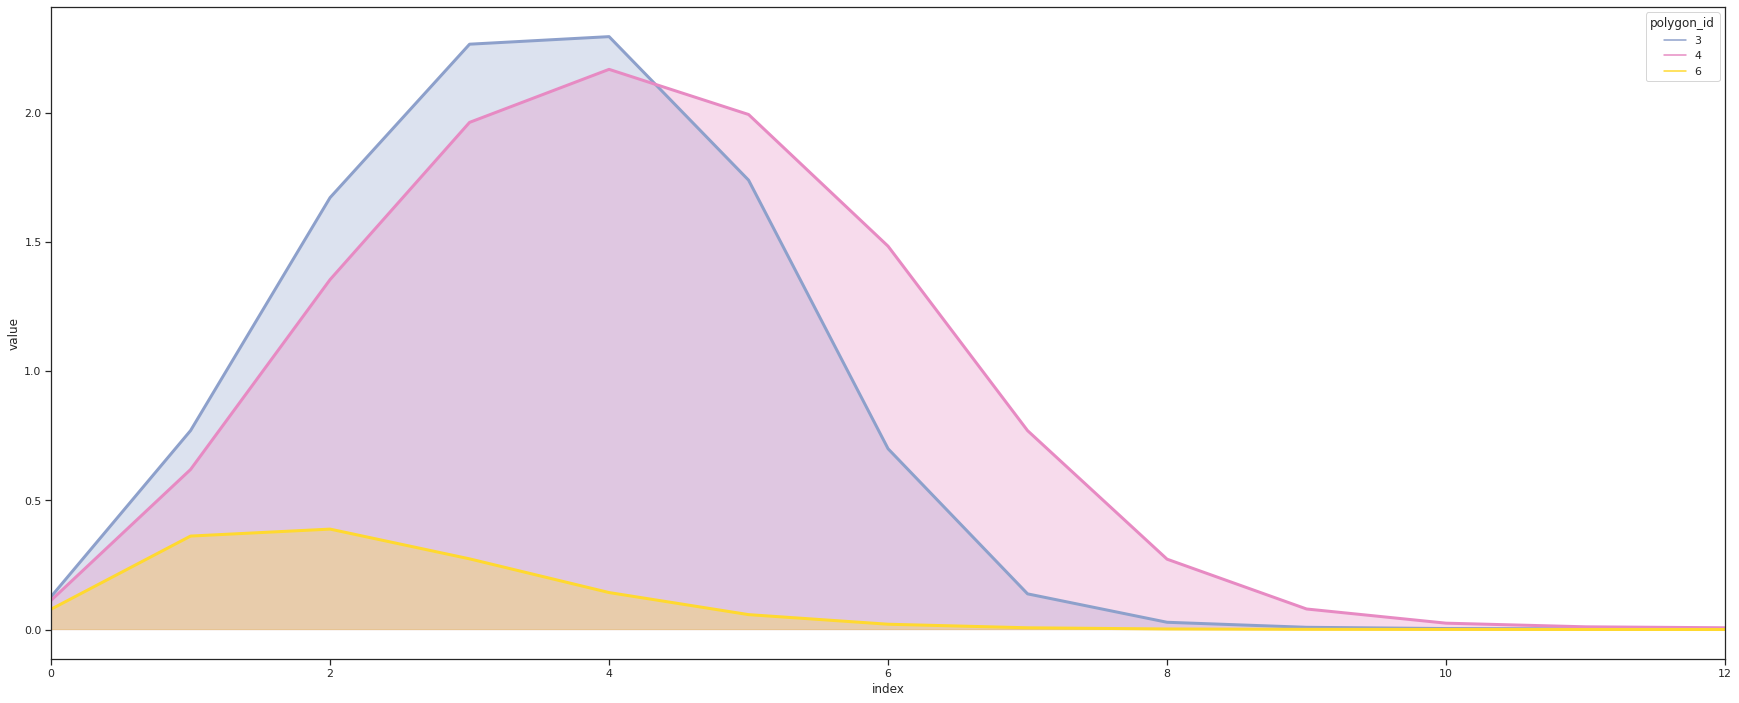

In [163]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(30, 12))

graph = sns.lineplot(vertical_df[vertical_df.polygon_id.isin([3, 4, 6])], x='index', y='value', hue='polygon_id', palette=[palette[i] for i in [2, 3, 5]], ax=ax, linewidth=3)
ax.set_xlim(0, 12)
line = graph.get_lines()
plt.fill_between(line[0].get_xdata(), line[0].get_ydata(), 0, color=palette[2], alpha=.3)
plt.fill_between(line[1].get_xdata(), line[1].get_ydata(), 0, color=palette[3], alpha=.3)
plt.fill_between(line[2].get_xdata(), line[2].get_ydata(), 0, color=palette[5], alpha=.3)

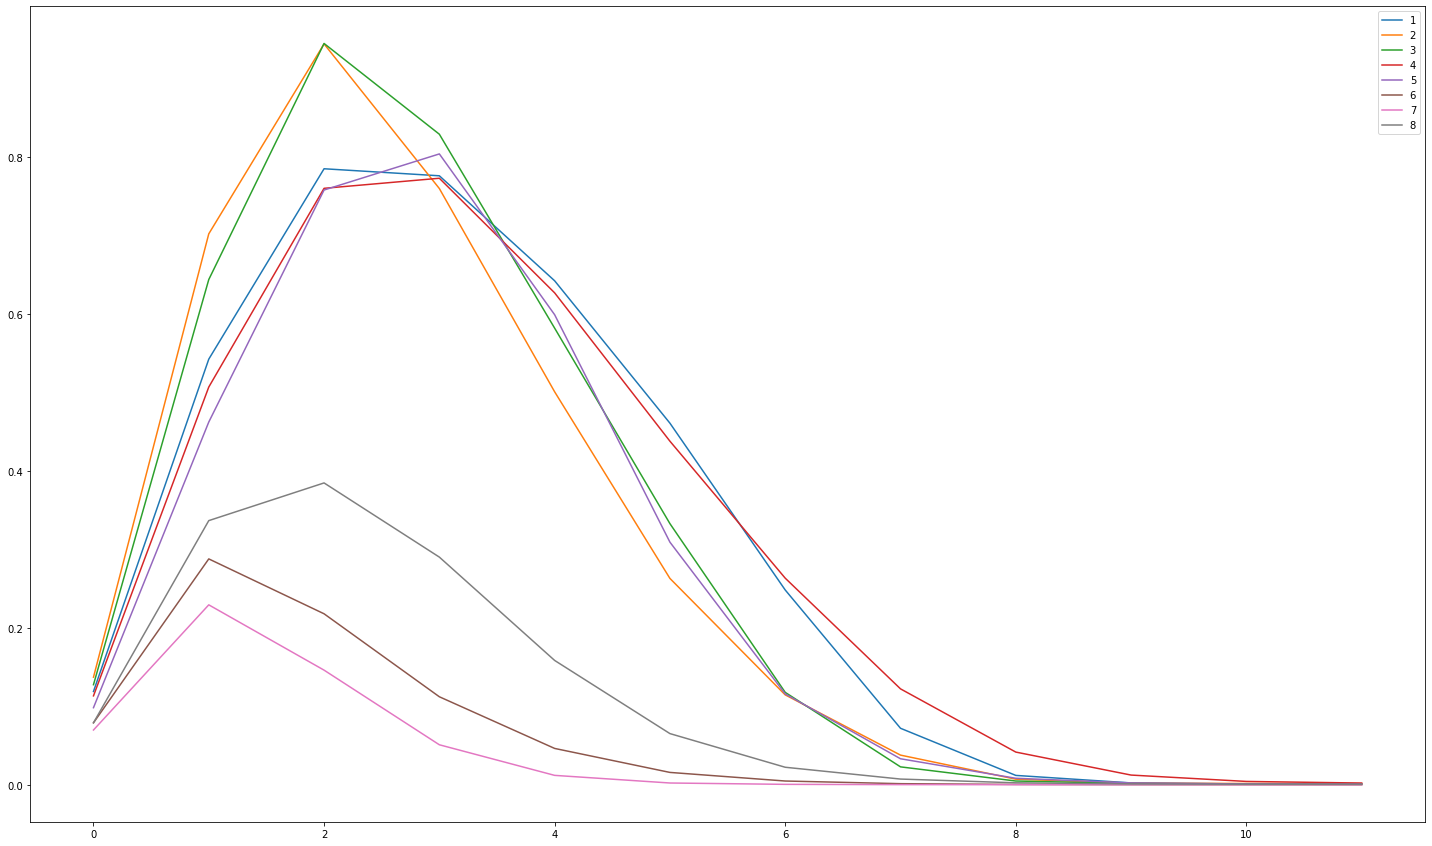

In [67]:
# Plot delta pai z per polygon
plt.rcParams['figure.figsize'] = [25, 15]
for i in range(0, 8):
    plt.plot(delta_means[i][:12], label=f'{i+1}')
plt.legend()

In [345]:
polygon_2_before_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2020) & (gedi_all.month == 3)]
polygon_2_during_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2020) & (gedi_all.month == 11)]
polygon_2_after_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2021) & (gedi_all.month == 2)]
polygon_2_long_after_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2022) & (gedi_all.month == 5)]

In [44]:
polygon_2_before_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2020) & (gedi_all.month.isin([3, 4, 5]))]
polygon_2_during_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2020) & (gedi_all.month.isin([10, 11, 12]))]
polygon_2_after_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2021) & (gedi_all.month.isin([1, 2, 3]))]
polygon_2_long_after_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2022) & (gedi_all.month.isin([3, 4, 5]))]
polygon_2_middle = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2021) & (gedi_all.month.isin([7, 8, 9]))]

In [45]:
def select_footprints(df):
    df['include_left'] = ((-66.25 + 67.5) * (df.lat_lowestmode + 1.2) - (0.55 + 1.2) * (df.lon_lowestmode + 67.5)) > 0
    df['include_right'] = ((-67 + 68) * (df.lat_lowestmode + 1.2) - (0.3 + 1.2) * (df.lon_lowestmode + 68)) < 0
    return df[df.include_left & df.include_right]

polygon_2_before_drought = select_footprints(polygon_2_before_drought)
polygon_2_during_drought = select_footprints(polygon_2_during_drought)
polygon_2_after_drought = select_footprints(polygon_2_after_drought)
polygon_2_long_after_drought = select_footprints(polygon_2_long_after_drought)
polygon_2_middle = select_footprints(polygon_2_middle)

In [152]:
polygon_2_before_drought.pai.mean()

4.308379504311426

In [154]:
polygon_2_during_drought.pai.mean()

3.865068379973339

In [153]:
polygon_2_after_drought.pai.mean()

4.146877647310443

<AxesSubplot: xlabel='lon_lowestmode', ylabel='lat_lowestmode'>

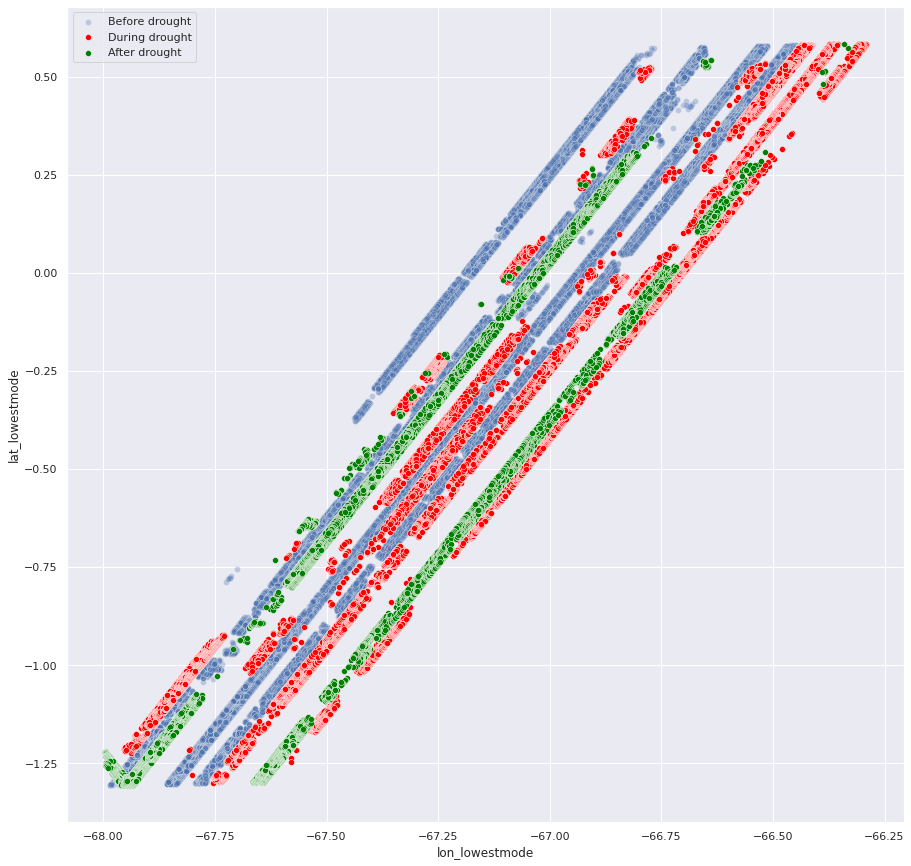

In [46]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.scatterplot(x=polygon_2_before_drought.lon_lowestmode, y=polygon_2_before_drought.lat_lowestmode, alpha=0.3, label='Before drought')
sns.scatterplot(x=polygon_2_during_drought.lon_lowestmode, y=polygon_2_during_drought.lat_lowestmode, color='red', alpha=1, label='During drought')
sns.scatterplot(x=polygon_2_after_drought.lon_lowestmode, y=polygon_2_after_drought.lat_lowestmode, color='green', alpha=1, label='After drought')
#abline(1.5, 100.8)
#abline(1.4, 93.3)
#sns.scatterplot(x=polygon_2_long_after_drought.lon_lowestmode, y=polygon_2_long_after_drought.lat_lowestmode, color='purple', alpha=1)

In [47]:
vm_before_drought = np.mean(polygon_2_before_drought.pai_z_padded.to_numpy(), axis=0)
vm_during_drought = np.mean(polygon_2_during_drought.pai_z_padded.to_numpy(), axis=0)
vm_after_drought = np.mean(polygon_2_after_drought.pai_z_padded.to_numpy(), axis=0)
vm_long_after_drought = np.mean(polygon_2_long_after_drought.pai_z_padded.to_numpy(), axis=0)

In [49]:
vm_delta_before_drought = np.mean(polygon_2_before_drought.pai_z_delta_np.to_numpy(), axis=0)
vm_delta_during_drought = np.mean(polygon_2_during_drought.pai_z_delta_np.to_numpy(), axis=0)
vm_delta_after_drought = np.mean(polygon_2_after_drought.pai_z_delta_np.to_numpy(), axis=0)
vm_delta_long_after_drought = np.mean(polygon_2_long_after_drought.pai_z_delta_np.to_numpy(), axis=0)

In [67]:
p2_drought_delta = pd.DataFrame({'before': vm_delta_before_drought, 'during': vm_delta_during_drought, 'after': vm_delta_after_drought, 'later': vm_delta_long_after_drought})
p2_drought_delta.index.name = 'index'

In [73]:
p2_drought_delta = p2_drought_delta.reset_index()

In [86]:
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [104]:
palette2 = sns.color_palette("pastel")
palette2

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [143]:
p2_drought_delta.to_csv('../../data/interim/polygon_2_drought_delta_pai_z.png')

In [151]:
p2_drought_delta.before.mean()

0.14359370544200187

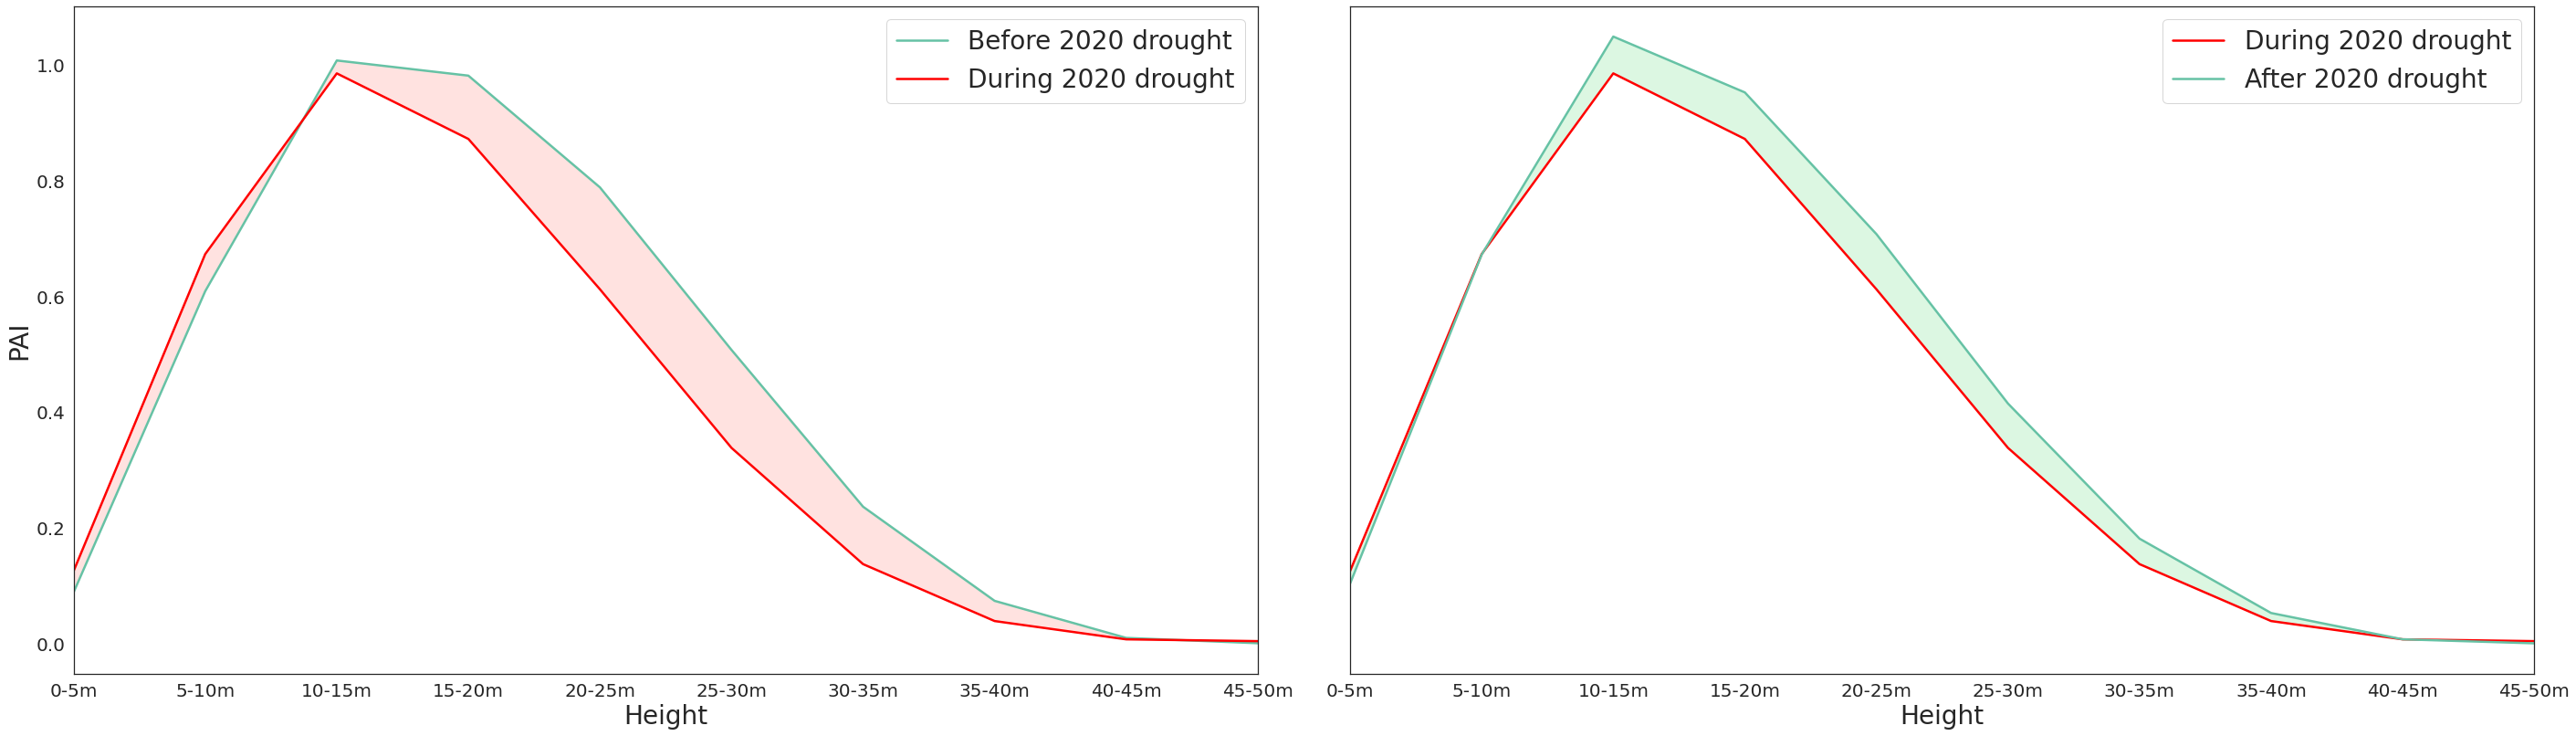

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(40, 12), sharex=True, sharey=True)
sns.set_theme(style='whitegrid')
g = sns.lineplot(p2_drought_delta, x='index', y='before', ax=ax[0], label='Before 2020 drought', color=palette[0], linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='during', ax=ax[0], label='During 2020 drought', color='red', linewidth=2.5)
ax[0].fill_between(x=p2_drought_delta.index, y1=p2_drought_delta.during, y2=p2_drought_delta.before, alpha=0.3, color=palette2[3])
ax[0].set_ylabel('PAI', fontsize = 28)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel('Height', fontsize = 28)
sns.move_legend(g, "upper right", fontsize=28)
ax[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax[0].set_xticklabels(['0-5m', '5-10m', '10-15m', '15-20m', '20-25m', '25-30m', '30-35m', '35-40m', '40-45m', '45-50m'])


b =sns.lineplot(p2_drought_delta, x='index', y='during', ax=ax[1], label='During 2020 drought', color='red', linewidth=2.5)
b= sns.lineplot(p2_drought_delta, x='index', y='after', ax=ax[1], label='After 2020 drought', color=palette[0], linewidth=2.5)
ax[1].fill_between(x=p2_drought_delta.index, y1=p2_drought_delta.during, y2=p2_drought_delta.after, alpha=0.3, color=palette2[2])
ax[1].set_ylabel('PAI', fontsize = 28)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_xlabel('Height', fontsize = 28)
sns.move_legend(b, "upper right", fontsize=28)

ax[0].set_xlim((0, 9))
fig.tight_layout(pad=3)
plt.savefig('../../reports/figures/polygon_2_before_during_2020_drought.png')

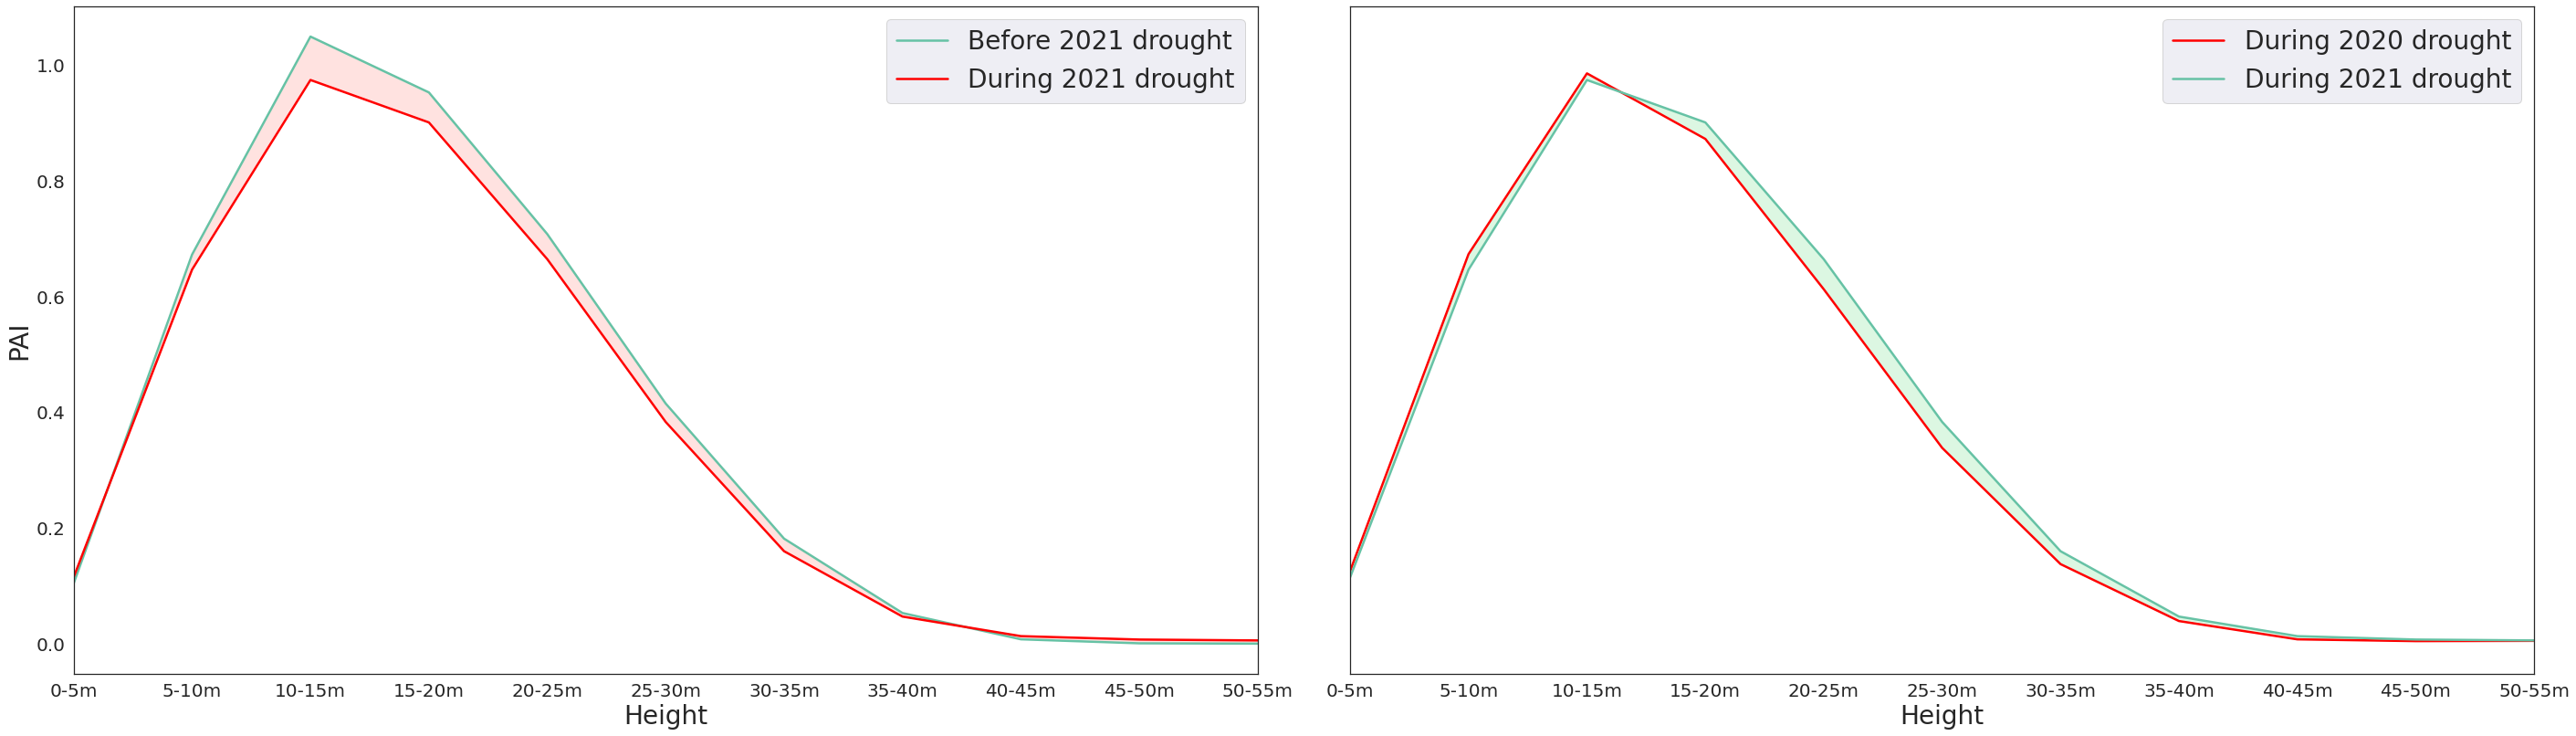

In [147]:
sns.set_theme(style="white", rc={'lines.linewidth': 2.5, 'lines.markersize': 10}   )
fig, ax = plt.subplots(1, 2, figsize=(40, 12), sharex=True, sharey=True)
sns.set_theme()
g = sns.lineplot(p2_drought_delta, x='index', y='after', ax=ax[0], label='Before 2021 drought', color=palette[0], linewidth=2.5)
g = sns.lineplot(p2_drought_delta, x='index', y='later', ax=ax[0], label='During 2021 drought', color='red', linewidth=2.5)
ax[0].fill_between(x=p2_drought_delta.index, y1=p2_drought_delta.after, y2=p2_drought_delta.later, alpha=0.3, color=palette2[3])
ax[0].set_ylabel('PAI', fontsize = 28)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel('Height', fontsize = 28)
sns.move_legend(g, "upper right", fontsize=28)
ax[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax[0].set_xticklabels(['0-5m', '5-10m', '10-15m', '15-20m', '20-25m', '25-30m', '30-35m', '35-40m', '40-45m', '45-50m', '50-55m'])


b =sns.lineplot(p2_drought_delta, x='index', y='during', ax=ax[1], label='During 2020 drought', color='red', linewidth=2.5)
b= sns.lineplot(p2_drought_delta, x='index', y='later', ax=ax[1], label='During 2021 drought', color=palette[0], linewidth=2.5)
ax[1].fill_between(x=p2_drought_delta.index, y1=p2_drought_delta.during, y2=p2_drought_delta.later, alpha=0.3, color=palette2[2])
ax[1].set_ylabel('PAI', fontsize = 28)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_xlabel('Height', fontsize = 28)
sns.move_legend(b, "upper right", fontsize=28)

ax[0].set_xlim((0, 10))
fig.tight_layout(pad=3)

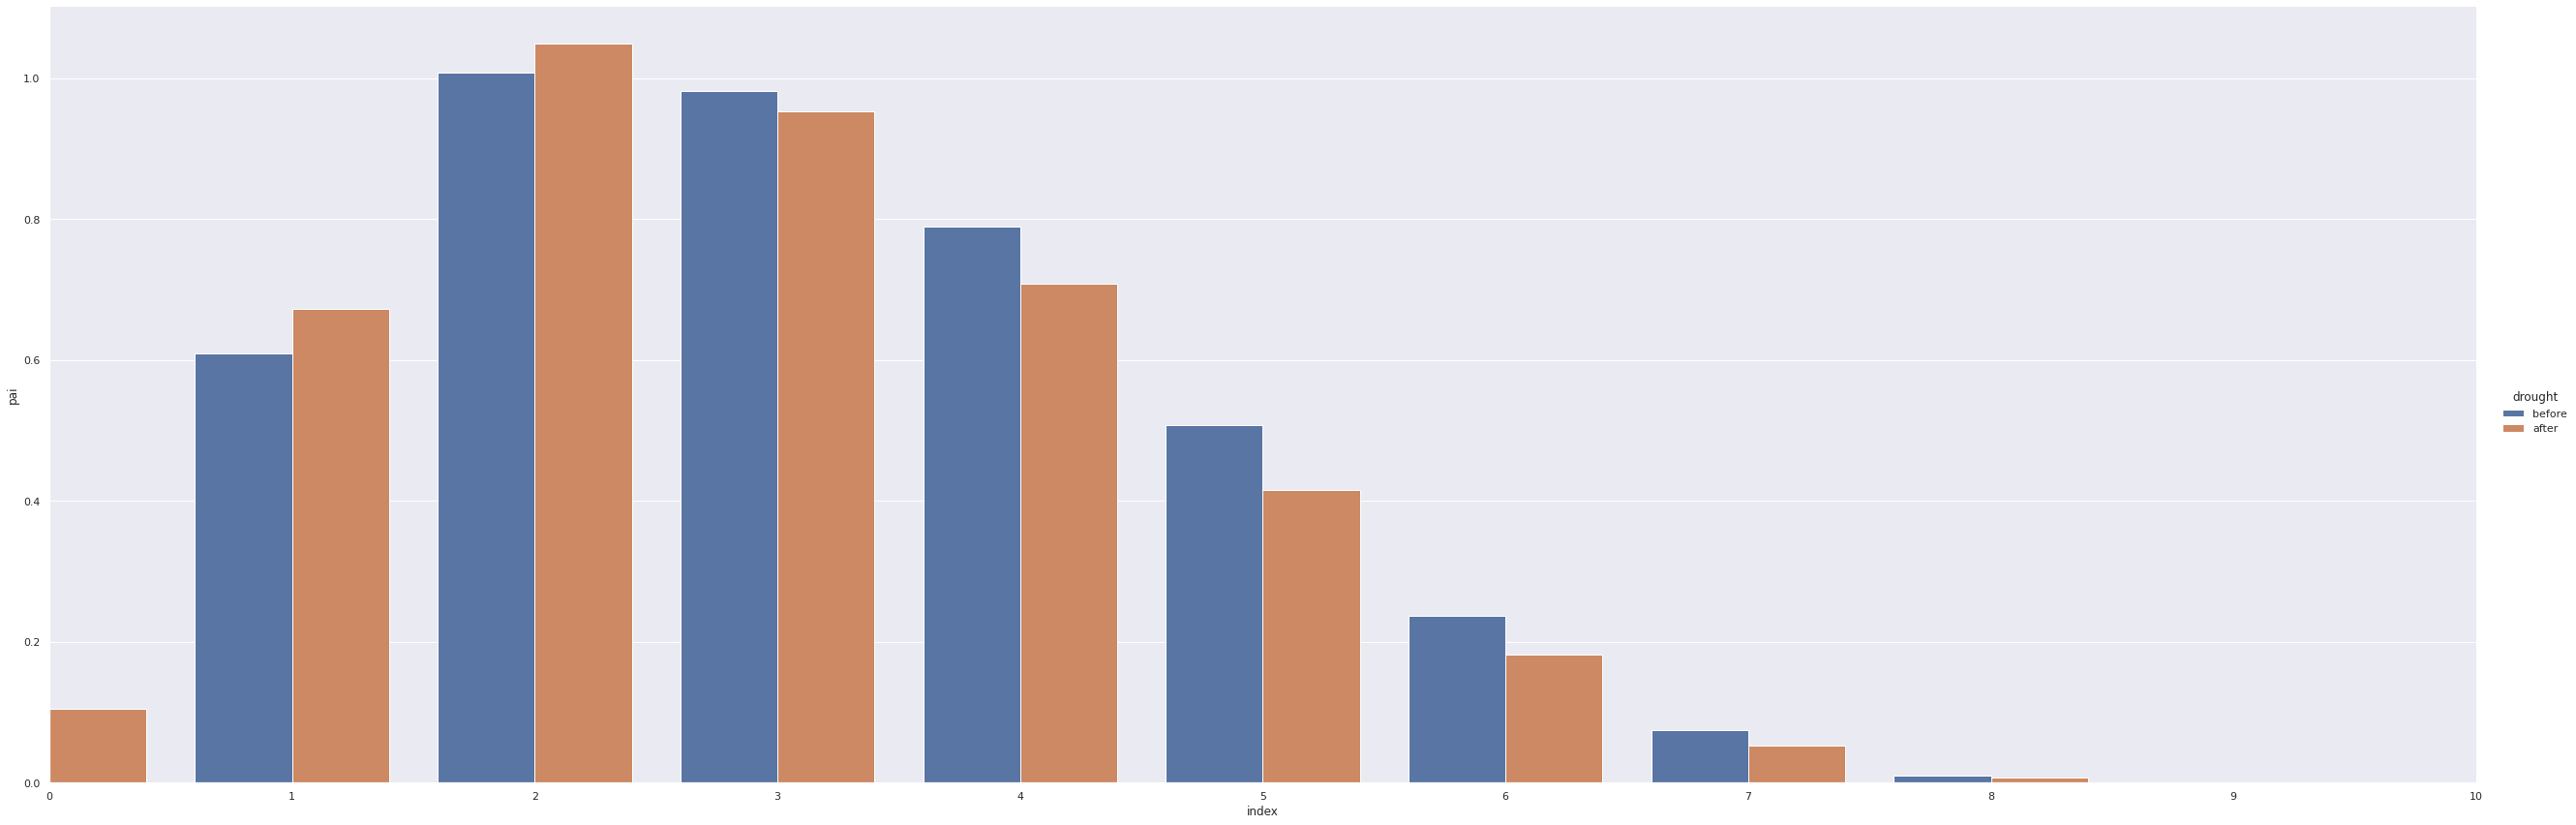

In [126]:
#fig, ax = plt.subplots(1, 1, figsize=(40, 12), sharex=True, sharey=True)
plt.rcParams['figure.figsize'] = [40, 12]
df_melted = pd.melt(p2_drought_delta[['index', 'before', 'after']], id_vars="index", var_name="drought", value_name="pai")
g= sns.catplot(x='index', y='pai', hue='drought', data=df_melted, kind='bar', height=12, aspect=3)
g.set(xlim=(0, 10))

In [ ]:
vertical_means_pdf= pd.DataFrame(vertical_means)
vertical_means_pdf['polygon_id'] = vertical_means_pdf.index + 1
vertical_df = vertical_means_pdf.set_index('polygon_id').transpose().reset_index().melt(id_vars=['index'], value_vars=[1, 2, 3, 4, 5, 6, 7, 8])

In [57]:
vm_after_drought[:12]

array([1.04289606e-01, 7.76976679e-01, 1.81775949e+00, 2.66341982e+00,
       2.93467292e+00, 2.15754752e+00, 1.11148855e+00, 3.48601457e-01,
       5.23020214e-02, 4.52756255e-03, 1.60333968e-03, 5.47084473e-04])

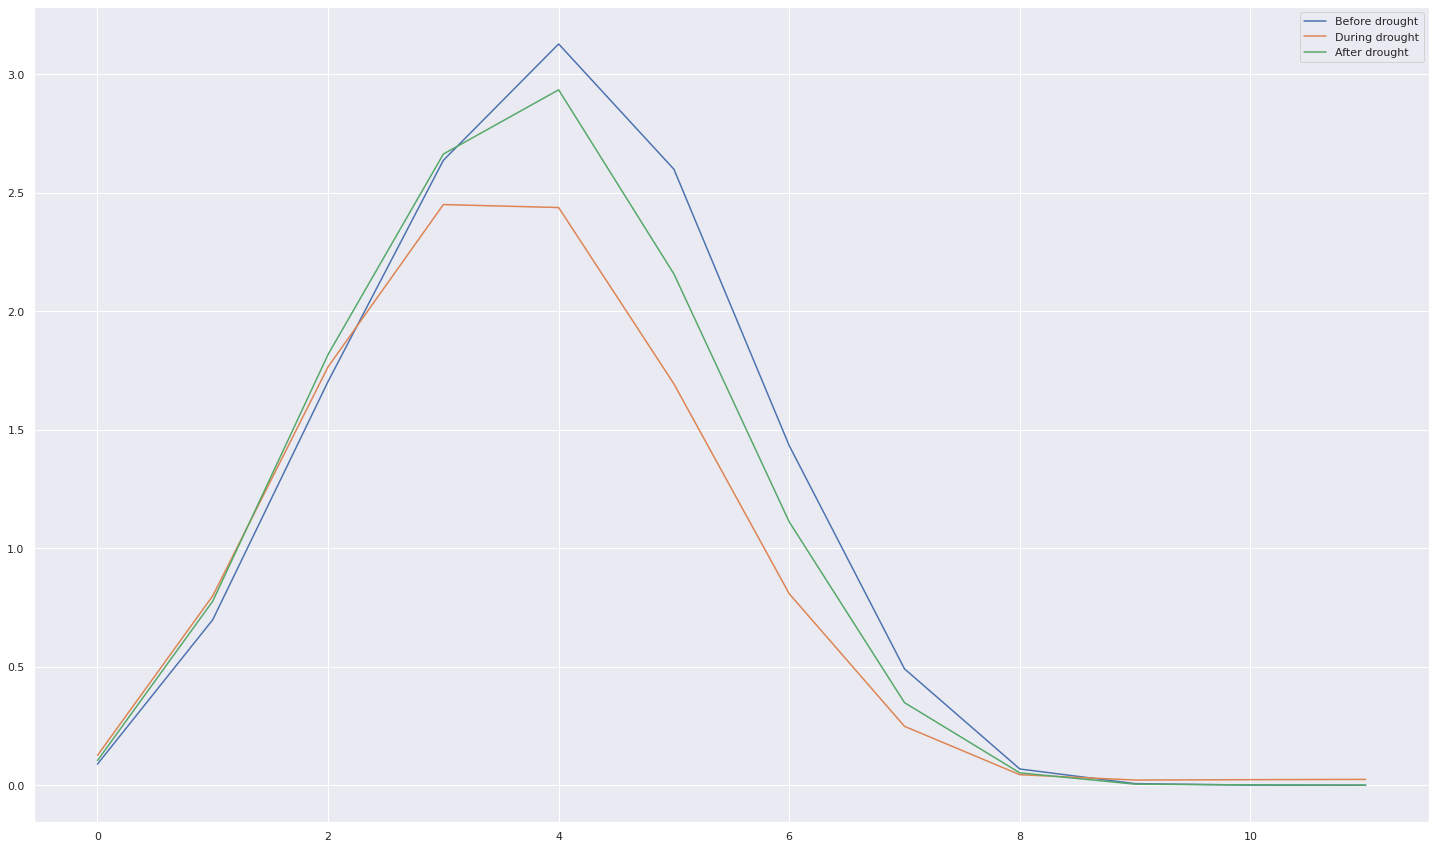

In [50]:
plt.rcParams['figure.figsize'] = [25, 15]
plt.plot(vm_before_drought[:12], label=f'Before drought')
plt.plot(vm_during_drought[:12], label=f'During drought')
plt.plot(vm_after_drought[:12], label=f'After drought')
sns.pointplot()
#plt.plot(vm_long_after_drought[:12], label=f'Long after drought')
plt.legend()

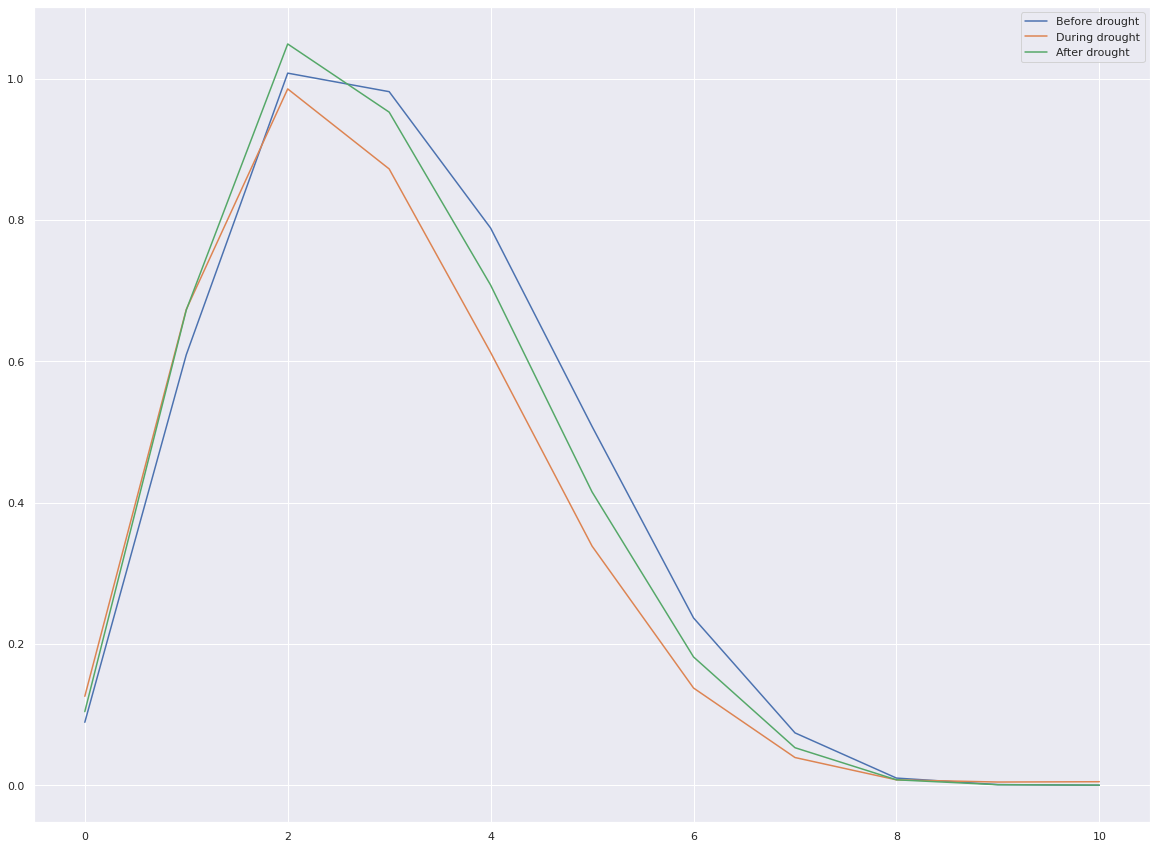

In [56]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(vm_delta_before_drought[:11], label=f'Before drought')
plt.plot(vm_delta_during_drought[:11], label=f'During drought')
plt.plot(vm_delta_after_drought[:11], label=f'After drought')
#plt.plot(vm_long_after_drought[:12], label=f'Long after drought')
plt.legend()

In [ ]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.scatterplot(x=polygon_2_before_drought.lon_lowestmode, y=polygon_2_before_drought.lat_lowestmode, alpha=0.3)
sns.scatterplot(x=polygon_2_during_drought.lon_lowestmode, y=polygon_2_during_drought.lat_lowestmode, color='red', alpha=1)
sns.scatterplot(x=polygon_2_after_drought.lon_lowestmode, y=polygon_2_after_drought.lat_lowestmode, color='green', alpha=1)
#abline(1.5, 100.8)
#abline(1.4, 93.3)
#sns.scatterplot(x=polygon_2_long_after_drought.lon_lowestmode, y=polygon_2_long_after_drought.lat_lowestmode, color='purple', alpha=1)

In [250]:
polygon_2_before_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2020) & (gedi_all.month.isin([3, 4, 5]))]
polygon_2_during_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2020) & (gedi_all.month.isin([10, 11, 12]))]
polygon_2_after_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2021) & (gedi_all.month.isin([1, 2, 3]))]
polygon_2_long_after_drought = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2022) & (gedi_all.month.isin([3, 4, 5]))]
polygon_2_middle = gedi_all[(gedi_all.polygon_id == 2) & (gedi_all.year == 2021) & (gedi_all.month.isin([7, 8, 9]))]

In [251]:
vm_before_drought = np.mean(polygon_2_before_drought.pai_z_padded.to_numpy(), axis=0)
vm_during_drought = np.mean(polygon_2_during_drought.pai_z_padded.to_numpy(), axis=0)
vm_after_drought = np.mean(polygon_2_after_drought.pai_z_padded.to_numpy(), axis=0)
vm_long_after_drought = np.mean(polygon_2_long_after_drought.pai_z_padded.to_numpy(), axis=0)
vm_middle = np.mean(polygon_2_middle.pai_z_padded.to_numpy(), axis=0)

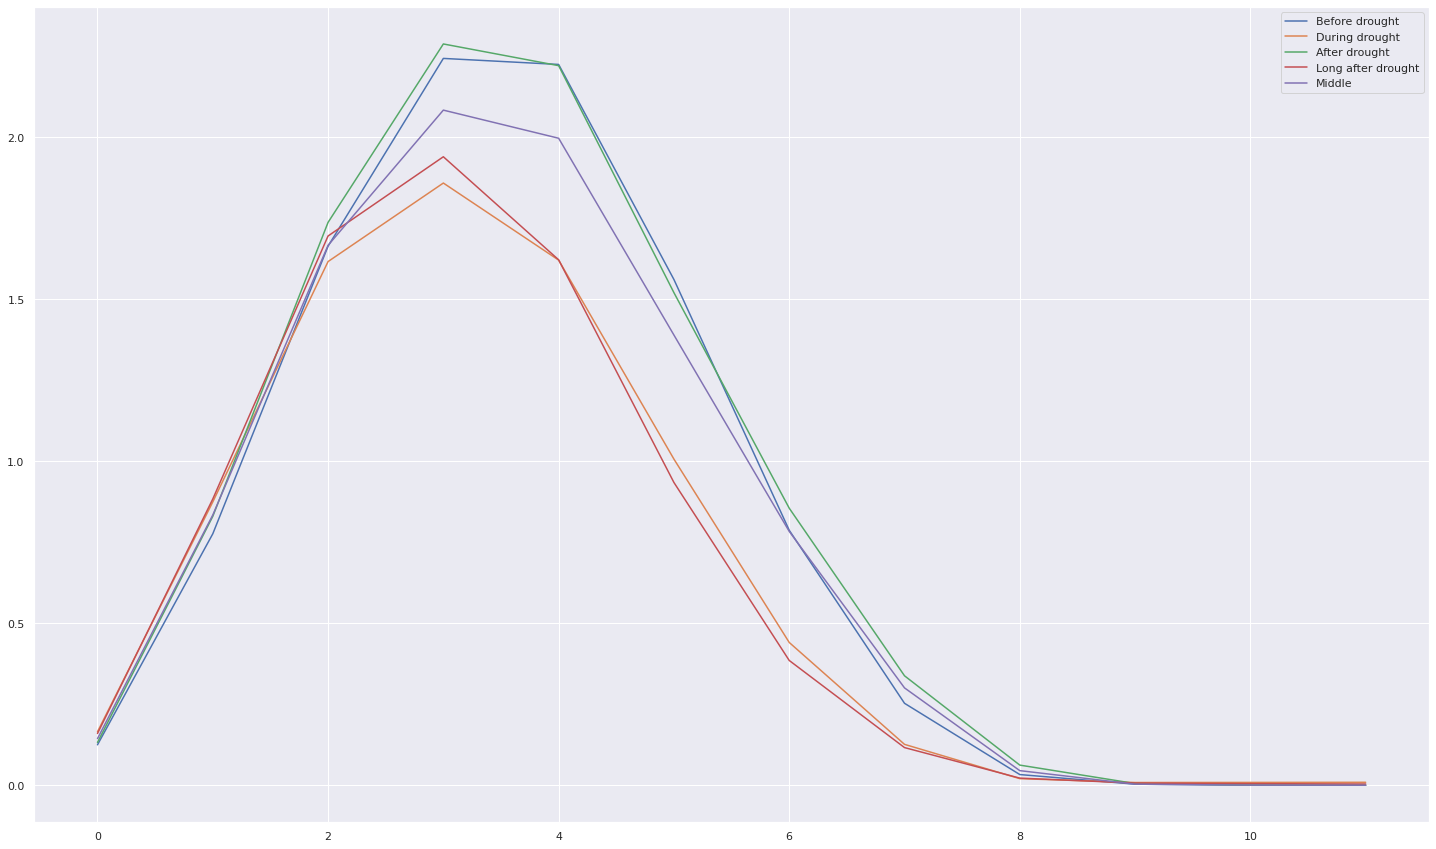

In [252]:
plt.rcParams['figure.figsize'] = [25, 15]
plt.plot(vm_before_drought[:12], label=f'Before drought')
plt.plot(vm_during_drought[:12], label=f'During drought')
plt.plot(vm_after_drought[:12], label=f'After drought')
plt.plot(vm_long_after_drought[:12], label=f'Long after drought')
plt.plot(vm_middle[:12], label=f'Middle')
plt.legend()